# <h1 style="color:red;"><b>Swing-Trading Strategy<b></h1>

## <h2 style="color:purple;">Startup</h2>

### <h3 style="color:yellow;">Start notebook timer</h3>

In [1]:
# --- START TIMER (top of notebook) ---
from time import perf_counter
from datetime import datetime

_NOTEBOOK_T0 = perf_counter()
_NOTEBOOK_START_TS = datetime.now()
print(f"Notebook start: {_NOTEBOOK_START_TS:%Y-%m-%d %H:%M:%S}")

Notebook start: 2025-12-31 11:47:25


### <h3 style="color:yellow;">Notes on how to advance this notebook</h3>

Notes:

- `ctrl + F` to search for `#PARAMETER#` string to find parameters of interest considerable consequence throughout the code. Think about defining all of these in one place at the top of the notebook.
- `ctrl + F` to search for `#MARKER#` string to jump to cells/subsections that need work. Make sure to delete the marker once the problem is resolved.
- A massive bit of the code will need to be modified or added to accommodate where the analysis period and evaluation period are not 1 and 0 respectively. Play with this.
- The walk_forward tracking system needs further work to enable it to conduct analysis apart from the data that's finalized in the Excel document.

### <h3 style="color:yellow;">Importing modules and packages</h3>

In [2]:
# === Core scientific stack (heavy use) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import itertools
import math
import time
from scipy.stats import linregress
from scipy.optimize import minimize

# === Datetime utilities ===
from datetime import datetime, date, timedelta

# === File system & OS ===
from pathlib import Path
import os
import shutil
import subprocess
import sys
import json
import re

# === Market calendars ===
import pandas_market_calendars as mcal

# === Randomness ===
import random

# === BigQuery & Cloud credentials ===
from google.cloud import bigquery
from google.oauth2 import service_account

# === Misc utilities ===
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# === HTTP, parsing ===
import requests
from io import StringIO

# === Excel output ===
from openpyxl import Workbook
from openpyxl.drawing.image import Image as XLImage

# === Image manipulation ===
from PIL import Image

# === Local config/env ===
from dotenv import load_dotenv

# === Schwab API ===
import schwabdev

### <h3 style="color:yellow;">Authentication for Schwab</h3>

Load environment variables from .env file for authentification purposes

In [3]:
load_dotenv()

True

Set the display options

In [4]:
# Display options
# Set the global float format to 4 decimal places
pd.set_option('display.float_format', lambda x: f'{x:.4f}')
pd.options.display.float_format = '{:,.4f}'.format # Format numerical output to have certain number of decimals
# pd.options.display.float_format = None # Reset to default numerical output formatting
pd.set_option('display.width', 2000) # Set the display width to a large number
pd.set_option('display.max_colwidth', 1000) # Set max column width to a large number

pd.set_option('display.max_columns', None) # Displays all columns
# pd.set_option('display.max_rows', None) # Displays all rows                             
# pd.reset_option('display.max_columns') # Display default abbreviated columns
pd.reset_option('display.max_rows') # Display default abbreviated rows

Create the client object.

In [5]:
app_key = os.getenv('app_key')
app_secret = os.getenv('app_secret')
callback_url = os.getenv('callback_url')

# Print them to verify (avoid printing sensitive info in production)
print(f"App Key: {app_key}")
print(f"App Secret: {app_secret}")
print(f"Callback URL: {callback_url}")

# Now proceed to initialize the client
client = schwabdev.Client(app_key, app_secret, callback_url)
print('Client initialized!')

App Key: 2C7Jh6zt5QdlSb0N5RnhWpaiEzKFr150
App Secret: OQGxH0GkD5bAEMA4
Callback URL: https://127.0.0.1
Client initialized!


Use this when in need of updating the refresh token.

In [6]:
# client.update_tokens(force=True)
# client = schwabdev.Client(app_key, app_secret, callback_url)

## <h2 style="color:purple;">Retrieve Data</h2>

### <h3 style="color:yellow;">Retrieve and modify Schwab data</h3>

#### <h4 style="color:limegreen;">Getting data from Schwab</h4>

**Fetching US Equity Tickers from NASDAQ Trader**

The `get_all_tickers()` function retrieves publicly traded US equity tickers.

1. **Data Sources**:

   * NASDAQ-listed: `nasdaqlisted.txt`
   * Other exchanges (NYSE, AMEX, etc.): `otherlisted.txt`

2. **Parsing**:

   * NASDAQ symbols are read and labeled as `"NASDAQ"`.
   * Other symbols are mapped to full exchange names via a code dictionary.

*Uncomment the concat line and comment the line below it to include all exchanges as originally intended.*

In [7]:
def get_all_tickers():
    """
    Download NASDAQ-listed tickers from NASDAQ Trader and return a symbol/exchange table.

    Args:
        None

    Returns:
        pd.DataFrame: A DataFrame with two columns:
            - 'ticker' (str): The stock symbol.
            - 'exchange' (str): The exchange label for each symbol (currently 'NASDAQ' for all rows).
    """
    # URLs to fetch data
    nasdaq_url = 'https://www.nasdaqtrader.com/dynamic/SymDir/nasdaqlisted.txt'
    other_url = 'https://www.nasdaqtrader.com/dynamic/SymDir/otherlisted.txt'

    # Download NASDAQ-listed tickers
    nasdaq_response = requests.get(nasdaq_url)
    nasdaq_data = pd.read_csv(StringIO(nasdaq_response.text), sep='|')
    nasdaq_df = nasdaq_data[['Symbol']].dropna().copy()
    nasdaq_df.columns = ['ticker']
    nasdaq_df['exchange'] = 'NASDAQ'

    # Download other-listed tickers (NYSE, AMEX, etc.)
    other_response = requests.get(other_url)
    other_data = pd.read_csv(StringIO(other_response.text), sep='|')
    other_df = other_data[['ACT Symbol', 'Exchange']].dropna().copy()
    other_df.columns = ['ticker', 'exchange']

    # Map exchange abbreviations to full names
    exchange_map = {
        'A': 'NYSE American',   # Formerly AMEX
        'N': 'NYSE',
        'P': 'NYSE Arca',
        'Z': 'BATS',
        'V': 'IEX'
    }

    other_df['exchange'] = other_df['exchange'].map(exchange_map).fillna('Other')

    # Combine both sources
    # all_tickers_df = pd.concat([nasdaq_df, other_df], ignore_index=True)

    all_tickers_df = nasdaq_df

    return all_tickers_df

Print number of tickers retrieved and look at a summary of the df that contains them.

In [8]:
all_tickers_schwab = get_all_tickers()
print(f"Retrieved {len(all_tickers_schwab)} tickers.")
display(all_tickers_schwab)

Retrieved 5250 tickers.


,ticker,exchange
0,AACB,NASDAQ
1,AACBR,NASDAQ
2,AACBU,NASDAQ
3,AACG,NASDAQ
4,AADR,NASDAQ
...,...,...
5246,ZXYZ.A,NASDAQ
5247,ZXZZT,NASDAQ
5248,ZYBT,NASDAQ
5249,ZYME,NASDAQ


In [9]:
def select_random_tickers(ticker_df, n=5):
    """
    Randomly selects n tickers from a DataFrame of tickers and exchanges.

    Args:
        ticker_df (pd.DataFrame): DataFrame with columns ['ticker', 'exchange'].
        n (int): Number of tickers to select.

    Returns:
        pd.DataFrame: A DataFrame with n randomly selected tickers.
    """
    return ticker_df.sample(n=min(n, len(ticker_df))).reset_index(drop=True)

Before the call of `select_random_tickers`, give the option of retaining all tickers for analysis, or just a random sample of them from `all_tickers_schwab`.

In [10]:
full_schwab_data = False #PARAMETER#
num_tickers = 250      #PARAMETER#

if full_schwab_data == True:
    schwab_ticker_num = len(all_tickers_schwab)  # Use the total number of tickers available                           
else:
    schwab_ticker_num = num_tickers # Limit to n tickers for testing purposes     

random_tickers = select_random_tickers(all_tickers_schwab, n=schwab_ticker_num)
print("Randomly selected tickers:")
print(random_tickers[:20])

Randomly selected tickers:
   ticker exchange
0    NAMM   NASDAQ
1   KVACU   NASDAQ
2   NEWTZ   NASDAQ
3     JFU   NASDAQ
4     CPB   NASDAQ
5    RVSB   NASDAQ
6    TMET   NASDAQ
7    HOOD   NASDAQ
8    SCKT   NASDAQ
9    UBCP   NASDAQ
10   MDIV   NASDAQ
11  BPYPP   NASDAQ
12  PCTTU   NASDAQ
13   PLUT   NASDAQ
14   NFXS   NASDAQ
15   FDBC   NASDAQ
16  SLDPW   NASDAQ
17   NZAC   NASDAQ
18    PTF   NASDAQ
19    FLX   NASDAQ


Combine randomly selected and major tickers into one DataFrame.

In [11]:
big_ticker_list = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"]
len_big_tickers = len(big_ticker_list)
big_tickers = pd.DataFrame({'ticker': big_ticker_list, 'exchange': ['NASDAQ'] * len_big_tickers})

# Combine random sample with manually selected big tickers
test_tickers_df = pd.concat([random_tickers, big_tickers], ignore_index=True)

# Deduplicate by 'ticker', keeping the first occurrence
test_tickers_df = test_tickers_df.drop_duplicates(subset='ticker').reset_index(drop=True)

In [12]:
def get_schwab_data(symbol, exchange=None, years=5): # Revert to this working function 1111
    """
    Fetch daily OHLC candles for a symbol from the Schwab API.

    Args:
        symbol (str): Ticker to request.
        exchange (str, optional): Exchange label to attach to each returned candle.
        years (int, optional): Number of years of daily history to request (via
            `periodType='year'`, `period=years`). Default is 1.

    Returns:
        list[dict]: One dict per candle from the API response, augmented with:
            - 'ticker' (str): The requested symbol.
            - 'exchange' (str or None): The provided exchange label.

    Schwab API - Valid Frequency Parameters for `client.price_history()`:
        frequencyType='minute':  frequency = 1, 5, 10, 15, 30
        frequencyType='daily':   frequency = 1
        frequencyType='weekly':  frequency = 1
        frequencyType='monthly': frequency = 1

    Notes:
        - startDate and endDate should be datetime objects. The client handles timestamp conversion.
        - Only minute-level data supports multiple frequency values.
    """
    end = datetime.now()
    start = end - timedelta(days=years*365)

    all_candles = []

    while start < end:
        window_end = min(start + timedelta(days=years*365), end)
        start = pd.to_datetime(start)
        window_end = pd.to_datetime(window_end)

        try:
            response = client.price_history(
                symbol=symbol,
                periodType='year',             # Comment out to get intraday candles
                period=years,                  # Comment out to get intraday candles
                frequencyType='daily',         # Changed from 'minute', Change back to get intraday candles
                frequency=1,                   # Changed from 30, Change back to get intraday candles
                # startDate=start,             # Uncomment to get intraday candles
                # endDate=window_end,          # Uncomment to get intraday candles
                needExtendedHoursData=False
            )
            json_data = response.json()

            if 'candles' in json_data and json_data['candles']:
                for candle in json_data['candles']:
                    candle["ticker"] = symbol
                    candle["exchange"] = exchange
                    all_candles.append(candle)
            else:
                print(f"No candles returned for {symbol} in this chunk.")
        except Exception as e:
            print(f"Error fetching data for {symbol}: {e}")

        time.sleep(1)
        start = window_end + timedelta(days=1)

    return all_candles

Use parallel processing to make the call of `get_schwab_data` more time efficient.

In [13]:
from concurrent.futures import ThreadPoolExecutor, as_completed

all_candles_combined = []
rows = list(test_tickers_df.itertuples(index=False))

with ThreadPoolExecutor(max_workers=min(8, len(rows))) as ex:
    future_map = {
        ex.submit(get_schwab_data, row.ticker, row.exchange, 5): row
        for row in rows
    }
    for i, future in enumerate(as_completed(future_map), start=1):
        row = future_map[future]
        try:
            candles = future.result()
            all_candles_combined.extend(candles)
            print(f"[{i}/{len(rows)}] {row.ticker}: {row.exchange}: Retrieved {len(candles)} candles")
        except Exception as e:
            print(f"Failed to retrieve {row.ticker}: {e}")

[1/255] KVACU: NASDAQ: Retrieved 192 candles
[2/255] NEWTZ: NASDAQ: Retrieved 1096 candles
[3/255] NAMM: NASDAQ: Retrieved 143 candles
[4/255] HOOD: NASDAQ: Retrieved 1111 candles
[5/255] TMET: NASDAQ: Retrieved 563 candles
[6/255] JFU: NASDAQ: Retrieved 1236 candles
[7/255] RVSB: NASDAQ: Retrieved 1256 candles
[8/255] CPB: NASDAQ: Retrieved 1256 candles
[9/255] UBCP: NASDAQ: Retrieved 1230 candles
[10/255] MDIV: NASDAQ: Retrieved 1256 candles
[11/255] BPYPP: NASDAQ: Retrieved 1256 candles
[12/255] NFXS: NASDAQ: Retrieved 311 candles
[13/255] PCTTU: NASDAQ: Retrieved 498 candles
[14/255] FDBC: NASDAQ: Retrieved 1253 candles
[15/255] PLUT: NASDAQ: Retrieved 224 candles
[16/255] SCKT: NASDAQ: Retrieved 1256 candles
[17/255] FLX: NASDAQ: Retrieved 309 candles
[18/255] NZAC: NASDAQ: Retrieved 1256 candles
[19/255] BMGL: NASDAQ: Retrieved 214 candles
[20/255] PTF: NASDAQ: Retrieved 1256 candles
[21/255] FORA: NASDAQ: Retrieved 1214 candles
[22/255] SLDPW: NASDAQ: Retrieved 1160 candles
[23/

In [14]:
# Builtins / stdlib
import concurrent.futures as cf
from concurrent.futures import ThreadPoolExecutor, Future, as_completed

# help(list)                     # list()
# help(list.sort)
# help(min)                      # min()
# help(len)                      # len()
# help(enumerate)                # enumerate()
# help(print)                    # print()
help(Exception)                # Exception base class

# # Pandas DataFrame method
# import pandas as pd
# help(pd.DataFrame.itertuples)  # test_tickers_df.itertuples(...)

# # concurrent.futures bits
# help(ThreadPoolExecutor)       # context manager, thread pool
# help(ThreadPoolExecutor.submit)# ex.submit(...)
# help(cf.as_completed)          # as_completed(...)
# help(Future.result)            # future.result(...)

# # Your own function
# help(get_schwab_data)          # user-defined function

# # List method used
# help(list.extend)              # all_candles_combined.extend(...)


Help on class Exception in module builtins:

class Exception(BaseException)
 |  Common base class for all non-exit exceptions.
 |
 |  Method resolution order:
 |      Exception
 |      BaseException
 |      object
 |
 |  Built-in subclasses:
 |      ArithmeticError
 |      AssertionError
 |      AttributeError
 |      BufferError
 |      ... and 16 other subclasses
 |
 |  Methods defined here:
 |
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  ----------------------------------------------------------------------
 |  Static methods defined here:
 |
 |  __new__(*args, **kwargs)
 |      Create and return a new object.  See help(type) for accurate signature.
 |
 |  ----------------------------------------------------------------------
 |  Methods inherited from BaseException:
 |
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |
 |  __reduce__(...)
 |      Helper for pickle.
 |
 |  __repr__(self, 

In [15]:
display(all_candles_combined)

[{'open': 10.1,
  'high': 10.12,
  'low': 10.08,
  'close': 10.08,
  'volume': 15901497,
  'datetime': 1690261200000,
  'ticker': 'KVACU',
  'exchange': 'NASDAQ'},
 {'open': 10.09,
  'high': 10.11,
  'low': 10.08,
  'close': 10.08,
  'volume': 1605265,
  'datetime': 1690347600000,
  'ticker': 'KVACU',
  'exchange': 'NASDAQ'},
 {'open': 10.0982,
  'high': 10.1,
  'low': 10.09,
  'close': 10.1,
  'volume': 108914,
  'datetime': 1690434000000,
  'ticker': 'KVACU',
  'exchange': 'NASDAQ'},
 {'open': 10.1,
  'high': 10.1,
  'low': 10.07,
  'close': 10.1,
  'volume': 161673,
  'datetime': 1690520400000,
  'ticker': 'KVACU',
  'exchange': 'NASDAQ'},
 {'open': 10.1,
  'high': 10.1,
  'low': 10.09,
  'close': 10.09,
  'volume': 9623,
  'datetime': 1690779600000,
  'ticker': 'KVACU',
  'exchange': 'NASDAQ'},
 {'open': 10.1,
  'high': 10.1,
  'low': 10.09,
  'close': 10.1,
  'volume': 9572,
  'datetime': 1690866000000,
  'ticker': 'KVACU',
  'exchange': 'NASDAQ'},
 {'open': 10.0999,
  'high': 10.

#### <h4 style="color:limegreen;">Slice Schwab data into analysis component periods</h4>

Convert the combined candle list into a DataFrame, parses timestamps, sorts the data, and then splits it into a dictionary of DataFrames—one per ticker—for easy access and analysis.


In [16]:
daily_format = True #PARAMETER#

# Convert `all_candles_combined` to DataFrame
candles_df_0 = pd.DataFrame(all_candles_combined)
if daily_format:
    candles_df_0['date_time'] = pd.to_datetime(candles_df_0['datetime'], unit='ms').dt.normalize()
else:
    candles_df_0['date_time'] = pd.to_datetime(candles_df_0['datetime'], unit='ms')
    
candles_df_0 = candles_df_0.sort_values(['ticker', 'date_time']).reset_index(drop=True)

# Split candles_df_0 into a dictionary of DataFrames by ticker
candles_dict_schwab_0 = {
    ticker: df.reset_index(drop=True)
    for ticker, df in candles_df_0.groupby("ticker")
}

display(candles_df_0['date_time'].max().strftime('%Y-%m-%d'))
display(candles_df_0)
display(candles_dict_schwab_0)

'2025-12-30'

,open,high,low,close,volume,datetime,ticker,exchange,date_time
0,9.8800,10.1000,9.8800,9.8800,8365,1744002000000,AACB,NASDAQ,2025-04-07
1,9.9500,9.9500,9.9500,9.9500,144,1744088400000,AACB,NASDAQ,2025-04-08
2,9.9000,9.9000,9.9000,9.9000,125094,1744174800000,AACB,NASDAQ,2025-04-09
3,9.8500,9.9000,9.8500,9.8900,101015,1744261200000,AACB,NASDAQ,2025-04-10
4,9.8800,9.8900,9.8800,9.8850,641672,1744347600000,AACB,NASDAQ,2025-04-11
...,...,...,...,...,...,...,...,...,...
223926,50.8601,50.8800,50.8601,50.8800,205,1766469600000,ZTWO,NASDAQ,2025-12-23
223927,50.9100,50.9200,50.9100,50.9200,230,1766556000000,ZTWO,NASDAQ,2025-12-24
223928,50.9401,50.9600,50.9401,50.9600,1577,1766728800000,ZTWO,NASDAQ,2025-12-26
223929,50.9900,50.9950,50.9766,50.9950,811,1766988000000,ZTWO,NASDAQ,2025-12-29


{'AACB':        open    high     low   close  volume       datetime ticker exchange  date_time
 0    9.8800 10.1000  9.8800  9.8800    8365  1744002000000   AACB   NASDAQ 2025-04-07
 1    9.9500  9.9500  9.9500  9.9500     144  1744088400000   AACB   NASDAQ 2025-04-08
 2    9.9000  9.9000  9.9000  9.9000  125094  1744174800000   AACB   NASDAQ 2025-04-09
 3    9.8500  9.9000  9.8500  9.8900  101015  1744261200000   AACB   NASDAQ 2025-04-10
 4    9.8800  9.8900  9.8800  9.8850  641672  1744347600000   AACB   NASDAQ 2025-04-11
 ..      ...     ...     ...     ...     ...            ...    ...      ...        ...
 128 10.3400 10.3400 10.2900 10.3100    3867  1765951200000   AACB   NASDAQ 2025-12-17
 129 10.3100 10.3100 10.3000 10.3000  459419  1766037600000   AACB   NASDAQ 2025-12-18
 130 10.3200 10.3200 10.3000 10.3000   70858  1766124000000   AACB   NASDAQ 2025-12-19
 131 10.3000 10.3000 10.2900 10.2900   38886  1766556000000   AACB   NASDAQ 2025-12-24
 132 10.3000 10.3000 10.2900 10.300

In [17]:
def slice_years_from_df(candles_df, end_date, years=1):
    """
    Return the last 1-year slice of a candle DataFrame ending at `end_date` (inclusive).

    Args:
        candles_df (pd.DataFrame): Input table containing at least
            - 'date_time' (datetime-like): Timestamp per row (will be coerced to datetime).
            - 'ticker' (str): Used for final sorting.
        end_date (datetime-like): Inclusive end of the 1-year window.

    Returns:
        pd.DataFrame: Copy of rows where start < date_time ≤ end_date, with
            'date_time' coerced to datetime, sorted by ['ticker', 'date_time'],
            and index reset. Rows with invalid 'date_time' (NaT) are dropped by the filter.
    """
    end = pd.to_datetime(end_date)
    start = end - pd.Timedelta(days=years*365)
    df = candles_df.copy()
    df["date_time"] = pd.to_datetime(df["date_time"], errors="coerce")
    out = df.loc[(df["date_time"] > start) & (df["date_time"] <= end)]
    return out.sort_values(["ticker", "date_time"]).reset_index(drop=True)

def slice_years_from_dict(candles_dict, end_date, years=1):
    """
    Slice each ticker’s DataFrame to the last 1-year window ending at `end_date` (inclusive).

    Args:
        candles_dict (dict[str, pd.DataFrame]): Mapping of ticker → candle table.
            Each DataFrame should contain a 'date_time' column (will be coerced to datetime).
        end_date (datetime-like): Inclusive end of the 1-year window.

    Returns:
        dict[str, pd.DataFrame]: New mapping with per-ticker DataFrames filtered to
            (start, end_date] where start = end_date − 365 days. Each output is
            sorted by 'date_time' and has its index reset. Rows with invalid
            'date_time' (NaT) are excluded by the filter.
    """
    end = pd.to_datetime(end_date)
    start = end - pd.Timedelta(days=years*365)
    out = {}
    for ticker, df in candles_dict.items():
        if "date_time" not in df.columns:
            continue
        sub = df.copy()
        sub["date_time"] = pd.to_datetime(sub["date_time"], errors="coerce")
        sub = sub.loc[(sub["date_time"] > start) & (sub["date_time"] <= end)]
        out[ticker] = sub.sort_values("date_time").reset_index(drop=True)
    return out

Slice one year from the combined ticker DataFrame and the dictionary of ticker DataFrames up to a chosen end date.

In [18]:
# --- Slice exactly 1 year ending at a chosen date ---
walk_forward = True           #PARAMETER#
walk_forward_months = 4        #PARAMETER#
years_data = 2                 #PARAMETER#

chosen_end_date = None
# _candidate_dt = None
# _bd = None

if walk_forward:
    # Max date minus N months, then roll back to previous business day if weekend
    # _candidate_dt = pd.to_datetime(candles_df['date_time'].max()) - pd.DateOffset(months=walk_forward_months)
    # _bd = pd.tseries.offsets.BDay()  # Mon–Fri (no holidays)
    chosen_end_date = pd.tseries.offsets.BDay().rollback(pd.to_datetime(candles_df_0['date_time'].max()) - pd.DateOffset(months=walk_forward_months)).strftime('%Y-%m-%d')
else:
    # If not in walk-forward mode, use the max date_time as the end date
    chosen_end_date = candles_df_0['date_time'].max().strftime('%Y-%m-%d')

display(candles_df_0['date_time'].max().strftime('%Y-%m-%d'))
display(chosen_end_date)

'2025-12-30'

'2025-08-29'

In [19]:
if walk_forward is True:
    candles_df = slice_years_from_df(candles_df_0, chosen_end_date, years=years_data)
    candles_dict_schwab = slice_years_from_dict(candles_dict_schwab_0, chosen_end_date, years=years_data)  #MARKER#
else:
    candles_df = candles_df_0
    candles_dict_schwab = candles_dict_schwab_0

display(candles_df['date_time'].max().strftime('%Y-%m-%d'))
display(chosen_end_date)
display(candles_df)
display(candles_dict_schwab)

'2025-08-29'

'2025-08-29'

,open,high,low,close,volume,datetime,ticker,exchange,date_time
0,9.8800,10.1000,9.8800,9.8800,8365,1744002000000,AACB,NASDAQ,2025-04-07
1,9.9500,9.9500,9.9500,9.9500,144,1744088400000,AACB,NASDAQ,2025-04-08
2,9.9000,9.9000,9.9000,9.9000,125094,1744174800000,AACB,NASDAQ,2025-04-09
3,9.8500,9.9000,9.8500,9.8900,101015,1744261200000,AACB,NASDAQ,2025-04-10
4,9.8800,9.8900,9.8800,9.8850,641672,1744347600000,AACB,NASDAQ,2025-04-11
...,...,...,...,...,...,...,...,...,...
98627,50.8300,50.8300,50.8250,50.8250,341,1756098000000,ZTWO,NASDAQ,2025-08-25
98628,50.8300,50.8650,50.8300,50.8650,656,1756184400000,ZTWO,NASDAQ,2025-08-26
98629,50.8600,50.8850,50.8600,50.8850,113,1756270800000,ZTWO,NASDAQ,2025-08-27
98630,50.8750,50.8750,50.8750,50.8750,79,1756357200000,ZTWO,NASDAQ,2025-08-28


{'AACB':       open    high     low   close  volume       datetime ticker exchange  date_time
 0   9.8800 10.1000  9.8800  9.8800    8365  1744002000000   AACB   NASDAQ 2025-04-07
 1   9.9500  9.9500  9.9500  9.9500     144  1744088400000   AACB   NASDAQ 2025-04-08
 2   9.9000  9.9000  9.9000  9.9000  125094  1744174800000   AACB   NASDAQ 2025-04-09
 3   9.8500  9.9000  9.8500  9.8900  101015  1744261200000   AACB   NASDAQ 2025-04-10
 4   9.8800  9.8900  9.8800  9.8850  641672  1744347600000   AACB   NASDAQ 2025-04-11
 ..     ...     ...     ...     ...     ...            ...    ...      ...        ...
 75 10.1300 10.1300 10.1300 10.1300   28144  1755493200000   AACB   NASDAQ 2025-08-18
 76 10.1400 10.1400 10.1400 10.1400     622  1755666000000   AACB   NASDAQ 2025-08-20
 77 10.1200 10.1200 10.1200 10.1200    5030  1755752400000   AACB   NASDAQ 2025-08-21
 78 10.1400 10.1400 10.1400 10.1400  271796  1756184400000   AACB   NASDAQ 2025-08-26
 79 10.1300 10.1300 10.1300 10.1300     513  1

If `daily_format` is `False`, this filters out future timestamps from `candles_df` based on the current time. This avoids certain oddities that were causing problems.

In [20]:
if not daily_format:
    now = pd.Timestamp.now().replace(tzinfo=None)
    candles_df = candles_df[candles_df["date_time"] <= now]

    display(candles_df)

### <h3 style="color:yellow;">Schwab candle summaries for filtering</h3>

In [21]:
def build_candle_summary(candles_df, daily_format=True):
    """
    Build a per-ticker summary table from raw candle data.

    Args:
        candles_df (pd.DataFrame): Candle history with at least the columns
            ['ticker', 'exchange', 'date_time', 'close', 'volume'].
            'date_time' may be date-only or full datetime.
        daily_format (bool): If True, treats 'date_time' as date-only and coerces
            outputs to naive pandas Timestamps. If False, coerces to naive datetimes
            (tz removed) before summarizing.

    Returns:
        pd.DataFrame: One row per ticker with the following columns:
            - ticker (str)
            - exchange (str): First observed exchange for the ticker.
            - candle_count (int): Number of rows in candles_df for the ticker.
            - first_candle (Timestamp): Earliest date_time.
            - last_candle  (Timestamp): Latest date_time.
            - average_close_price (float): Mean of 'close'.
            - average_volume (float): Mean of 'volume'.
            - liquidity_proxy (float): average_close_price × average_volume.
            - candle_density (float): candle_count divided by the max candle_count across tickers.
            - total_hours (float): (last_candle − first_candle) in hours.
            - total_days (float): Duration in days.
            - total_weeks (float): Duration in weeks.
    """
    summary = (
        candles_df
        .groupby('ticker')
        .agg(
            exchange=('exchange', 'first'),
            candle_count=('date_time', 'count'),
            first_candle=('date_time', 'min'),
            last_candle=('date_time', 'max'),
            average_close_price=('close', 'mean'),
            average_volume=('volume', 'mean')
        )
        .reset_index()
    )

    # Estimate average market cap
    summary['liquidity_proxy'] = summary['average_close_price'] * summary['average_volume']

    # Calculate density relative to max candle count
    max_candles = summary['candle_count'].max()
    summary['candle_density'] = summary['candle_count'] / max_candles

    # Convert to datetime if date-only format is used
    if daily_format:
        summary['first_candle'] = pd.to_datetime(summary['first_candle'])
        summary['last_candle'] = pd.to_datetime(summary['last_candle'])
    else:
        # Ensure datetime is clean and not timezone-aware
        summary['first_candle'] = pd.to_datetime(summary['first_candle']).dt.tz_localize(None)
        summary['last_candle'] = pd.to_datetime(summary['last_candle']).dt.tz_localize(None)

    # Compute duration metrics
    duration = summary['last_candle'] - summary['first_candle']
    summary['total_hours'] = duration.dt.total_seconds() / 3600
    summary['total_days'] = duration.dt.total_seconds() / (3600 * 24)
    summary['total_weeks'] = duration.dt.total_seconds() / (3600 * 24 * 7)

    return summary

Build a summary of the candle data by calling `build_candle_summary` on `candles_df`.


In [22]:
# pd.set_option('display.max_rows', None) # Displays all rows
pd.reset_option('display.max_rows') # Display default abbreviated rows

summary_candles_df = build_candle_summary(candles_df, daily_format=daily_format)
print(len(summary_candles_df), "tickers with data")
display(summary_candles_df.sort_values("liquidity_proxy", ascending=False))

pd.reset_option('display.max_rows') # Display default abbreviated rows

241 tickers with data


,ticker,exchange,candle_count,first_candle,last_candle,average_close_price,average_volume,liquidity_proxy,candle_density,total_hours,total_days,total_weeks
215,TSLA,NASDAQ,501,2023-08-31,2025-08-29,261.5637,"102,017,246.5110","26,684,009,723.7124",1.0000,"17,496.0000",729.0000,104.1429
1,AAPL,NASDAQ,501,2023-08-31,2025-08-29,206.3135,"56,910,070.3713","11,741,317,677.8242",1.0000,"17,496.0000",729.0000,104.1429
133,MSFT,NASDAQ,501,2023-08-31,2025-08-29,416.2864,"21,834,660.2834","9,089,472,063.5983",1.0000,"17,496.0000",729.0000,104.1429
9,AMZN,NASDAQ,501,2023-08-31,2025-08-29,186.0087,"43,810,276.7585","8,149,092,302.9367",1.0000,"17,496.0000",729.0000,104.1429
84,GOOGL,NASDAQ,501,2023-08-31,2025-08-29,163.4910,"30,412,055.0758","4,972,096,932.1893",1.0000,"17,496.0000",729.0000,104.1429
...,...,...,...,...,...,...,...,...,...,...,...,...
58,ECXWW,NASDAQ,318,2023-08-31,2025-08-29,0.0437,"58,446.3302","2,553.9607",0.6347,"17,496.0000",729.0000,104.1429
123,LUCYW,NASDAQ,325,2023-08-31,2025-08-29,0.0751,"16,338.4831","1,226.4414",0.6487,"17,496.0000",729.0000,104.1429
79,GDEVW,NASDAQ,176,2023-08-31,2025-08-29,0.0586,"14,752.4375",864.7844,0.3513,"17,496.0000",729.0000,104.1429
204,SXTPW,NASDAQ,280,2023-08-31,2025-08-29,0.0797,"9,324.3679",742.9936,0.5589,"17,496.0000",729.0000,104.1429


In [23]:
def plot_histogram(data, column, bins=100, log_scale=False):
    """
    Plot a histogram of a numeric column from a DataFrame.

    Args:
        data (pd.DataFrame): Source table containing the column to visualize.
        column (str): Name of the numeric column to plot; NaNs are dropped before plotting.
        bins (int, optional): Number of histogram bins. Defaults to 100.
        log_scale (bool, optional): If True, use a logarithmic x-axis (requires strictly positive data). Defaults to False.

    Returns:
        None. Displays the histogram with title, axis labels, grid, and tight layout.
    """
    plt.figure(figsize=(10, 5))
    plt.hist(data[column].dropna(), bins=bins, edgecolor='black')
    plt.title(f"Histogram of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    if log_scale:
        plt.xscale("log")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Taking a look at the distributions of some aggregate price and volume related metrics. `liquidity_proxy` is simply `average_close_price` multiplied by `average_volume` and measures the ease of entering and exiting positions of the ticker without too much slippage assuming a market order type. `candle_density` is the number of candles for each ticker out of the expected number of candles within the time frame.

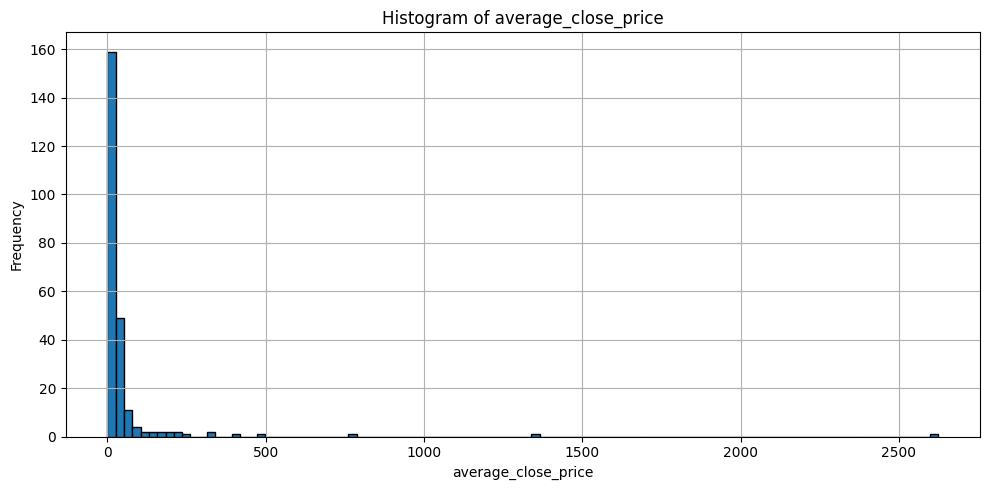

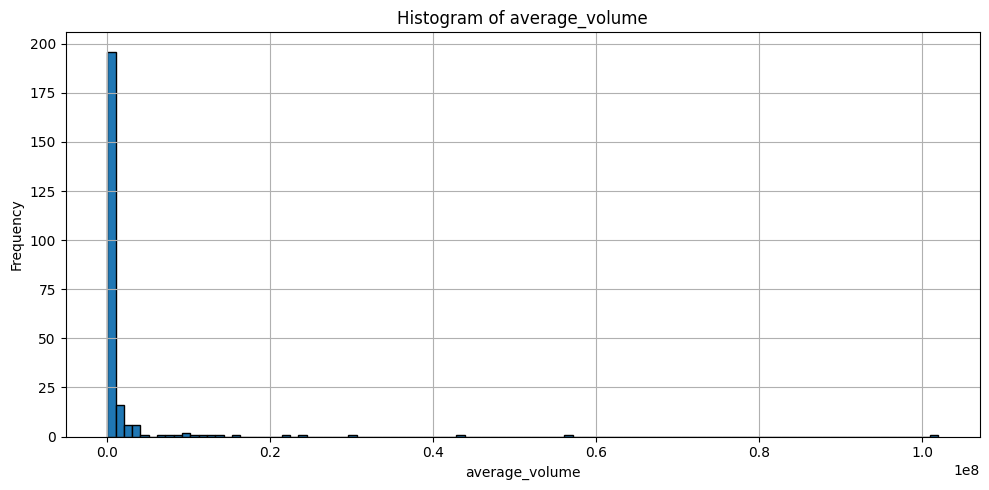

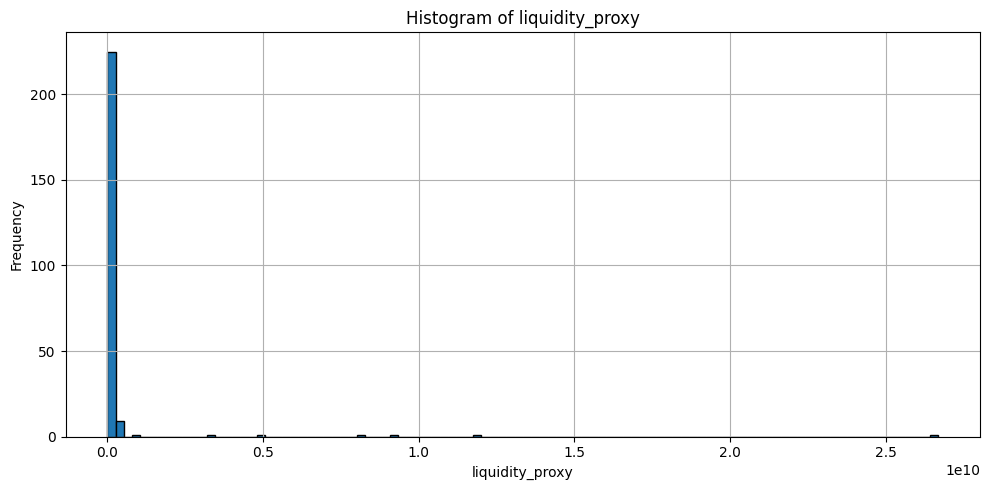

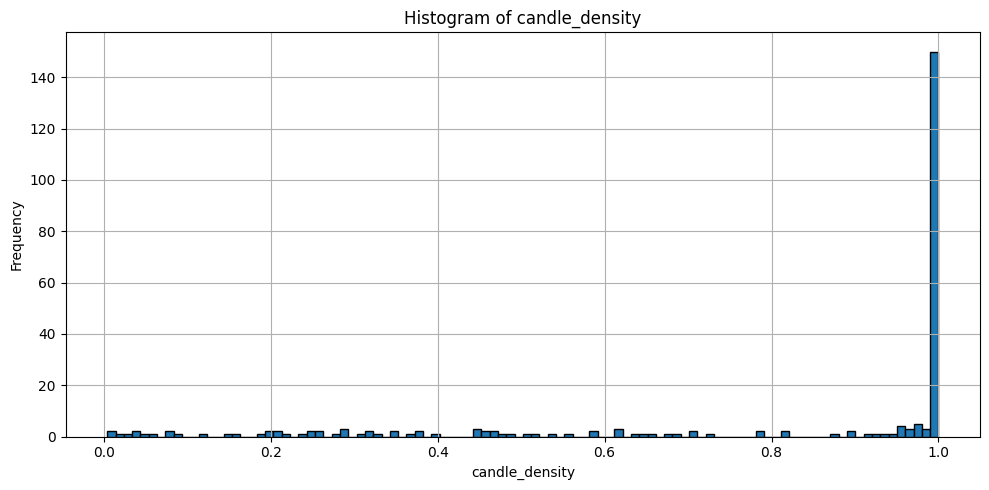

In [24]:
plot_histogram(summary_candles_df, "average_close_price")
plot_histogram(summary_candles_df, "average_volume")
plot_histogram(summary_candles_df, "liquidity_proxy")
plot_histogram(summary_candles_df, "candle_density")

Filters `summary_candles_df` to include only tickers with `metrics` obeying `metrics_thresholds`, removes duplicates, and converts the result to a list.

In [25]:
candle_density_threshold = 0.5 #PARAMETER#
average_close_price_threshold = 1_000
average_volume_threshold = 100_000
liquidity_proxy_threshold = 2_500_000

filtered_summary_candles_df = summary_candles_df[
    (summary_candles_df["candle_density"] >= candle_density_threshold) &
    (summary_candles_df["average_close_price"] < average_close_price_threshold) &
    (summary_candles_df["average_volume"] > average_volume_threshold) &
    (summary_candles_df["liquidity_proxy"] > liquidity_proxy_threshold)
].reset_index(drop=True)

tickers_to_test_schwab = filtered_summary_candles_df["ticker"].drop_duplicates().tolist()

print('filtered_summary_candles_df')
display(filtered_summary_candles_df.sort_values("liquidity_proxy", ascending=False))
print(len(tickers_to_test_schwab), "tickers to test")
print('tickers_to_test_schwab:')
display(tickers_to_test_schwab)

filtered_summary_candles_df


,ticker,exchange,candle_count,first_candle,last_candle,average_close_price,average_volume,liquidity_proxy,candle_density,total_hours,total_days,total_weeks
76,TSLA,NASDAQ,501,2023-08-31,2025-08-29,261.5637,"102,017,246.5110","26,684,009,723.7124",1.0000,"17,496.0000",729.0000,104.1429
0,AAPL,NASDAQ,501,2023-08-31,2025-08-29,206.3135,"56,910,070.3713","11,741,317,677.8242",1.0000,"17,496.0000",729.0000,104.1429
53,MSFT,NASDAQ,501,2023-08-31,2025-08-29,416.2864,"21,834,660.2834","9,089,472,063.5983",1.0000,"17,496.0000",729.0000,104.1429
6,AMZN,NASDAQ,501,2023-08-31,2025-08-29,186.0087,"43,810,276.7585","8,149,092,302.9367",1.0000,"17,496.0000",729.0000,104.1429
30,GOOGL,NASDAQ,501,2023-08-31,2025-08-29,163.4910,"30,412,055.0758","4,972,096,932.1893",1.0000,"17,496.0000",729.0000,104.1429
...,...,...,...,...,...,...,...,...,...,...,...,...
58,PAL,NASDAQ,328,2024-05-09,2025-08-29,11.3544,"261,130.6098","2,964,970.8865",0.6547,"11,448.0000",477.0000,68.1429
69,SLRC,NASDAQ,501,2023-08-31,2025-08-29,15.7825,"177,947.5689","2,808,449.5139",1.0000,"17,496.0000",729.0000,104.1429
71,SNOA,NASDAQ,501,2023-08-31,2025-08-29,4.4153,"606,515.8184","2,677,924.8869",1.0000,"17,496.0000",729.0000,104.1429
5,AMTX,NASDAQ,501,2023-08-31,2025-08-29,3.2027,"799,099.0060","2,559,278.0550",1.0000,"17,496.0000",729.0000,104.1429


84 tickers to test
tickers_to_test_schwab:


['AAPL',
 'ACHC',
 'AFRM',
 'AGMH',
 'ALKT',
 'AMTX',
 'AMZN',
 'ASLE',
 'ASTS',
 'ATYR',
 'BLDP',
 'BSCS',
 'BZAI',
 'CENT',
 'CIFR',
 'CNXC',
 'CORT',
 'CPB',
 'CRTO',
 'CTAS',
 'DFLI',
 'DJT',
 'DOGZ',
 'EA',
 'EOSE',
 'EWBC',
 'FA',
 'FLYW',
 'GCTK',
 'GLMD',
 'GOOGL',
 'GPRE',
 'GPRO',
 'GRI',
 'GSAT',
 'HCWB',
 'HOOD',
 'HRMY',
 'HROW',
 'HRZN',
 'IART',
 'IBB',
 'IBTH',
 'IDXX',
 'JD',
 'KBWB',
 'KELYA',
 'LASE',
 'LBTYA',
 'LIF',
 'MBB',
 'MDLZ',
 'METC',
 'MSFT',
 'MSTR',
 'NRDS',
 'NWL',
 'OMEX',
 'PAL',
 'PAYO',
 'PEBO',
 'PLAB',
 'PRAX',
 'RMBS',
 'RNA',
 'RPAY',
 'SAVA',
 'SBAC',
 'SFIX',
 'SLRC',
 'SMST',
 'SNOA',
 'SRPT',
 'STGW',
 'SUPN',
 'TSEM',
 'TSLA',
 'VECO',
 'VIGI',
 'VNET',
 'VNOM',
 'VRIG',
 'WGS',
 'ZG']

### <h3 style="color:yellow;">Save Schwab data to disk</h3>

Resets the data directory structure by removing `DATA_DIR` (if present) and recreating it with `walk-forward-schwab` and `walk-forward-gbq` subfolders, while defining path constants including `MINUTE_TICKERS_FILE`.


In [26]:
# Path setup
DATA_DIR = Path("strategies/swing-trading/data")
WALK_FORWARD_DIR_SCHWAB = DATA_DIR / "walk-forward-schwab"
MINUTE_TICKERS_FILE = DATA_DIR / "tickers_random_index_list.txt"

# Delete the entire DATA_DIR folder and all its contents
if DATA_DIR.exists() and DATA_DIR.is_dir():
    shutil.rmtree(DATA_DIR)
    print(f"Deleted: {DATA_DIR}")
else:
    print(f"Directory does not exist: {DATA_DIR}")

DATA_DIR.mkdir(parents=True, exist_ok=True)
WALK_FORWARD_DIR_SCHWAB.mkdir(parents=True, exist_ok=True)

Deleted: strategies\swing-trading\data


In [27]:
def save_ticker_data(data_dict, end_path_component):
    """
    Saves each DataFrame in a dictionary to a separate tab-delimited .txt file under a specified subdirectory.

    Args:
        data_dict (dict): Dictionary where keys are ticker symbols and values are pandas DataFrames.
        end_path_component (str): Subfolder name under DATA_DIR where files will be saved.

    Returns:
        None. Files are saved to disk, and progress is printed to the console.
    """
    DAILY_TICKER_DATA_DIR = DATA_DIR / end_path_component
    DAILY_TICKER_DATA_DIR.mkdir(parents=True, exist_ok=True)

    num_tickers = len(data_dict)
    for i, (ticker, df) in enumerate(data_dict.items(), start=1):
        if not isinstance(df, pd.DataFrame) or df.empty:
            print(f"({i}/{num_tickers}) Skipping {ticker} — no data available")
            continue

        output_file = DAILY_TICKER_DATA_DIR / f"{ticker}.txt"
        try:
            df.to_csv(output_file, sep="\t", index=False)
            print(f"({i}/{num_tickers}) Saved {ticker} data to {output_file}")
        except Exception as e:
            print(f"({i}/{num_tickers}) Failed to save {ticker}: {e}")

Save Schwab data to disk.

In [28]:
print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
save_ticker_data(candles_dict_schwab, "local-ticker-data-schwab")

2025-12-31 11:48:18
(1/254) Saved AACB data to strategies\swing-trading\data\local-ticker-data-schwab\AACB.txt
(2/254) Saved AAPL data to strategies\swing-trading\data\local-ticker-data-schwab\AAPL.txt
(3/254) Saved ABLV data to strategies\swing-trading\data\local-ticker-data-schwab\ABLV.txt
(4/254) Saved ACHC data to strategies\swing-trading\data\local-ticker-data-schwab\ACHC.txt
(5/254) Saved ADSE data to strategies\swing-trading\data\local-ticker-data-schwab\ADSE.txt
(6/254) Saved AFRM data to strategies\swing-trading\data\local-ticker-data-schwab\AFRM.txt
(7/254) Saved AGMH data to strategies\swing-trading\data\local-ticker-data-schwab\AGMH.txt
(8/254) Skipping AGPU — no data available
(9/254) Skipping AHMA — no data available
(10/254) Saved ALKT data to strategies\swing-trading\data\local-ticker-data-schwab\ALKT.txt
(11/254) Saved AMTX data to strategies\swing-trading\data\local-ticker-data-schwab\AMTX.txt
(12/254) Saved AMZN data to strategies\swing-trading\data\local-ticker-data

## <h2 style="color:purple;">Begin Feature Engineering and Back-Testing</h2>

### <h3 style="color:yellow;">Running analysis on Schwab data (Start Eval Scrub Here vvv)</h3>

#### <h4 style="color:limegreen;">Prepare analysis structure</h4>

Delete all files in WALK_FORWARD_DIRECTORY_SCHWAB.

In [29]:
for file in WALK_FORWARD_DIR_SCHWAB.glob("*"):                                                  # Iterate over all files in the walk-forward directory
    file.unlink()                                                                           # Delete each file (clears previous results)

Calculate some time metrics for use in subsequent calculations.

In [30]:
display(filtered_summary_candles_df.sort_values("candle_count", ascending=False)[["ticker", "total_hours", "total_days", "total_weeks"]][0:1])
max_weeks = filtered_summary_candles_df.sort_values("candle_count", ascending=False).iloc[0]["total_weeks"]
max_days = filtered_summary_candles_df.sort_values("candle_count", ascending=False).iloc[0]["total_days"]
max_hours = filtered_summary_candles_df.sort_values("candle_count", ascending=False).iloc[0]["total_hours"]

display(max_days)

,ticker,total_hours,total_days,total_weeks
0,AAPL,"17,496.0000",729.0000,104.1429


729.0

Define walk-forward analysis period ranges.

In [31]:
overall_finish_schwab = pd.to_datetime(summary_candles_df["last_candle"].max())

num_periods_schwab       = 1                     # how many analysis→evaluation cycles
analysis_days_schwab     = max_days             # length of analysis window in days (max_days/2)
total_eval_incub_days    = max_days/2
evaluation_days_schwab   = 0                    # set >0 if you ever want eval again (total_eval_incub_days/2)

analysis_period_schwab   = timedelta(days=analysis_days_schwab)
evaluation_period_schwab = timedelta(days=evaluation_days_schwab)

end_of_last_analysis_period_schwab = overall_finish_schwab - evaluation_period_schwab
overall_start_schwab = end_of_last_analysis_period_schwab - num_periods_schwab * analysis_period_schwab
expected_min_analysis_days_schwab = 1  # or analysis_days_schwab if you want a stricter check

print("SCHWAB Overall finish date:", overall_finish_schwab)
print("SCHWAB Number of periods:", num_periods_schwab)
print("SCHWAB Analysis days:", analysis_days_schwab)
print("SCHWAB Evaluation days:", evaluation_days_schwab)
print("SCHWAB Analysis period:", analysis_period_schwab)
print("SCHWAB Evaluation period:", evaluation_period_schwab)
print("SCHWAB End of last analysis period:", end_of_last_analysis_period_schwab)
print("SCHWAB Overall start date:", overall_start_schwab)
print("SCHWAB Expected min analysis days:", expected_min_analysis_days_schwab)

SCHWAB Overall finish date: 2025-08-29 00:00:00
SCHWAB Number of periods: 1
SCHWAB Analysis days: 729.0
SCHWAB Evaluation days: 0
SCHWAB Analysis period: 729 days, 0:00:00
SCHWAB Evaluation period: 0:00:00
SCHWAB End of last analysis period: 2025-08-29 00:00:00
SCHWAB Overall start date: 2023-08-31 00:00:00
SCHWAB Expected min analysis days: 1


In [32]:
def prepare_analysis_structure(ticker, end_of_last_analysis_period, analysis_period, evaluation_period, num_periods):
    """
    Build a rolling schedule of analysis, evaluation, and incubation windows for one ticker.

    Args:
        ticker (str): ticker symbol.
        end_of_last_analysis_period (datetime-like): end of the most recent analysis window.
        analysis_period (timedelta): length of each analysis window.
        evaluation_period (timedelta): length of each evaluation and incubation window.
        num_periods (int): number of rolling cycles to generate.

    Returns:
        pd.DataFrame: rows with:
            ['ticker',
             'analysis_period_start','analysis_period_end',
             'evaluation_period_start','evaluation_period_end',
             'incubation_period_start','incubation_period_end',
             'analysis_buy','analysis_sell',
             'analysis_return','analysis_trades','analysis_eval_metric',
             'evaluation_return','evaluation_trades','evaluation_data_good',
             'incubation_return','incubation_trades','incubation_data_good']
    """
    cycle = analysis_period + evaluation_period

    # go backwards from the last analysis end, then sort forward
    analysis_ends = [end_of_last_analysis_period - cycle * i for i in range(num_periods)]
    analysis_ends = sorted(analysis_ends)
    analysis_starts = [end - analysis_period for end in analysis_ends]

    eval_starts = [end + timedelta(days=1) for end in analysis_ends]
    eval_ends   = [start + evaluation_period for start in eval_starts]

    # incubation starts right after evaluation and lasts as long as evaluation
    incub_starts = [end + timedelta(days=1) for end in eval_ends]
    incub_ends   = [start + evaluation_period for start in incub_starts]

    df = pd.DataFrame({
        "ticker": ticker,
        "analysis_period_start":    analysis_starts,
        "analysis_period_end":      analysis_ends,
        "evaluation_period_start":  eval_starts,
        "evaluation_period_end":    eval_ends,
        "incubation_period_start":  incub_starts,
        "incubation_period_end":    incub_ends,
    })

    df["analysis_buy"]         = 0.0
    df["analysis_sell"]        = 0.0
    df["analysis_return"]      = 0.0
    df["analysis_trades"]      = 0
    df["analysis_eval_metric"] = 0.0

    df["evaluation_return"]    = 0.0
    df["evaluation_trades"]    = 0
    df["evaluation_data_good"] = False

    df["incubation_return"]    = 0.0
    df["incubation_trades"]    = 0
    df["incubation_data_good"] = False

    return df

Builds the base results structure for each Schwab ticker by generating rolling analysis and evaluation windows using `prepare_analysis_structure()`.

In [33]:
# 1. Build the base results structure
results_structure_dict_schwab = {}
num_tickers_schwab = len(tickers_to_test_schwab)

# Prepare the analysis structure for each ticker
for i, ticker in enumerate(tickers_to_test_schwab, start=1):
    print(f"({i}/{num_tickers_schwab}) Preparing analysis structure for {ticker}")
    results_structure_dict_schwab[ticker] = prepare_analysis_structure(
        ticker,
        end_of_last_analysis_period_schwab,
        analysis_period_schwab,
        evaluation_period_schwab,
        num_periods_schwab
    )

(1/84) Preparing analysis structure for AAPL
(2/84) Preparing analysis structure for ACHC
(3/84) Preparing analysis structure for AFRM
(4/84) Preparing analysis structure for AGMH
(5/84) Preparing analysis structure for ALKT
(6/84) Preparing analysis structure for AMTX
(7/84) Preparing analysis structure for AMZN
(8/84) Preparing analysis structure for ASLE
(9/84) Preparing analysis structure for ASTS
(10/84) Preparing analysis structure for ATYR
(11/84) Preparing analysis structure for BLDP
(12/84) Preparing analysis structure for BSCS
(13/84) Preparing analysis structure for BZAI
(14/84) Preparing analysis structure for CENT
(15/84) Preparing analysis structure for CIFR
(16/84) Preparing analysis structure for CNXC
(17/84) Preparing analysis structure for CORT
(18/84) Preparing analysis structure for CPB
(19/84) Preparing analysis structure for CRTO
(20/84) Preparing analysis structure for CTAS
(21/84) Preparing analysis structure for DFLI
(22/84) Preparing analysis structure for DJT

In [34]:
display(results_structure_dict_schwab)

{'AAPL':   ticker analysis_period_start analysis_period_end evaluation_period_start evaluation_period_end incubation_period_start incubation_period_end  analysis_buy  analysis_sell  analysis_return  analysis_trades  analysis_eval_metric  evaluation_return  evaluation_trades  evaluation_data_good  incubation_return  incubation_trades  incubation_data_good
 0   AAPL            2023-08-31          2025-08-29              2025-08-30            2025-08-30              2025-08-31            2025-08-31        0.0000         0.0000           0.0000                0                0.0000             0.0000                  0                 False             0.0000                  0                 False,
 'ACHC':   ticker analysis_period_start analysis_period_end evaluation_period_start evaluation_period_end incubation_period_start incubation_period_end  analysis_buy  analysis_sell  analysis_return  analysis_trades  analysis_eval_metric  evaluation_return  evaluation_trades  evaluation_data_g

#### <h4 style="color:limegreen;">Run grid search analysis loop (start to incorporate incubation period columns here)</h4>

In [35]:
def get_trades(data, upper_bound, lower_bound, time_start):
    """
    Generate buy/sell signals from daily OHLC using fixed bounds.

    Scans the series once (NumPy-backed loop) starting at `time_start`, enters long
    when low <= `lower_bound`, exits when high >= `upper_bound`, holds at most one
    position, and force-closes any open position on the final bar at that bar’s
    midpoint.

    Args:
        data (pd.DataFrame): Daily market data with columns:
            - 'date_time' (datetime-like, ascending)
            - 'high' (float)
            - 'low'  (float)
            Extra columns are ignored.
        upper_bound (float): Price level that triggers a sell.
        lower_bound (float): Price level that triggers a buy.
        time_start (datetime-like): Ignore rows before this timestamp.

    Returns:
        pd.DataFrame: Executed trades in chronological order with columns:
            - 'date' (Timestamp): Execution timestamp.
            - 'type' (str): 'buy' or 'sell'.
            - 'daily_high' (float): High of the execution day.
            - 'daily_low' (float): Low of the execution day.
            - 'trade_price' (float): Bound price or final-bar midpoint.
    """
    dt = pd.to_datetime(data["date_time"]).to_numpy()
    hi = data["high"].to_numpy(copy=False)
    lo = data["low"].to_numpy(copy=False)

    # start from the first row on/after time_start
    time_start = np.datetime64(pd.to_datetime(time_start))
    i0 = np.searchsorted(dt, time_start, side="left")

    state = 0  # 0 = flat, 1 = long
    trades = []
    for i in range(i0, len(dt)):
        if state == 0:
            if lo[i] <= lower_bound:
                trades.append({"date": pd.Timestamp(dt[i]), "type": "buy",
                               "daily_high": float(hi[i]), "daily_low": float(lo[i]),
                               "trade_price": float(lower_bound)})
                state = 1
        else:
            if hi[i] >= upper_bound:
                trades.append({"date": pd.Timestamp(dt[i]), "type": "sell",
                               "daily_high": float(hi[i]), "daily_low": float(lo[i]),
                               "trade_price": float(upper_bound)})
                state = 0

    if state == 1:
        # force close on last bar at mid
        trades.append({"date": pd.Timestamp(dt[-1]), "type": "sell",
                       "daily_high": float(hi[-1]), "daily_low": float(lo[-1]),
                       "trade_price": float(0.5 * (hi[-1] + lo[-1]))})

    if not trades:
        return pd.DataFrame(columns=["date","type","daily_high","daily_low","trade_price"])

    return pd.DataFrame(trades)

def get_returns(data, upper_bound, lower_bound, time_start, starting_cash=10000, trades=None):
    """
    Compute total and annualized returns from buy/sell round-trips.

    Uses precomputed `trades` if supplied; otherwise generates trades from `data`
    and the given bounds. Positions are all-in on buys and all-out on sells.
    Total growth is the product of (sell / buy) over completed pairs; annualization
    uses the span from `time_start` to data['date_time'].max().

    Args:
        data (pd.DataFrame): Market data with 'date_time'; if `trades` is None,
            must also include 'high' and 'low' for trade generation.
        upper_bound (float): Sell threshold (used only when `trades` is None).
        lower_bound (float): Buy threshold  (used only when `trades` is None).
        time_start (datetime-like): Start of the return horizon (used for
            annualization and trade generation when needed).
        starting_cash (float, optional): Initial notional. Default: 10_000.
        trades (pd.DataFrame, optional): Executions with columns
            ['date','type','daily_high','daily_low','trade_price'].
            If provided, bounds are ignored.

    Returns:
        dict: {
            'total_return' (float|None): Final/initial − 1 over completed pairs,
                or None if no complete round-trip exists.
            'annualized_return' (float|None): Growth ** (1/years) − 1 over the
                [time_start, max(date_time)] horizon, or None if years ≤ 0.
            'num_trades' (int): Number of completed buy→sell pairs used in the calc.
        }
    """
    if trades is None:
        trades = get_trades(data, upper_bound, lower_bound, time_start)

    if trades.empty:
        return {"total_return": None, "annualized_return": None, "num_trades": 0}

    buys  = trades.loc[trades["type"] == "buy",  "trade_price"].to_numpy()
    sells = trades.loc[trades["type"] == "sell", "trade_price"].to_numpy()
    n = min(len(buys), len(sells))
    if n == 0:
        return {"total_return": None, "annualized_return": None, "num_trades": 0}

    growth = (sells[:n] / buys[:n]).prod()
    final_cash = starting_cash * growth

    last_day  = pd.to_datetime(data["date_time"]).max()
    time_start = pd.to_datetime(time_start)
    years = (last_day - time_start).days / 365.25
    if years <= 0:
        return {"total_return": None, "annualized_return": None, "num_trades": n}

    total_return = final_cash / starting_cash - 1.0
    annualized   = growth ** (1.0 / years) - 1.0
    return {"total_return": total_return, "annualized_return": annualized, "num_trades": n}

def analyze_ticker_data(data, grid_size=20, num_pse=1.5):
    """
    Grid-search optimal buy/sell thresholds with a pseudo-SE penalty.

    Evaluates a grid of lower (buy) and upper (sell) bounds and selects the
    pair that maximizes a penalized objective:
        return_lb = annualized_return − num_pse * (|annualized_return| / sqrt(trades))

    Args:
        data (pd.DataFrame): Historical OHLC data with columns:
            'low', 'high', and 'date_time' (ascending time expected).
        grid_size (int, optional): Number of evenly spaced candidates for each bound
            (produces grid_size × grid_size combinations before filtering). Default: 20.
        num_pse (float, optional): Penalty multiplier applied to the pseudo standard error
            term |annualized_return| / sqrt(trades). Default: 1.5.

    Returns:
        pd.DataFrame: Single-row DataFrame describing the best configuration with columns:
            - 'lb' (float): Selected lower bound (buy threshold).
            - 'ub' (float): Selected upper bound (sell threshold).
            - 'spread' (float): ub − lb.
            - 'return' (float): Annualized return for the selected pair.
            - 'trades' (int): Number of completed buy→sell pairs.
            - 'pseudo_se' (float): |return| / sqrt(trades) for the selection.
            - 'return_lb' (float): Penalized objective used for selection.
            - 'time_start' (Timestamp): Start timestamp used for evaluation/annualization.
    """
    lb_start = data['low'].quantile(0.01)
    lb_end = data['low'].quantile(0.75)
    ub_start = data['high'].quantile(0.10)
    ub_end = data['high'].quantile(0.99)
    time_start = data['date_time'].min()

    lb_values = np.linspace(lb_start, lb_end, grid_size)
    ub_values = np.linspace(ub_start, ub_end, grid_size)

    experiments = []

    for lb in lb_values:
        for ub in ub_values:
            if lb >= ub:
                continue

            result = get_returns(data, upper_bound=ub, lower_bound=lb, time_start=time_start)
            num_trades = result.get("num_trades", 0)

            if num_trades == 0:
                continue  # Skip configurations with no trades

            annualized_return = result.get("annualized_return") or 0.0
            spread = ub - lb
            pseudo_se = abs(annualized_return) / np.sqrt(num_trades)
            return_lb = annualized_return - num_pse * pseudo_se

            experiments.append({
                "lb": lb,
                "ub": ub,
                "spread": spread,
                "return": annualized_return,
                "trades": num_trades,
                "pseudo_se": pseudo_se,
                "return_lb": return_lb,
                "time_start": time_start
            })

    df = pd.DataFrame(experiments)

    if df.empty:
        raise ValueError("No valid parameter combinations found.")

    max_return_lb = df["return_lb"].max()
    best = df[df["return_lb"] == max_return_lb]
    best = best.sort_values(["trades", "spread"], ascending=[False, True]).tail(1)

    return best.reset_index(drop=True)

def run_analysis_loop(ticker_results, daily_data, expected_min_analysis_days):
    """
    Optimize thresholds and evaluate performance per window for a single ticker.

    For each row in `ticker_results`, slices `daily_data` into analysis/evaluation
    windows, optimizes buy/sell bounds on the analysis window, reuses generated
    trades to compute average trade duration and returns, repeats on the evaluation
    window with the optimized bounds, and writes results back into `ticker_results`.

    Args:
        ticker_results (pd.DataFrame): One row per analysis/evaluation window with
            at least ['analysis_period_start', 'analysis_period_end',
                    'evaluation_period_start', 'evaluation_period_end'].
            Updated in place with thresholds and metrics.
        daily_data (pd.DataFrame): OHLC data in ascending time with columns
            ['date_time', 'high', 'low'] (additional columns ignored).
        expected_min_analysis_days (int): Minimum number of rows required to run
            optimization for an analysis window; shorter windows are skipped.

    Returns:
        pd.DataFrame: The same `ticker_results` with these columns populated/updated:
            - analysis_buy (float), analysis_sell (float)
            - analysis_return (float, annualized), analysis_trades (int)
            - analysis_eval_metric (float)
            - analysis_avg_trade_duration (float, days)
            - evaluation_data_good (bool)
            - evaluation_trades (int), evaluation_return (float, annualized)
            - evaluation_avg_trade_duration (float, days)
    """
    for row in ticker_results.itertuples():  # includes index as row.Index
        idx = row.Index

        analysis_data = daily_data[(daily_data["date_time"] >= row.analysis_period_start) &
                                   (daily_data["date_time"] <= row.analysis_period_end)]
        if len(analysis_data) < expected_min_analysis_days:
            continue

        evaluation_data = daily_data[(daily_data["date_time"] >= row.evaluation_period_start) &
                                     (daily_data["date_time"] <= row.evaluation_period_end)]

        if not analysis_data.empty:
            period_results = analyze_ticker_data(analysis_data)
            lb = period_results["lb"].iat[0]
            ub = period_results["ub"].iat[0]

            # --- compute trades ONCE and reuse ---
            analysis_trades = get_trades(analysis_data, ub, lb, row.analysis_period_start)

            # avg trade duration (vectorized: sell - buy)
            buy_dates  = analysis_trades.loc[analysis_trades.type == "buy",  "date"].to_numpy("datetime64[D]")
            sell_dates = analysis_trades.loc[analysis_trades.type == "sell", "date"].to_numpy("datetime64[D]")
            n = min(len(buy_dates), len(sell_dates))
            if n:
                durations_days = (sell_dates[:n] - buy_dates[:n]).astype("timedelta64[D]").astype(float)
                ticker_results.at[idx, "analysis_avg_trade_duration"] = float(np.mean(durations_days))
            else:
                ticker_results.at[idx, "analysis_avg_trade_duration"] = np.nan

            # returns (reuse trades)
            ret = get_returns(analysis_data, ub, lb, row.analysis_period_start, trades=analysis_trades)

            ticker_results.at[idx, "analysis_buy"]   = lb
            ticker_results.at[idx, "analysis_sell"]  = ub
            ticker_results.at[idx, "analysis_return"] = ret["annualized_return"]
            ticker_results.at[idx, "analysis_trades"] = ret["num_trades"]
            ticker_results.at[idx, "analysis_eval_metric"] = period_results["return_lb"].iat[0]
        else:
            ticker_results.at[idx, "analysis_return"] = np.nan

        if not evaluation_data.empty:
            ticker_results.at[idx, "evaluation_data_good"] = True

            # --- compute eval trades ONCE and reuse ---
            eval_trades = get_trades(evaluation_data, ticker_results.at[idx, "analysis_sell"],
                                     ticker_results.at[idx, "analysis_buy"], row.evaluation_period_start)

            # avg trade duration (vectorized)
            buy_dates  = eval_trades.loc[eval_trades.type == "buy",  "date"].to_numpy("datetime64[D]")
            sell_dates = eval_trades.loc[eval_trades.type == "sell", "date"].to_numpy("datetime64[D]")
            n = min(len(buy_dates), len(sell_dates))
            if n:
                durations_days = (sell_dates[:n] - buy_dates[:n]).astype("timedelta64[D]").astype(float)
                ticker_results.at[idx, "evaluation_avg_trade_duration"] = float(np.mean(durations_days))
            else:
                ticker_results.at[idx, "evaluation_avg_trade_duration"] = np.nan

            eval_results = get_returns(evaluation_data,
                                       upper_bound=ticker_results.at[idx, "analysis_sell"],
                                       lower_bound=ticker_results.at[idx, "analysis_buy"],
                                       time_start=row.evaluation_period_start,
                                       trades=eval_trades)
            ticker_results.at[idx, "evaluation_trades"] = eval_results["num_trades"]
            ticker_results.at[idx, "evaluation_return"] = eval_results["annualized_return"]

    return ticker_results

Runs the walk-forward optimization and evaluation loop for each Schwab ticker and stores the updated results in `final_results_dict_schwab`.

In [36]:
print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
final_results_dict_schwab = {}
num_tickers_schwab = len(tickers_to_test_schwab)

# 2. Run analysis and evaluation loop
for i, ticker in enumerate(tickers_to_test_schwab, start=1):
    print(f"({i}/{num_tickers_schwab}) Running analysis loop for {ticker} from Schwab data")
    final_results_dict_schwab[ticker] = run_analysis_loop(
        results_structure_dict_schwab[ticker],
        candles_dict_schwab[ticker],
        expected_min_analysis_days_schwab
        )

2025-12-31 11:48:20
(1/84) Running analysis loop for AAPL from Schwab data
(2/84) Running analysis loop for ACHC from Schwab data
(3/84) Running analysis loop for AFRM from Schwab data
(4/84) Running analysis loop for AGMH from Schwab data
(5/84) Running analysis loop for ALKT from Schwab data
(6/84) Running analysis loop for AMTX from Schwab data
(7/84) Running analysis loop for AMZN from Schwab data
(8/84) Running analysis loop for ASLE from Schwab data
(9/84) Running analysis loop for ASTS from Schwab data
(10/84) Running analysis loop for ATYR from Schwab data
(11/84) Running analysis loop for BLDP from Schwab data
(12/84) Running analysis loop for BSCS from Schwab data
(13/84) Running analysis loop for BZAI from Schwab data
(14/84) Running analysis loop for CENT from Schwab data
(15/84) Running analysis loop for CIFR from Schwab data
(16/84) Running analysis loop for CNXC from Schwab data
(17/84) Running analysis loop for CORT from Schwab data
(18/84) Running analysis loop for CPB

Taking a look at `final_results_dict_schwab`.

In [37]:
# Convert dict items to a list to enable index-based access
final_results_list_schwab = list(final_results_dict_schwab.items())

# Example: display the DataFrame at index 0
ticker, df = final_results_list_schwab[0]
print(f"Ticker: {ticker}")
display(df)
display(final_results_dict_schwab)

Ticker: AAPL


,ticker,analysis_period_start,analysis_period_end,evaluation_period_start,evaluation_period_end,incubation_period_start,incubation_period_end,analysis_buy,analysis_sell,analysis_return,analysis_trades,analysis_eval_metric,evaluation_return,evaluation_trades,evaluation_data_good,incubation_return,incubation_trades,incubation_data_good,analysis_avg_trade_duration
0,AAPL,2023-08-31,2025-08-29,2025-08-30,2025-08-30,2025-08-31,2025-08-31,196.9026,212.7905,0.2627,6,0.1018,0.0000,0,False,0.0000,0,False,59.6667


{'AAPL':   ticker analysis_period_start analysis_period_end evaluation_period_start evaluation_period_end incubation_period_start incubation_period_end  analysis_buy  analysis_sell  analysis_return  analysis_trades  analysis_eval_metric  evaluation_return  evaluation_trades  evaluation_data_good  incubation_return  incubation_trades  incubation_data_good  analysis_avg_trade_duration
 0   AAPL            2023-08-31          2025-08-29              2025-08-30            2025-08-30              2025-08-31            2025-08-31      196.9026       212.7905           0.2627                6                0.1018             0.0000                  0                 False             0.0000                  0                 False                      59.6667,
 'ACHC':   ticker analysis_period_start analysis_period_end evaluation_period_start evaluation_period_end incubation_period_start incubation_period_end  analysis_buy  analysis_sell  analysis_return  analysis_trades  analysis_eval_metri

Looking at the distribution of `analysis_avg_trade_duration` across all tickers in the universe.

Mean analysis_avg_trade_duration across all tickers:   37.52 days
Median analysis_avg_trade_duration across all tickers: 29.66 days


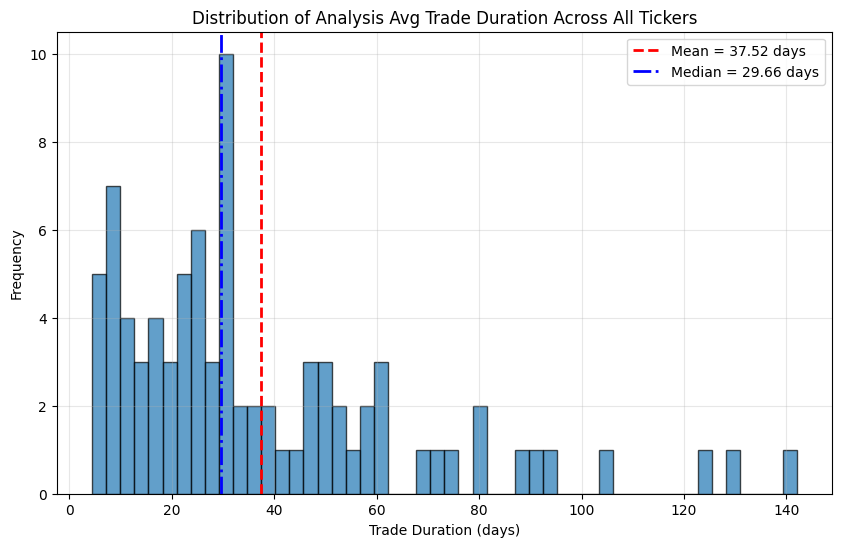

In [38]:
# Collect all analysis_avg_trade_duration values across tickers
all_durations = []
for ticker, df in final_results_dict_schwab.items():
    if "analysis_avg_trade_duration" in df.columns:
        vals = df["analysis_avg_trade_duration"].dropna().tolist()
        all_durations.extend(vals)

if all_durations:
    all_durations = np.asarray(all_durations, dtype=float)

    avg_duration = float(np.mean(all_durations))
    med_duration = float(np.median(all_durations))

    print(f"Mean analysis_avg_trade_duration across all tickers:   {avg_duration:.2f} days")
    print(f"Median analysis_avg_trade_duration across all tickers: {med_duration:.2f} days")

    # --- Visualization ---
    plt.figure(figsize=(10, 6))
    plt.hist(all_durations, bins=50, alpha=0.7, edgecolor="black")
    plt.axvline(avg_duration, color="red", linestyle="--", linewidth=2, label=f"Mean = {avg_duration:.2f} days")
    plt.axvline(med_duration, color="blue", linestyle="-.", linewidth=2, label=f"Median = {med_duration:.2f} days")

    plt.title("Distribution of Analysis Avg Trade Duration Across All Tickers")
    plt.xlabel("Trade Duration (days)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
else:
    print("No valid analysis_avg_trade_duration values found across tickers.")

### <h3 style="color:yellow;">Enriching Schwab data with scoring metrics</h3>

In [39]:
def add_price_comparison_metrics(df, last_close):
    """
    Add boolean/ratio features comparing the latest close to row thresholds.

    For each row, compares `last_close` to `analysis_buy` and `analysis_sell` and
    adds indicators for being below each bound, the percent distance to each bound,
    and whether the price lies between the bounds.

    Args:
        df (pd.DataFrame): Must include columns ['analysis_buy', 'analysis_sell'].
        last_close (float): Most recent close used for all row-wise comparisons.

    Returns:
        pd.DataFrame: Same DataFrame with added columns:
            - current_price_below_lb (bool or NaN)
            - percent_below_lb (float or NaN)
            - current_price_below_ub (bool or NaN)
            - percent_below_ub (float or NaN)
            - current_price_between_bounds (bool or NaN)
    """
    buy_valid = df["analysis_buy"].notna() & (df["analysis_buy"] != 0)
    sell_valid = df["analysis_sell"].notna() & (df["analysis_sell"] != 0)
    both_valid = buy_valid & sell_valid
    df["current_price_below_lb"] = np.where(buy_valid, last_close < df["analysis_buy"], np.nan)
    df["percent_below_lb"] = np.where(buy_valid, (df["analysis_buy"] - last_close) / df["analysis_buy"], np.nan)
    df["current_price_below_ub"] = np.where(sell_valid, last_close < df["analysis_sell"], np.nan)
    df["percent_below_ub"] = np.where(sell_valid, (df["analysis_sell"] - last_close) / df["analysis_sell"], np.nan)
    df["current_price_between_bounds"] = np.where(
        both_valid,
        (df["analysis_buy"] < last_close) & (last_close < df["analysis_sell"]),
        np.nan
    )
    return df

def add_num_days_below_bounds(df, prices):
    """
    Compute most-recent “fully below bound” streaks per row and add four columns.

    For each row’s analysis window [analysis_period_start, analysis_period_end], count
    consecutive days from the end where (high < analysis_buy and low < analysis_buy) and
    where (high < analysis_sell and low < analysis_sell). Record both the streak length
    and the timestamp where each most-recent streak began.

    Args:
        df (pd.DataFrame): Per-row thresholds and window bounds; must include
            ['analysis_buy', 'analysis_sell', 'analysis_period_start', 'analysis_period_end'].
        prices (pd.DataFrame): OHLC data with columns ['date_time', 'high', 'low'].

    Returns:
        pd.DataFrame: Same DataFrame with four added columns:
            - num_days_below_lb (int or NaN): Length of the latest lb streak.
            - num_days_below_ub (int or NaN): Length of the latest ub streak.
            - date_began_below_lb (pd.Timestamp or NaT): First day of that lb streak.
            - date_began_below_ub (pd.Timestamp or NaT): First day of that ub streak.
        (Counts are 0 when a bound is valid but no qualifying day exists; NaN/NaT when the bound is invalid.)
    """
    prices = prices.copy()
    prices["date_time"] = pd.to_datetime(prices["date_time"])

    num_days_lb_list, num_days_ub_list = [], []
    start_lb_dt_list, start_ub_dt_list = [], []

    for _, row in df.iterrows():
        lb = row["analysis_buy"]
        ub = row["analysis_sell"]
        start_dt = pd.to_datetime(row["analysis_period_start"])
        end_dt   = pd.to_datetime(row["analysis_period_end"])

        window = prices[(prices["date_time"] >= start_dt) & (prices["date_time"] <= end_dt)]
        window = window.sort_values("date_time", ascending=False)

        # ---- Lower bound (buy) streak ----
        if pd.notna(lb):
            count_lb, start_lb_dt = 0, pd.NaT
            for dt, hi, lo in zip(window["date_time"], window["high"], window["low"]):
                if hi < lb and lo < lb:
                    count_lb += 1
                    start_lb_dt = dt  # as we move back in time, this ends as the earliest date in the streak
                else:
                    break
            num_days_lb_list.append(count_lb)
            start_lb_dt_list.append(start_lb_dt)
        else:
            num_days_lb_list.append(np.nan)
            start_lb_dt_list.append(pd.NaT)

        # ---- Upper bound (sell) streak ----
        if pd.notna(ub):
            count_ub, start_ub_dt = 0, pd.NaT
            for dt, hi, lo in zip(window["date_time"], window["high"], window["low"]):
                if hi < ub and lo < ub:
                    count_ub += 1
                    start_ub_dt = dt
                else:
                    break
            num_days_ub_list.append(count_ub)
            start_ub_dt_list.append(start_ub_dt)
        else:
            num_days_ub_list.append(np.nan)
            start_ub_dt_list.append(pd.NaT)

    df["num_days_below_lb"] = num_days_lb_list
    df["num_days_below_ub"] = num_days_ub_list
    df["date_began_below_lb"] = start_lb_dt_list
    df["date_began_below_ub"] = start_ub_dt_list
    return df

def add_trend_slopes(df, prices):
    """
    Compute linear trend features over each row's analysis window and append them.

    Args:
        df (pd.DataFrame): Table of window definitions. Must contain
            'analysis_period_start' and 'analysis_period_end'. New columns
            'trend_slope' and 'norm_trend_slope' will be added.
        prices (pd.DataFrame): Historical prices with columns 'date_time' and 'close'.
            'date_time' is converted to datetime; data are filtered to each row’s window.

    Returns:
        pd.DataFrame: The same DataFrame with two added columns:
            - trend_slope (float): OLS slope of close vs. time (days) within the window
            — interpreted as price change per day; NaN if fewer than 2 rows.
            - norm_trend_slope (float): trend_slope divided by the window’s mean close
            (0 if mean close is 0; NaN if slope is NaN).
    """
    prices["date_time"] = pd.to_datetime(prices["date_time"])
    trend_slope_list = []
    norm_trend_slope_list = []

    for _, row in df.iterrows():
        start_date = pd.to_datetime(row["analysis_period_start"])
        end_date = pd.to_datetime(row["analysis_period_end"])
        analysis_period = prices[
            (prices["date_time"] >= start_date) &
            (prices["date_time"] <= end_date)
        ].sort_values("date_time", ascending=False)

        if len(analysis_period) >= 2:
            closes = analysis_period["close"].values
            x = mdates.date2num(analysis_period["date_time"])
            slope, _, _, _, _ = linregress(x, closes)
            norm_slope = slope / closes.mean() if closes.mean() != 0 else 0
            trend_slope_list.append(slope)
            norm_trend_slope_list.append(norm_slope)
        else:
            trend_slope_list.append(np.nan)
            norm_trend_slope_list.append(np.nan)

    df["trend_slope"] = trend_slope_list
    df["norm_trend_slope"] = norm_trend_slope_list
    return df

def add_slope_below_ub(df, prices):
    """
    Compute segment slopes of CLOSE after first “below-bound” dates and add them to df.

    Args:
        df (pd.DataFrame): Per-window metadata with
            'date_began_below_ub', 'date_began_below_lb', and 'analysis_period_end'.
            This DataFrame receives four new columns with segment slopes.
        prices (pd.DataFrame): Historical prices with columns 'date_time' and 'close'.
            'date_time' is coerced to datetime; the input is not modified.

    Returns:
        pd.DataFrame: A copy of `df` with four added columns, computed over
        [date_began_below_* , analysis_period_end] (inclusive). Values are NaN if the
        segment start is NaT or the segment has fewer than 2 rows.
            - slope_below_ub (float): OLS slope of close per day after below-UB start.
            - norm_slope_below_ub (float): slope_below_ub / mean close on that segment
            (0 if mean close is 0).
            - slope_below_lb (float): OLS slope of close per day after below-LB start.
            - norm_slope_below_lb (float): slope_below_lb / mean close on that segment
            (0 if mean close is 0).
    """
    prices_view = prices[["date_time", "close"]].sort_values("date_time").copy()
    prices_view["date_time_numeric_days"] = mdates.date2num(prices_view["date_time"])

    window_bounds = df[["date_began_below_ub", "analysis_period_end"]].copy()
    regression_slopes_after_began_below_ub = np.full(len(window_bounds), np.nan, dtype=float)
    regression_norm_slopes_after_began_below_ub = np.full(len(window_bounds), np.nan, dtype=float)

    window_bounds_lb = df[["date_began_below_lb", "analysis_period_end"]].copy()
    regression_slopes_after_began_below_lb = np.full(len(window_bounds_lb), np.nan, dtype=float)
    regression_norm_slopes_after_began_below_lb = np.full(len(window_bounds_lb), np.nan, dtype=float)

    for i, (start_dt, end_dt) in enumerate(
        window_bounds[["date_began_below_ub", "analysis_period_end"]].itertuples(index=False, name=None)
    ):
        if pd.isna(start_dt) or pd.isna(end_dt):
            continue
        window = prices_view[
            (prices_view["date_time"] >= start_dt) & (prices_view["date_time"] <= end_dt)
        ][["date_time_numeric_days", "close"]]
        if len(window) < 2:
            continue

        res = linregress(window["date_time_numeric_days"], window["close"])
        slope = res.slope
        mean_close = window["close"].mean()

        regression_slopes_after_began_below_ub[i] = slope
        regression_norm_slopes_after_began_below_ub[i] = (slope / mean_close) if mean_close != 0 else 0

    for i, (start_dt, end_dt) in enumerate(
        window_bounds_lb[["date_began_below_lb", "analysis_period_end"]].itertuples(index=False, name=None)
    ):
        if pd.isna(start_dt) or pd.isna(end_dt):
            continue
        window = prices_view[
            (prices_view["date_time"] >= start_dt) & (prices_view["date_time"] <= end_dt)
        ][["date_time_numeric_days", "close"]]
        if len(window) < 2:
            continue

        res = linregress(window["date_time_numeric_days"], window["close"])
        slope = res.slope
        mean_close = window["close"].mean()

        regression_slopes_after_began_below_lb[i] = slope
        regression_norm_slopes_after_began_below_lb[i] = (slope / mean_close) if mean_close != 0 else 0

    df = df.copy()
    df["slope_below_ub"] = regression_slopes_after_began_below_ub
    df["norm_slope_below_ub"] = regression_norm_slopes_after_began_below_ub
    df["slope_below_lb"] = regression_slopes_after_began_below_lb
    df["norm_slope_below_lb"] = regression_norm_slopes_after_began_below_lb

    return df

def add_cyclicality(df, prices):
    """
    Computes a simple cyclicality ratio from historical highs/lows and stamps it onto `df`.

    This metric summarizes how “choppy” the series is by comparing the average
    intraday range to the full price span observed in `prices`:
        cyclicality = mean(high - low) / (max(high) - min(low))

    Notes:
        - The ratio is computed once over the entire `prices` table (not per row/window)
        and the same scalar value is assigned to every row of `df`.
        - If the full span (max(high) - min(low)) is 0, the result is NaN to avoid
        division by zero.
        - `prices["date_time"]` is coerced to datetime; `prices` is otherwise unchanged.

    Args:
        df (pd.DataFrame): Target table to receive the 'cyclicality' column.
        prices (pd.DataFrame): Historical OHLC with columns
            ['date_time', 'high', 'low'].

    Returns:
        pd.DataFrame: `df` with a new scalar column:
            - cyclicality (float): mean daily range divided by full series span.
    """
    prices["date_time"] = pd.to_datetime(prices["date_time"])
    full_prices = prices.set_index("date_time")
    full_span = full_prices["high"].max() - full_prices["low"].min()
    avg_day_range = (full_prices["high"] - full_prices["low"]).mean()
    cyclicality_ratio = avg_day_range / full_span if full_span != 0 else np.nan
    df["cyclicality"] = cyclicality_ratio
    return df

Call `add_price_comparison_metrics`, `add_num_days_below_bounds`, `add_trend_slopes`, `add_slope_below_ub`, and `add_cyclicality` to enrich the ticker DataFrames in `final_results_dict_schwab` with the analysis metrics that are to be used to categorize tickers by probability of swing trade profitability.

In [40]:
for ticker, df in final_results_dict_schwab.items():
    prices = candles_dict_schwab[ticker]
    last_close = prices["close"].iloc[-1]
    df = add_price_comparison_metrics(df, last_close)
    df = add_num_days_below_bounds(df, prices)
    df = add_trend_slopes(df, prices)
    df = add_slope_below_ub(df, prices)
    df = add_cyclicality(df, prices)
    final_results_dict_schwab[ticker] = df

In [41]:
# Convert dict items to a list to enable index-based access
final_results_list_schwab = list(final_results_dict_schwab.items())

# Pick a random index and show its ticker (and DataFrame)
idx = random.randrange(len(final_results_list_schwab))
ticker, df = final_results_list_schwab[idx]
print(f"Ticker: {ticker}")
display(df)
display(final_results_dict_schwab)

# "analysis_buy" "analysis_period_start" "analysis_period_end" "date_time" "close"

Ticker: EA


,ticker,analysis_period_start,analysis_period_end,evaluation_period_start,evaluation_period_end,incubation_period_start,incubation_period_end,analysis_buy,analysis_sell,analysis_return,analysis_trades,analysis_eval_metric,evaluation_return,evaluation_trades,evaluation_data_good,incubation_return,incubation_trades,incubation_data_good,analysis_avg_trade_duration,current_price_below_lb,percent_below_lb,current_price_below_ub,percent_below_ub,current_price_between_bounds,num_days_below_lb,num_days_below_ub,date_began_below_lb,date_began_below_ub,trend_slope,norm_trend_slope,slope_below_ub,norm_slope_below_ub,slope_below_lb,norm_slope_below_lb,cyclicality
0,EA,2023-08-31,2025-08-29,2025-08-30,2025-08-30,2025-08-31,2025-08-31,144.8721,147.1995,0.1183,14,0.0709,0.0000,0,False,0.0000,0,False,35.2143,0.0000,-0.1869,0.0000,-0.1681,0.0000,0,0,NaT,NaT,0.0382,0.0003,NaN,NaN,NaN,NaN,0.0389


{'AAPL':   ticker analysis_period_start analysis_period_end evaluation_period_start evaluation_period_end incubation_period_start incubation_period_end  analysis_buy  analysis_sell  analysis_return  analysis_trades  analysis_eval_metric  evaluation_return  evaluation_trades  evaluation_data_good  incubation_return  incubation_trades  incubation_data_good  analysis_avg_trade_duration  current_price_below_lb  percent_below_lb  current_price_below_ub  percent_below_ub  current_price_between_bounds  num_days_below_lb  num_days_below_ub date_began_below_lb date_began_below_ub  trend_slope  norm_trend_slope  slope_below_ub  norm_slope_below_ub  slope_below_lb  norm_slope_below_lb  cyclicality
 0   AAPL            2023-08-31          2025-08-29              2025-08-30            2025-08-30              2025-08-31            2025-08-31      196.9026       212.7905           0.2627                6                0.1018             0.0000                  0                 False             0.0

### <h3 style="color:yellow;">Enriching Schwab data with AI suggested scoring metrics</h3>

In [42]:
def add_high_weight_metrics(df, prices, short_win=20, long_win=60):
    """
    add high-importance predictive metrics over each row's analysis window.

    metrics per row (over [analysis_period_start, analysis_period_end]):
        - analysis_period_pct_change: close_end / close_start - 1
        - compression_ratio: std(close_last_short_win) / std(close_last_long_win)
        - trend_persistence: share of up closes in last short_win bars
        - range_shrink: mean(range_last_short_win) / mean(range_last_long_win)
        - compression_in_trend: trend_persistence * sign(norm_trend_slope) / compression_ratio

    args:
        df (pd.DataFrame): per-window rows with 'analysis_period_start',
            'analysis_period_end', and 'norm_trend_slope'.
        prices (pd.DataFrame): ohlc with ['date_time','open','high','low','close'].

    returns:
        pd.DataFrame: same df with added columns:
            ['analysis_period_pct_change','compression_ratio',
             'trend_persistence','range_shrink','compression_in_trend'].
    """
    prices = prices.copy()
    # prices["date_time"] = pd.to_datetime(prices["date_time"])
    # prices = prices.sort_values("date_time")

    rets, comp, tp, rng_shrink, comp_trend = [], [], [], [], []

    for _, row in df.iterrows():
        # start = pd.to_datetime(row["analysis_period_start"])
        # end   = pd.to_datetime(row["analysis_period_end"])
        win = prices[(prices["date_time"] >= row["analysis_period_start"]) & (prices["date_time"] <= row["analysis_period_end"])].copy()

        if len(win) < 3:
            rets.append(np.nan); comp.append(np.nan); tp.append(np.nan)
            rng_shrink.append(np.nan); comp_trend.append(np.nan)
            continue

        win = win.sort_values("date_time")
        closes = win["close"].to_numpy()
        highs  = win["high"].to_numpy()
        lows   = win["low"].to_numpy()

        # analysis-period return
        ret = closes[-1] / closes[0] - 1.0
        rets.append(ret)

        # windows
        sw = min(short_win, len(win))
        lw = min(long_win, len(win))
        c_short = closes[-sw:]
        c_long  = closes[-lw:]
        r = highs - lows
        r_short = r[-sw:]
        r_long  = r[-lw:]

        # compression ratio (vol)
        std_short = c_short.std(ddof=0)
        std_long  = c_long.std(ddof=0)
        cr = std_short / std_long if std_long > 0 else np.nan
        comp.append(cr)

        # trend persistence (up-close fraction)
        diffs = np.diff(closes[-(sw+1):]) if len(closes) > sw else np.diff(closes)
        tp_val = (diffs > 0).sum() / diffs.size if diffs.size else np.nan
        tp.append(tp_val)

        # range shrink
        m_short = r_short.mean() if len(r_short) else np.nan
        m_long  = r_long.mean()  if len(r_long)  else np.nan
        rs = m_short / m_long if m_long and m_long > 0 else np.nan
        rng_shrink.append(rs)

        # compression-in-trend
        nts = row.get("norm_trend_slope", np.nan)
        sgn = np.sign(nts) if pd.notna(nts) else 0.0
        cit = tp_val * sgn / cr if (cr and cr > 0 and pd.notna(tp_val)) else np.nan
        comp_trend.append(cit)

    df["analysis_period_pct_change"] = rets
    df["compression_ratio"] = comp
    df["trend_persistence"] = tp
    df["range_shrink"] = rng_shrink
    df["compression_in_trend"] = comp_trend
    return df

def add_relative_strength_metrics(final_results_dict):
    """
    Compute cross-sectional Relative Strength (RS) vs. median pct_change for each
    analysis_period_end, plus its Z-score normalization, and stamp both metrics
    back onto each ticker’s results DataFrame.

    Relative Strength:
        rs_vs_median = analysis_period_pct_change - median(analysis_period_pct_change)

    Z-score normalized RS:
        rs_z = (rs_vs_median - mean(rs_vs_median)) / std(rs_vs_median)

    Args:
        final_results_dict (dict[str, pd.DataFrame]):
            Mapping ticker → results DataFrame. Each DataFrame must contain:
                - 'analysis_period_end'
                - 'analysis_period_pct_change'

    Returns:
        dict[str, pd.DataFrame]:
            Same mapping, where each DataFrame now has:
                - 'rs_vs_median'
                - 'rs_z'
    """
    # Concatenate into one cross-sectional table
    combined = pd.concat(final_results_dict.values(), ignore_index=True)

    # Group by analysis window (cross-sectional RS)
    grouped = combined.groupby("analysis_period_end", dropna=False)
    combined["rs_vs_median"] = grouped["analysis_period_pct_change"].transform(
        lambda s: s - s.median()
    )

    # Z-score normalization of RS *within each analysis period*
    combined["rs_z"] = grouped["rs_vs_median"].transform(
        lambda s: (s - s.mean()) / (s.std(ddof=0) if s.std(ddof=0) != 0 else np.nan)
    )

    # Push values back into each ticker's DataFrame
    row = 0
    for ticker, df in final_results_dict.items():
        n = len(df)
        sub = combined.iloc[row:row+n]
        df["rs_vs_median"] = sub["rs_vs_median"].values
        df["rs_z"] = sub["rs_z"].values
        final_results_dict[ticker] = df
        row += n

    return final_results_dict

In [43]:
for ticker, df in final_results_dict_schwab.items():
    prices = candles_dict_schwab[ticker]
    last_close = prices["close"].iloc[-1]
    df = add_high_weight_metrics(df, prices)
    final_results_dict_schwab[ticker] = df

In [44]:
final_results_dict_schwab = add_relative_strength_metrics(final_results_dict_schwab)

In [45]:
# Convert dict items to a list to enable index-based access
final_results_list_schwab = list(final_results_dict_schwab.items())

# Pick a random index and show its ticker (and DataFrame)
idx = random.randrange(len(final_results_list_schwab))
ticker, df = final_results_list_schwab[idx]
print(f"Ticker: {ticker}")
display(df)
display(final_results_dict_schwab)

Ticker: RMBS


,ticker,analysis_period_start,analysis_period_end,evaluation_period_start,evaluation_period_end,incubation_period_start,incubation_period_end,analysis_buy,analysis_sell,analysis_return,analysis_trades,analysis_eval_metric,evaluation_return,evaluation_trades,evaluation_data_good,incubation_return,incubation_trades,incubation_data_good,analysis_avg_trade_duration,current_price_below_lb,percent_below_lb,current_price_below_ub,percent_below_ub,current_price_between_bounds,num_days_below_lb,num_days_below_ub,date_began_below_lb,date_began_below_ub,trend_slope,norm_trend_slope,slope_below_ub,norm_slope_below_ub,slope_below_lb,norm_slope_below_lb,cyclicality,analysis_period_pct_change,compression_ratio,trend_persistence,range_shrink,compression_in_trend,rs_vs_median,rs_z
0,RMBS,2023-08-31,2025-08-29,2025-08-30,2025-08-30,2025-08-31,2025-08-31,54.5980,58.3342,0.6445,15,0.3949,0.0000,0,False,0.0000,0,False,22.1333,0.0000,-0.3511,0.0000,-0.2646,0.0000,0,0,NaT,NaT,-0.0012,-0.0000,NaN,NaN,NaN,NaN,0.0506,0.3064,0.4362,0.5500,1.2853,-1.2609,0.2507,-0.1529


{'AAPL':   ticker analysis_period_start analysis_period_end evaluation_period_start evaluation_period_end incubation_period_start incubation_period_end  analysis_buy  analysis_sell  analysis_return  analysis_trades  analysis_eval_metric  evaluation_return  evaluation_trades  evaluation_data_good  incubation_return  incubation_trades  incubation_data_good  analysis_avg_trade_duration  current_price_below_lb  percent_below_lb  current_price_below_ub  percent_below_ub  current_price_between_bounds  num_days_below_lb  num_days_below_ub date_began_below_lb date_began_below_ub  trend_slope  norm_trend_slope  slope_below_ub  norm_slope_below_ub  slope_below_lb  norm_slope_below_lb  cyclicality  analysis_period_pct_change  compression_ratio  trend_persistence  range_shrink  compression_in_trend  rs_vs_median    rs_z
 0   AAPL            2023-08-31          2025-08-29              2025-08-30            2025-08-30              2025-08-31            2025-08-31      196.9026       212.7905        

In [46]:
# Compression Ratio	Pre-breakout contraction	High
# Trend Persistence	Directional stability	High
# Relative Strength	Persistent across 2–12 weeks	Very High
# Compression-in-Trend	Explosive continuation pattern	High
# Range Shrink	Volatility bottleneck	High

### <h3 style="color:yellow;">Enriching Schwab data with annualization metrics</h3>

In [47]:
def calculate_implied_gain_pct(df):
    """
    Compute the implied gain percentage from analysis thresholds.

    Args:
        df (pd.DataFrame): Table with columns ['analysis_buy', 'analysis_sell'].
            'analysis_buy' must be > 0 to form a valid ratio; nonpositive or
            missing buy/sell values will yield NaN.

    Returns:
        pd.DataFrame: A copy of `df` with one added column:
            - implied_gain_pct (float): (analysis_sell / analysis_buy) - 1.0,
            NaN when inputs are invalid.
    """
    df = df.copy()
    valid = (df["analysis_buy"].notna()) & (df["analysis_sell"].notna()) & (df["analysis_buy"] > 0)
    df["implied_gain_pct"] = np.where(valid, (df["analysis_sell"] / df["analysis_buy"]) - 1.0, np.nan)
    return df

def max_days_for_target_return_simple(df, target_annual_return=1.0, basis=365.25):
    """
    Estimate the maximum days to reach a target annual return from the implied gain.

    Args:
        df (pd.DataFrame): Must include 'implied_gain_pct' (float). Values ≤ 0 or NaN
            are treated as invalid and produce NaN outputs.
        target_annual_return (float, optional): Desired annualized return (as a decimal),
            used in max_days = basis * implied_gain_pct / target_annual_return.
            Must be > 0. Default is 1.0 (i.e., 100% annual).
        basis (float, optional): Day-count basis used to convert an annual target to days.
            Default 365.25.

    Returns:
        pd.DataFrame: A copy of `df` with one added column:
            - max_days_simple (float): Estimated days to target; NaN when inputs are invalid.
    """
    df = df.copy()
    gains = np.asarray(df["implied_gain_pct"], dtype=float)
    target = float(target_annual_return)
    with np.errstate(divide="ignore", invalid="ignore"):
        max_days = basis * gains / target
    invalid = (target <= 0) | (gains <= 0) | ~np.isfinite(max_days)
    df["max_days_simple"] = np.where(invalid, np.nan, max_days)
    return df

def calculate_exit_by_date_simple(df, entry_date=None, max_exit_horizon_days=70000):
    """
    Compute a simple exit-by date from the estimated days-to-target.

    Args:
        df (pd.DataFrame): Must include 'max_days_simple' (float). Non-positive,
            non-finite, or NaN values produce NaT in the output.
        entry_date (datetime-like or None, optional): Starting date for the estimate.
            If None, uses today at 00:00 (local) after normalization.
        max_exit_horizon_days (int, optional): Maximum allowed days; values above
            this cap are treated as invalid (NaT). Default 70000.

    Returns:
        pd.DataFrame: A copy of `df` with one added column:
            - exit_by_date_simple (Timestamp or NaT): entry_date + ceil(max_days_simple),
            capped by `max_exit_horizon_days`.
    """
    df = df.copy()
    entry_dt = pd.Timestamp.today().normalize() if entry_date is None else pd.to_datetime(entry_date).normalize() #<--chosen_end_date #MARKER#
    days = pd.to_numeric(np.ceil(df["max_days_simple"]), errors="coerce")
    valid_days = days.where((days > 0) & np.isfinite(days) & (days <= max_exit_horizon_days))
    time_delta = pd.to_timedelta(valid_days, unit="D", errors="coerce")
    df["exit_by_date_simple"] = (entry_dt + time_delta).astype("datetime64[ns]")
    return df

def annualized_simple_return(df, basis=365.25):
    """
    Compute a simple annualized return from implied gain and average trade duration.

    Args:
        df (pd.DataFrame): Input table that must include:
            - 'implied_gain_pct' (float): Expected simple gain per round-trip,
            e.g., (sell/buy) - 1. Non-positive or NaN values yield NaN output.
            - 'analysis_avg_trade_duration' (float): Average trade length in days.
            Non-positive or NaN values yield NaN output.
        basis (float, optional): Days per year used for annualization. Defaults to 365.25.

    Returns:
        pd.DataFrame: A copy of `df` with one added column:
            - 'annual_simple_from_avg_duration' (float): Annualized return computed as
            implied_gain_pct * (basis / analysis_avg_trade_duration); NaN where inputs
            are invalid or non-finite.
    """
    df = df.copy()
    gains = np.asarray(df["implied_gain_pct"], dtype=float)
    days = np.asarray(df.get("analysis_avg_trade_duration", np.nan), dtype=float)
    with np.errstate(divide="ignore", invalid="ignore"):
        annualized = gains * (basis / days)
    invalid = (gains <= 0) | (days <= 0) | ~np.isfinite(annualized)
    df["annual_simple_from_avg_duration"] = np.where(invalid, np.nan, annualized)
    return df

Call `calculate_implied_gain_pct`, `max_days_for_target_return_simple`, `calculate_exit_by_date_simple`, and `annualized_simple_return` on each ticker's DataFrame in `final_results_dict_schwab` to enrich them with annualization metrics.

In [48]:
# For loop to apply functions to all DataFrames in final_results_dict_schwab
for ticker, df in final_results_dict_schwab.items():
    df = calculate_implied_gain_pct(df)
    df = max_days_for_target_return_simple(df)
    df = calculate_exit_by_date_simple(df, entry_date=chosen_end_date)
    df = annualized_simple_return(df)
    final_results_dict_schwab[ticker] = df

display(candles_df['date_time'].max().strftime('%Y-%m-%d'))
display(chosen_end_date)

'2025-08-29'

'2025-08-29'

In [49]:
# Convert dict items to a list to enable index-based access
final_results_list_schwab = list(final_results_dict_schwab.items())

# Pick a random index and show its ticker (and DataFrame)
idx = random.randrange(len(final_results_list_schwab))
ticker, df = final_results_list_schwab[idx]
print(f"Ticker: {ticker}")
display(df)
display(final_results_dict_schwab)

Ticker: GLMD


,ticker,analysis_period_start,analysis_period_end,evaluation_period_start,evaluation_period_end,incubation_period_start,incubation_period_end,analysis_buy,analysis_sell,analysis_return,analysis_trades,analysis_eval_metric,evaluation_return,evaluation_trades,evaluation_data_good,incubation_return,incubation_trades,incubation_data_good,analysis_avg_trade_duration,current_price_below_lb,percent_below_lb,current_price_below_ub,percent_below_ub,current_price_between_bounds,num_days_below_lb,num_days_below_ub,date_began_below_lb,date_began_below_ub,trend_slope,norm_trend_slope,slope_below_ub,norm_slope_below_ub,slope_below_lb,norm_slope_below_lb,cyclicality,analysis_period_pct_change,compression_ratio,trend_persistence,range_shrink,compression_in_trend,rs_vs_median,rs_z,implied_gain_pct,max_days_simple,exit_by_date_simple,annual_simple_from_avg_duration
0,GLMD,2023-08-31,2025-08-29,2025-08-30,2025-08-30,2025-08-31,2025-08-31,1.3763,1.5300,0.4914,9,0.2457,0.0000,0,False,0.0000,0,False,7.2222,1.0000,0.0772,1.0000,0.1699,0.0000,1,4,2025-08-29,2025-08-26,-0.0067,-0.0018,-0.0370,-0.0273,NaN,NaN,0.0190,-0.8693,0.3263,0.4000,0.8282,-1.2259,-0.9250,-0.4800,0.1117,40.7975,2025-10-09,5.6489


{'AAPL':   ticker analysis_period_start analysis_period_end evaluation_period_start evaluation_period_end incubation_period_start incubation_period_end  analysis_buy  analysis_sell  analysis_return  analysis_trades  analysis_eval_metric  evaluation_return  evaluation_trades  evaluation_data_good  incubation_return  incubation_trades  incubation_data_good  analysis_avg_trade_duration  current_price_below_lb  percent_below_lb  current_price_below_ub  percent_below_ub  current_price_between_bounds  num_days_below_lb  num_days_below_ub date_began_below_lb date_began_below_ub  trend_slope  norm_trend_slope  slope_below_ub  norm_slope_below_ub  slope_below_lb  norm_slope_below_lb  cyclicality  analysis_period_pct_change  compression_ratio  trend_persistence  range_shrink  compression_in_trend  rs_vs_median    rs_z  implied_gain_pct  max_days_simple exit_by_date_simple  annual_simple_from_avg_duration
 0   AAPL            2023-08-31          2025-08-29              2025-08-30            2025-

### <h3 style="color:yellow;">Enriching Schwab data with profit probability scoring metrics</h3>

In [50]:
def add_profit_score(combined_df, weights, bound_reference):
    """
    Compute a weighted profit score from percentile-ranked features.

    Args:
        combined_df (pd.DataFrame): Input table that will be modified in place. Must
            include the following columns (where suffix depends on `bound_reference`):
            - f"current_price_below_{suffix}" (bool/float): Indicator mask.
            - f"percent_below_{suffix}" (float): Distance below the bound.
            - f"num_days_below_{suffix}" (float/int): Recent streak length.
            - "cyclicality" (float): Series cyclicality metric.
            - "norm_trend_slope" (float): Normalized trend slope over analysis window.
            - f"norm_slope_below_{suffix}" (float): Normalized slope from first full-below day.
            The function also creates temporary percentile-rank columns:
            ["_rank_percent", "_rank_days", "_rank_cyclicality", "_rank_trend", "_rank_norm_below"].
            NaNs in these temporary rank columns are filled with 0.0.
        weights (dict): Component weights used in the weighted sum. Expected keys:
            f"current_price_below_{suffix}",
            f"percent_below_{suffix}",
            f"num_days_below_{suffix}",
            "cyclicality",
            "norm_trend_slope",
            f"norm_slope_below_{suffix}".
            Missing keys default to weight 0.
        bound_reference (str): Which bound to score against; "lower" → suffix "lb",
            "upper" → suffix "ub".

    Returns:
        pd.DataFrame: The same `combined_df` with one new column:
            - "profit_score" (float): current-price-below mask multiplied by the
            weighted sum of the percentile-ranked components. Temporary rank
            columns remain for optional cleanup by the caller.
    """
    if bound_reference not in {"lower", "upper"}:
        raise ValueError("bound_reference must be either 'lower' or 'upper'")
    
    suffix = "lb" if bound_reference == "lower" else "ub"
    combined_df[f"current_price_below_{suffix}"] = combined_df[f"current_price_below_{suffix}"].astype(float)
    
    # Temporary ranking columns
    combined_df["_rank_percent"] = combined_df[f"percent_below_{suffix}"].rank(pct=True)
    combined_df["_rank_days"] = combined_df[f"num_days_below_{suffix}"].rank(pct=True)
    combined_df["_rank_cyclicality"] = combined_df["cyclicality"].rank(pct=True)
    combined_df["_rank_trend"] = combined_df["norm_trend_slope"].rank(pct=True)
    combined_df["_rank_norm_below"] = combined_df[f"norm_slope_below_{suffix}"].rank(pct=True)

    # Make sure NaNs don’t poison the sum
    rank_cols = ["_rank_percent", "_rank_days", "_rank_cyclicality", "_rank_trend", "_rank_norm_below"]
    combined_df[rank_cols] = combined_df[rank_cols].fillna(0.0)
    current_mask = combined_df[f"current_price_below_{suffix}"].fillna(0).astype(float)
    
    # Calculate profit score
    current_mask = combined_df[f"current_price_below_{suffix}"]
    combined_df["profit_score"] = current_mask * (
        # weights.get(f"current_price_below_{suffix}", 0) +
        combined_df["_rank_percent"] * weights.get(f"percent_below_{suffix}", 0) +
        combined_df["_rank_days"] * weights.get(f"num_days_below_{suffix}", 0) +
        combined_df["_rank_cyclicality"] * weights.get("cyclicality", 0) +
        combined_df["_rank_trend"] * weights.get("norm_trend_slope", 0) +
        combined_df["_rank_norm_below"] * weights.get(f"norm_slope_below_{suffix}", 0)
    )
    return combined_df

def add_profit_rank(combined_df):
    """
    Rank rows by profit score (best = 1).

    Args:
        combined_df (pd.DataFrame): DataFrame containing a numeric 'profit_score'
            column. NaNs in 'profit_score' are kept and will yield NaN ranks.

    Returns:
        pd.DataFrame: The same DataFrame with one added column:
            - 'profit_rank' (float): Descending rank of 'profit_score'
            (1.0 = highest score). Ties receive average ranks; NaN scores
            produce NaN ranks.
    """
    combined_df["profit_rank"] = combined_df["profit_score"].rank(ascending=False)
    return combined_df

def add_swing_probability(combined_df):
    """
    Categorize swing probability from 'profit_score' percentiles.

    Ranks only rows with profit_score > 0 by percentile and maps them to:
    very_low (≤20%), low (≤40%), medium (≤60%), high (≤80%), very_high (>80%).
    Rows with profit_score == 0 are labeled 'zero'. Rows with NaN or negative
    scores remain NaN.

    Args:
        combined_df (pd.DataFrame): Must contain a numeric 'profit_score' column.

    Returns:
        pd.DataFrame: Same DataFrame with a new 'swing_probability' (object) column
        containing {'very_low','low','medium','high','very_high','zero'} or NaN.
    """
    swing_probs = pd.Series(index=combined_df.index, dtype="object")
    nonzero_scores = combined_df[combined_df["profit_score"] > 0]
    percentiles = nonzero_scores["profit_score"].rank(pct=True)
    
    for idx, p in percentiles.items():
        if p <= 0.2:
            swing_probs[idx] = "very_low"
        elif p <= 0.4:
            swing_probs[idx] = "low"
        elif p <= 0.6:
            swing_probs[idx] = "medium"
        elif p <= 0.8:
            swing_probs[idx] = "high"
        else:
            swing_probs[idx] = "very_high"
    
    swing_probs[combined_df["profit_score"] == 0] = "zero"
    combined_df["swing_probability"] = swing_probs
    return combined_df

def add_weight_columns(df, weights):
    """
    Attach per-metric weight columns to a DataFrame.

    For each entry in `weights` (key → value), creates/overwrites a column
    named f"{key}_weight" filled with the scalar value for all rows.

    Args:
        df (pd.DataFrame): Target table to receive weight columns (modified in place).
        weights (dict[str, float]): Mapping from metric names (without the "_weight"
            suffix) to their scalar weights.

    Returns:
        pd.DataFrame: The same DataFrame with added/updated f"{key}_weight" columns.
    """
    for key, val in weights.items():
        df[key + "_weight"] = val
    return df

Creates a `combined_df` of all tickers for scoring, ranking, and categorization purposes, distributes those values back to `final_results_dict_schwab`, then adds weight columns to each ticker's DataFrame for reference.

In [51]:
# For loop to apply functions to all DataFrames in final_results_dict_schwab
bound_reference_schwab = "upper"  # Choose either "lower" or "upper" bound for scoring                                   #PARAMETER#

In [52]:
# Manual weights
weights = {                                                                                                             #PARAMETER#
    f"current_price_below_{'lb' if bound_reference_schwab == 'lower' else 'ub'}": 1.0,
    f"percent_below_{'lb' if bound_reference_schwab == 'lower' else 'ub'}": 0.25,
    f"num_days_below_{'lb' if bound_reference_schwab == 'lower' else 'ub'}": 0.0,
    "cyclicality": 0.75,
    "norm_trend_slope": 1.75,
    f"norm_slope_below_{'lb' if bound_reference_schwab == 'lower' else 'ub'}": 0.25
}

In [53]:
# # XGBoost Weights
# percent_below_ub  :  -0.20914225231874242
# num_days_below_ub  :  -0.002869473694595436
# cyclicality  :  2.3308127655720123
# norm_trend_slope  :  3.5094822881461543
# norm_slope_below_ub  :  2.088665808249974

# percent_below_ub  :  -0.20654054977786282
# num_days_below_ub  :  -0.0025866111745405903
# cyclicality  :  2.2871838975457424
# norm_trend_slope  :  3.745013338519993
# norm_slope_below_ub  :  2.105614649178072

# XGBoost Weights
weights = {                                                                                                             #PARAMETER#
    f"current_price_below_{'lb' if bound_reference_schwab == 'lower' else 'ub'}": 1.0,
    f"percent_below_{'lb' if bound_reference_schwab == 'lower' else 'ub'}": -0.21,
    f"num_days_below_{'lb' if bound_reference_schwab == 'lower' else 'ub'}": 0.0,
    "cyclicality": 2.29,
    "norm_trend_slope": 3.75,
    f"norm_slope_below_{'lb' if bound_reference_schwab == 'lower' else 'ub'}": 2.1
}

In [54]:
# === BEST SPEARMAN ===
# Corr: 0.2750050246198559
# percent_below_ub: -1.464833
# num_days_below_ub: 0.509937
# cyclicality: 1.698058
# norm_trend_slope: 0.490085
# norm_slope_below_ub: 0.435297

# === BEST PEARSON ===
# Corr: 0.12494285064317927
# percent_below_ub: -0.650536
# num_days_below_ub: -3.275984
# cyclicality: 6.648438
# norm_trend_slope: 3.000773
# norm_slope_below_ub: 1.579457

# Gradient-Free Optimizer (Powell / Nelder-Mead) Weights
weights = {                                                                                                             #PARAMETER#
    f"current_price_below_{'lb' if bound_reference_schwab == 'lower' else 'ub'}": 1.0,
    f"percent_below_{'lb' if bound_reference_schwab == 'lower' else 'ub'}": 0,
    f"num_days_below_{'lb' if bound_reference_schwab == 'lower' else 'ub'}": 0.34,
    "cyclicality": 1.1,
    "norm_trend_slope": 1.29,
    f"norm_slope_below_{'lb' if bound_reference_schwab == 'lower' else 'ub'}": 0.86
}

In [55]:
# Grid Search Weights
# Ranked before applying pearson:
# best spearman: 0.26539894518239293
# spearman weights: {'percent_below_ub': 0.0, 'num_days_below_ub': 0.0, 'cyclicality': 1.8, 'norm_trend_slope': 1.0, 'norm_slope_below_ub': 0.8} 

# Standard correlation coefficient
# best pearson: 0.14922707118815137
# pearson weights: {'percent_below_ub': 0.0, 'num_days_below_ub': 0.0, 'cyclicality': 1.6, 'norm_trend_slope': 1.4000000000000001, 'norm_slope_below_ub': 0.8}

# Grid Search Weights
weights = {                                                                                                             #PARAMETER#
    f"current_price_below_{'lb' if bound_reference_schwab == 'lower' else 'ub'}": 1.0,
    f"percent_below_{'lb' if bound_reference_schwab == 'lower' else 'ub'}": 0.0,
    f"num_days_below_{'lb' if bound_reference_schwab == 'lower' else 'ub'}": 0.0,
    "cyclicality": 1,
    "norm_trend_slope": 0,
    f"norm_slope_below_{'lb' if bound_reference_schwab == 'lower' else 'ub'}": 1.4
}

In [56]:
# Concatenate all DataFrames for ranking
combined_df = pd.concat(final_results_dict_schwab.values(), ignore_index=True)

# Apply scoring functions to combined_df
combined_df = add_profit_score(combined_df, weights, bound_reference_schwab)
combined_df = add_profit_rank(combined_df)
combined_df = add_swing_probability(combined_df)

# Clean up temporary ranking columns
combined_df.drop(columns=["_rank_percent", "_rank_days", "_rank_cyclicality", "_rank_trend", "_rank_norm_below"], inplace=True)

# Distribute results back to final_results_dict_schwab
row_counter = 0
for ticker, df in final_results_dict_schwab.items():
    num_rows = len(df)
    updated_chunk = combined_df.iloc[row_counter:row_counter + num_rows]
    
    # Assign core results
    df["profit_score"] = updated_chunk["profit_score"].values
    df["profit_rank"] = updated_chunk["profit_rank"].values
    df["swing_probability"] = updated_chunk["swing_probability"].values
    
    # Add weight columns
    df = add_weight_columns(df, weights)
    
    final_results_dict_schwab[ticker] = df
    row_counter += num_rows

In [57]:
# Convert dict items to a list to enable index-based access
final_results_list_schwab = list(final_results_dict_schwab.items())

# Pick a random index and show its ticker (and DataFrame)
idx = random.randrange(len(final_results_list_schwab))
ticker, df = final_results_list_schwab[idx]
print(f"Ticker: {ticker}")
display(candles_df['date_time'].max().strftime('%Y-%m-%d'))
display(chosen_end_date)
display(df)
display(final_results_dict_schwab)

Ticker: BZAI


'2025-08-29'

'2025-08-29'

,ticker,analysis_period_start,analysis_period_end,evaluation_period_start,evaluation_period_end,incubation_period_start,incubation_period_end,analysis_buy,analysis_sell,analysis_return,analysis_trades,analysis_eval_metric,evaluation_return,evaluation_trades,evaluation_data_good,incubation_return,incubation_trades,incubation_data_good,analysis_avg_trade_duration,current_price_below_lb,percent_below_lb,current_price_below_ub,percent_below_ub,current_price_between_bounds,num_days_below_lb,num_days_below_ub,date_began_below_lb,date_began_below_ub,trend_slope,norm_trend_slope,slope_below_ub,norm_slope_below_ub,slope_below_lb,norm_slope_below_lb,cyclicality,analysis_period_pct_change,compression_ratio,trend_persistence,range_shrink,compression_in_trend,rs_vs_median,rs_z,implied_gain_pct,max_days_simple,exit_by_date_simple,annual_simple_from_avg_duration,profit_score,profit_rank,swing_probability,current_price_below_ub_weight,percent_below_ub_weight,num_days_below_ub_weight,cyclicality_weight,norm_trend_slope_weight,norm_slope_below_ub_weight
0,BZAI,2023-08-31,2025-08-29,2025-08-30,2025-08-30,2025-08-31,2025-08-31,2.4365,2.6660,0.5005,9,0.2524,0.0000,0,False,0.0000,0,False,7.3333,0.0000,-0.4652,0.0000,-0.3391,0.0000,0,0,NaT,NaT,-0.0145,-0.0018,NaN,NaN,NaN,NaN,0.0149,-0.6594,0.2917,0.4500,0.9179,-1.5425,-0.7150,-0.4216,0.0942,34.3963,2025-10-03,4.6904,0.0000,56.0000,zero,1.0000,0.0000,0.0000,1,0,1.4000


{'AAPL':   ticker analysis_period_start analysis_period_end evaluation_period_start evaluation_period_end incubation_period_start incubation_period_end  analysis_buy  analysis_sell  analysis_return  analysis_trades  analysis_eval_metric  evaluation_return  evaluation_trades  evaluation_data_good  incubation_return  incubation_trades  incubation_data_good  analysis_avg_trade_duration  current_price_below_lb  percent_below_lb  current_price_below_ub  percent_below_ub  current_price_between_bounds  num_days_below_lb  num_days_below_ub date_began_below_lb date_began_below_ub  trend_slope  norm_trend_slope  slope_below_ub  norm_slope_below_ub  slope_below_lb  norm_slope_below_lb  cyclicality  analysis_period_pct_change  compression_ratio  trend_persistence  range_shrink  compression_in_trend  rs_vs_median    rs_z  implied_gain_pct  max_days_simple exit_by_date_simple  annual_simple_from_avg_duration  profit_score  profit_rank swing_probability  current_price_below_ub_weight  percent_below_u

In [58]:
def evaluate_recent_performance(df, month_lookback=3):
    """
    Compute a recency-weighted average of evaluation returns over a rolling window.

    Filters rows to the last `month_lookback` months (inclusive of the most recent
    `evaluation_period_end`), replaces missing returns with 0, and applies
    recency weights proportional to `1 / months_ago`, then normalizes weights to sum
    to 1. If no rows fall in the window, returns 0.0.

    Args:
        df (pd.DataFrame): Must include:
            - 'evaluation_period_end' (datetime-like): End date of each evaluation window.
            - 'evaluation_return' (float): Return for that window; NaNs are treated as 0.
        month_lookback (int): Number of months back from the most recent
            'evaluation_period_end' to include in the weighted average.

    Returns:
        float: Recency-weighted average of 'evaluation_return' over the lookback window.
    """
    df = df.copy()                                                                                  # Work on a copy to avoid modifying original
    df["evaluation_period_end"] = pd.to_datetime(df["evaluation_period_end"])                       # Ensure datetime format for filtering

    last_period = df["evaluation_period_end"].max()                                                   # Get the most recent evaluation period
    cutoff = last_period - pd.DateOffset(months=month_lookback)                                         # Calculate earliest period to include in lookback

    recent = df[                                                                                      # Filter to only rows within the lookback window
        (df["evaluation_period_end"] >= cutoff) &
        (df["evaluation_period_end"] <= last_period)
    ][["evaluation_period_end", "evaluation_return"]].copy()                                            # Keep only relevant columns

    if recent.empty:                                                                                   # Return early if no data in lookback window
        return 0.0

    recent["evaluation_return"] = recent["evaluation_return"].fillna(0.0)                               # Replace missing returns with 0

    recent["months_ago"] = ((last_period - recent["evaluation_period_end"]).dt.days / 30) + 1          # Estimate recency in months (approx.)
    recent["wt"] = 1 / recent["months_ago"]                                                             # Assign higher weight to more recent periods
    recent["wt"] = recent["wt"] / recent["wt"].sum()                                                    # Normalize weights to sum to 1

    recent["wtd_returns"] = recent["wt"] * recent["evaluation_return"]                                  # Compute weighted return for each row

    return recent["wtd_returns"].sum()                                                                  # Return the total weighted average

Save Schwab results to disk and call `evaluate_recent_performance` on `final_results_dict_schwab` to return recency-weighted averages of evaluation returns for each ticker over a rolling window.

In [59]:
# Collect recent evaluation scores here
recent_eval_by_ticker = {}
output_stub_schwab = pd.to_datetime(summary_candles_df["last_candle"].max()).strftime("%Y%m%d_")

for i, ticker in enumerate(tickers_to_test_schwab, start=1):
    output_file = f"{output_stub_schwab}{ticker}.txt"
    output_path = WALK_FORWARD_DIR_SCHWAB / output_file
    final_results_dict_schwab[ticker].to_csv(output_path, sep="\t", index=False)

    print(f"({i}/{num_tickers_schwab}) Completed {ticker}")
    recent_eval = evaluate_recent_performance(final_results_dict_schwab[ticker])

    # <-- capture the output
    recent_eval_by_ticker[ticker] = recent_eval

    # (optional) add as a column so it persists with the results
    final_results_dict_schwab[ticker]["recent_eval_weighted_return"] = recent_eval

(1/84) Completed AAPL
(2/84) Completed ACHC
(3/84) Completed AFRM
(4/84) Completed AGMH
(5/84) Completed ALKT
(6/84) Completed AMTX
(7/84) Completed AMZN
(8/84) Completed ASLE
(9/84) Completed ASTS
(10/84) Completed ATYR
(11/84) Completed BLDP
(12/84) Completed BSCS
(13/84) Completed BZAI
(14/84) Completed CENT
(15/84) Completed CIFR
(16/84) Completed CNXC
(17/84) Completed CORT
(18/84) Completed CPB
(19/84) Completed CRTO
(20/84) Completed CTAS
(21/84) Completed DFLI
(22/84) Completed DJT
(23/84) Completed DOGZ
(24/84) Completed EA
(25/84) Completed EOSE
(26/84) Completed EWBC
(27/84) Completed FA
(28/84) Completed FLYW
(29/84) Completed GCTK
(30/84) Completed GLMD
(31/84) Completed GOOGL
(32/84) Completed GPRE
(33/84) Completed GPRO
(34/84) Completed GRI
(35/84) Completed GSAT
(36/84) Completed HCWB
(37/84) Completed HOOD
(38/84) Completed HRMY
(39/84) Completed HROW
(40/84) Completed HRZN
(41/84) Completed IART
(42/84) Completed IBB
(43/84) Completed IBTH
(44/84) Completed IDXX
(45/

In [60]:
# Convert dict items to a list to enable index-based access
final_results_list_schwab = list(final_results_dict_schwab.items())

# Pick a random index and show its ticker (and DataFrame)
idx = random.randrange(len(final_results_list_schwab))
ticker, df = final_results_list_schwab[idx]
print(f"Ticker: {ticker}")
display(df)
display(final_results_dict_schwab)
display(recent_eval)

Ticker: VNOM


,ticker,analysis_period_start,analysis_period_end,evaluation_period_start,evaluation_period_end,incubation_period_start,incubation_period_end,analysis_buy,analysis_sell,analysis_return,analysis_trades,analysis_eval_metric,evaluation_return,evaluation_trades,evaluation_data_good,incubation_return,incubation_trades,incubation_data_good,analysis_avg_trade_duration,current_price_below_lb,percent_below_lb,current_price_below_ub,percent_below_ub,current_price_between_bounds,num_days_below_lb,num_days_below_ub,date_began_below_lb,date_began_below_ub,trend_slope,norm_trend_slope,slope_below_ub,norm_slope_below_ub,slope_below_lb,norm_slope_below_lb,cyclicality,analysis_period_pct_change,compression_ratio,trend_persistence,range_shrink,compression_in_trend,rs_vs_median,rs_z,implied_gain_pct,max_days_simple,exit_by_date_simple,annual_simple_from_avg_duration,profit_score,profit_rank,swing_probability,current_price_below_ub_weight,percent_below_ub_weight,num_days_below_ub_weight,cyclicality_weight,norm_trend_slope_weight,norm_slope_below_ub_weight,recent_eval_weighted_return
0,VNOM,2023-08-31,2025-08-29,2025-08-30,2025-08-30,2025-08-31,2025-08-31,36.7437,37.8337,0.2276,14,0.1364,0.0000,0,False,0.0000,0,False,17.7857,0.0000,-0.0844,0.0000,-0.0532,0.0000,0,0,NaT,NaT,0.0209,0.0005,NaN,NaN,NaN,NaN,0.0366,0.4322,0.6250,0.5000,0.9675,0.8000,0.3766,-0.1179,0.0297,10.8351,2025-09-09,0.6092,0.0000,56.0000,zero,1.0000,0.0000,0.0000,1,0,1.4000,0.0000


{'AAPL':   ticker analysis_period_start analysis_period_end evaluation_period_start evaluation_period_end incubation_period_start incubation_period_end  analysis_buy  analysis_sell  analysis_return  analysis_trades  analysis_eval_metric  evaluation_return  evaluation_trades  evaluation_data_good  incubation_return  incubation_trades  incubation_data_good  analysis_avg_trade_duration  current_price_below_lb  percent_below_lb  current_price_below_ub  percent_below_ub  current_price_between_bounds  num_days_below_lb  num_days_below_ub date_began_below_lb date_began_below_ub  trend_slope  norm_trend_slope  slope_below_ub  norm_slope_below_ub  slope_below_lb  norm_slope_below_lb  cyclicality  analysis_period_pct_change  compression_ratio  trend_persistence  range_shrink  compression_in_trend  rs_vs_median    rs_z  implied_gain_pct  max_days_simple exit_by_date_simple  annual_simple_from_avg_duration  profit_score  profit_rank swing_probability  current_price_below_ub_weight  percent_below_u

0.0

### <h3 style="color:yellow;">Descriptive visuals for Schwab data metrics</h3>

If in trade recommendation parameter configuration, take the single row from each value in the dict and concatenate into a DataFrame. This won't work with multiple analysis/eval cycles. Hence the if.

In [61]:
pd.reset_option('display.max_rows') # Display default abbreviated rows
# pd.set_option('display.max_rows', None) # Displays all rows

# if num_periods_schwab > 1:
final_results_df_schwab = pd.concat(final_results_dict_schwab.values(), ignore_index=True)
print("Concatenated results for single period analysis.")
final_results_df_schwab.to_csv(WALK_FORWARD_DIR_SCHWAB / "final_results_df_schwab.csv", sep="\t", index=False)
display(final_results_df_schwab.sort_values("max_days_simple", ascending=True))

# else: print("Multiple periods detected, skipping concatenation.")

pd.reset_option('display.max_rows') # Display default abbreviated rows

Concatenated results for single period analysis.


,ticker,analysis_period_start,analysis_period_end,evaluation_period_start,evaluation_period_end,incubation_period_start,incubation_period_end,analysis_buy,analysis_sell,analysis_return,analysis_trades,analysis_eval_metric,evaluation_return,evaluation_trades,evaluation_data_good,incubation_return,incubation_trades,incubation_data_good,analysis_avg_trade_duration,current_price_below_lb,percent_below_lb,current_price_below_ub,percent_below_ub,current_price_between_bounds,num_days_below_lb,num_days_below_ub,date_began_below_lb,date_began_below_ub,trend_slope,norm_trend_slope,slope_below_ub,norm_slope_below_ub,slope_below_lb,norm_slope_below_lb,cyclicality,analysis_period_pct_change,compression_ratio,trend_persistence,range_shrink,compression_in_trend,rs_vs_median,rs_z,implied_gain_pct,max_days_simple,exit_by_date_simple,annual_simple_from_avg_duration,profit_score,profit_rank,swing_probability,current_price_below_ub_weight,percent_below_ub_weight,num_days_below_ub_weight,cyclicality_weight,norm_trend_slope_weight,norm_slope_below_ub_weight,recent_eval_weighted_return
42,IBTH,2023-08-31,2025-08-29,2025-08-30,2025-08-30,2025-08-31,2025-08-31,22.3700,22.3889,0.0119,28,0.0086,0.0000,0,False,0.0000,0,False,18.2500,0.0000,-0.0065,0.0000,-0.0056,0.0000,0,0,NaT,NaT,0.0007,0.0000,NaN,NaN,NaN,NaN,0.0342,0.0197,0.6390,0.4500,0.8252,0.7042,-0.0359,-0.2327,0.0008,0.3094,2025-08-30,0.0170,0.0000,56.0000,zero,1.0000,0.0000,0.0000,1,0,1.4000,0.0000
81,VRIG,2023-08-31,2025-08-29,2025-08-30,2025-08-30,2025-08-31,2025-08-31,25.0805,25.1482,0.0207,16,0.0130,0.0000,0,False,0.0000,0,False,33.2500,0.0000,-0.0006,1.0000,0.0021,1.0000,0,10,NaT,2025-08-18,0.0001,0.0000,0.0042,0.0002,NaN,NaN,0.0442,0.0046,0.9982,0.6000,1.0667,0.6011,-0.0510,-0.2369,0.0027,0.9849,2025-08-30,0.0296,1.9762,3.0000,very_high,1.0000,0.0000,0.0000,1,0,1.4000,0.0000
11,BSCS,2023-08-31,2025-08-29,2025-08-30,2025-08-30,2025-08-31,2025-08-31,20.1563,20.2779,0.0244,8,0.0115,0.0000,0,False,0.0000,0,False,50.3750,0.0000,-0.0195,0.0000,-0.0134,0.0000,0,0,NaT,NaT,0.0012,0.0001,NaN,NaN,NaN,NaN,0.0297,0.0437,0.5389,0.6000,0.9348,1.1133,-0.0120,-0.2260,0.0060,2.2031,2025-09-01,0.0437,0.0000,56.0000,zero,1.0000,0.0000,0.0000,1,0,1.4000,0.0000
50,MBB,2023-08-31,2025-08-29,2025-08-30,2025-08-30,2025-08-31,2025-08-31,91.6737,92.4621,0.0574,13,0.0335,0.0000,0,False,0.0000,0,False,21.3846,0.0000,-0.0292,0.0000,-0.0204,0.0000,0,0,NaT,NaT,0.0045,0.0000,NaN,NaN,NaN,NaN,0.0361,0.0267,0.4827,0.5000,0.9105,1.0357,-0.0290,-0.2307,0.0086,3.1413,2025-09-02,0.1469,0.0000,56.0000,zero,1.0000,0.0000,0.0000,1,0,1.4000,0.0000
18,CRTO,2023-08-31,2025-08-29,2025-08-30,2025-08-30,2025-08-31,2025-08-31,24.3300,24.5600,0.0937,19,0.0615,0.0000,0,False,0.0000,0,False,4.4737,0.0000,-0.0206,0.0000,-0.0110,0.0000,0,0,NaT,NaT,0.0020,0.0001,NaN,NaN,NaN,NaN,0.0405,-0.1582,0.5475,0.5500,0.9855,1.0045,-0.2138,-0.2822,0.0095,3.4528,2025-09-02,0.7718,0.0000,56.0000,zero,1.0000,0.0000,0.0000,1,0,1.4000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,DJT,2023-08-31,2025-08-29,2025-08-30,2025-08-30,2025-08-31,2025-08-31,32.5300,54.4342,1.6811,6,0.6516,0.0000,0,False,0.0000,0,False,104.5000,1.0000,0.4611,1.0000,0.6780,0.0000,141,208,2025-02-07,2024-10-30,-0.0067,-0.0002,-0.0659,-0.0026,-0.0407,-0.0019,0.0350,0.0676,0.5395,0.4500,0.7985,-0.8341,0.0120,-0.2194,0.6734,245.9426,2026-05-02,2.3535,1.1893,14.0000,medium,1.0000,0.0000,0.0000,1,0,1.4000,0.0000
66,SAVA,2023-08-31,2025-08-29,2025-08-30,2025-08-30,2025-08-31,2025-08-31,12.4732,30.7105,0.0654,3,0.0088,0.0000,0,False,0.0000,0,False,125.0000,1.0000,0.8172,1.0000,0.9258,0.0000,190,190,2024-11-25,2024-11-25,-0.0359,-0.0024,-0.0031,-0.0014,-0.0031,-0.0014,0.0286,-0.8913,0.4653,0.5000,1.0516,-1.0747,-0.9469,-0.4861,1.4621,534.0427,2027-02-15,4.2723,1.0917,16.0000,medium,1.0000,0.0000,0.0000,1,0,1.4

Look at how many tickers belong in each category of swing_probability.

In [62]:
def plot_categorical_distribution(df, column_name="swing_probability", title=None):
    """
    Plots a bar chart showing the distribution of a categorical column using matplotlib,
    with counts displayed above each bar.

    Args:
        df (pd.DataFrame): DataFrame containing the categorical column.
        column_name (str): Name of the categorical column to visualize.
        title (str, optional): Custom title for the plot. If None, a default is used.

    Returns:
        None. Displays a bar plot.
    """
    if column_name not in df.columns:
        print(f"⚠️ Column '{column_name}' not found in DataFrame.")
        return

    counts = df[column_name].value_counts().sort_index()

    plt.figure(figsize=(10, 6))
    bars = plt.bar(counts.index.astype(str), counts.values, color='black', edgecolor='black')

    plt.title(title if title else f"Distribution of {column_name}", fontsize=14)
    plt.xlabel(column_name, fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.5)

    # Add counts above bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f"{int(height)}",
                 ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

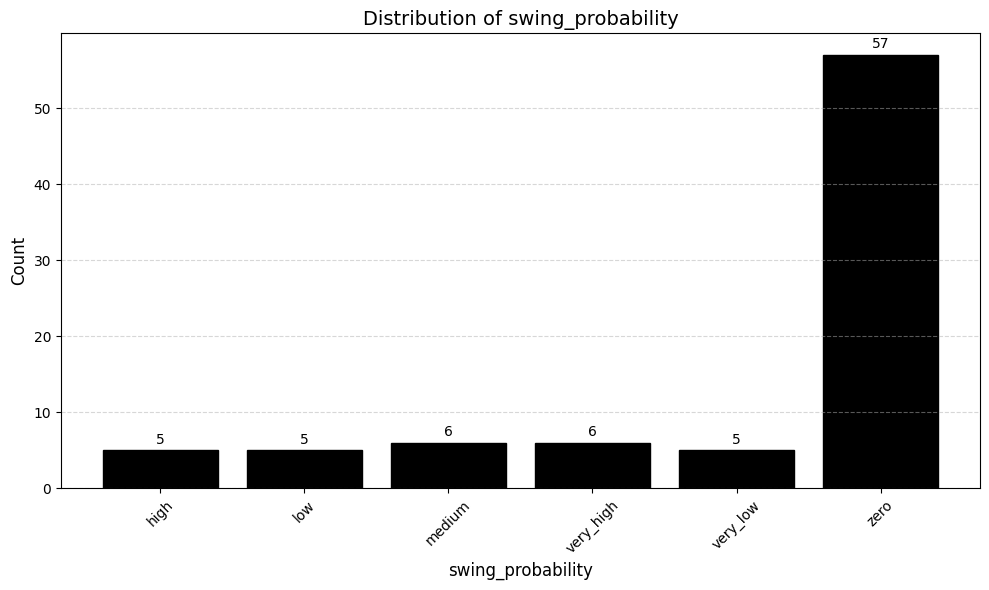

In [63]:
plot_categorical_distribution(final_results_df_schwab, column_name="swing_probability")

Manually modify this using the function after it:

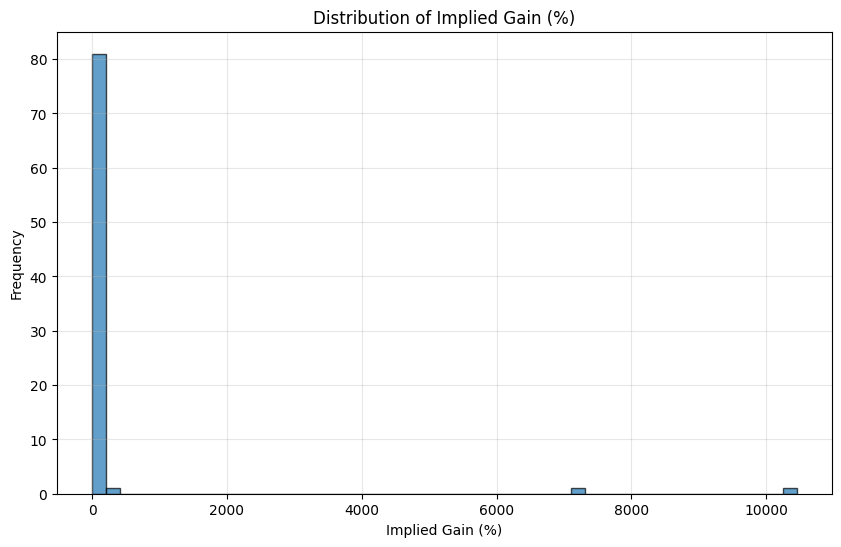

In [64]:
# Histogram of implied_gain_pct (shown as %)
pct_gain_values = pd.to_numeric(final_results_df_schwab["implied_gain_pct"], errors="coerce").dropna() * 100

plt.figure(figsize=(10,6))
plt.hist(pct_gain_values, bins=50, edgecolor="black", alpha=0.7)
plt.title("Distribution of Implied Gain (%)")
plt.xlabel("Implied Gain (%)")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

In [65]:
def plot_histogram(ax, s, title, xlabel, *, bins=50, percent=False, clip_q=None, logx=False):
    s = pd.to_numeric(s, errors="coerce").dropna()
    n_raw = len(s)
    if clip_q is not None:
        lo, hi = s.quantile(clip_q[0]), s.quantile(clip_q[1])
        s = s[(s >= lo) & (s <= hi)]
        clipped = n_raw - len(s)
    else:
        clipped = 0

    x = s * 100 if percent else s
    ax.hist(x, bins=bins, alpha=0.7, edgecolor="black")
    mean, med = float(np.mean(x)), float(np.median(x))
    ax.axvline(mean, color='red', linestyle="--", linewidth=2, label=f"Mean = {mean:.2f}{'%' if percent else ''}")
    ax.axvline(med,  linestyle="-.", linewidth=2, label=f"Median = {med:.2f}{'%' if percent else ''}")
    if logx:
        ax.set_xscale("log")
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Frequency")
    ax.legend()
    ax.grid(alpha=0.3)
    if clip_q is not None:
        ax.text(0.99, 0.98, f"clipped {clipped}/{n_raw}", transform=ax.transAxes,
                ha="right", va="top", fontsize=9)


Visualize the distributions of some annualization metrics.

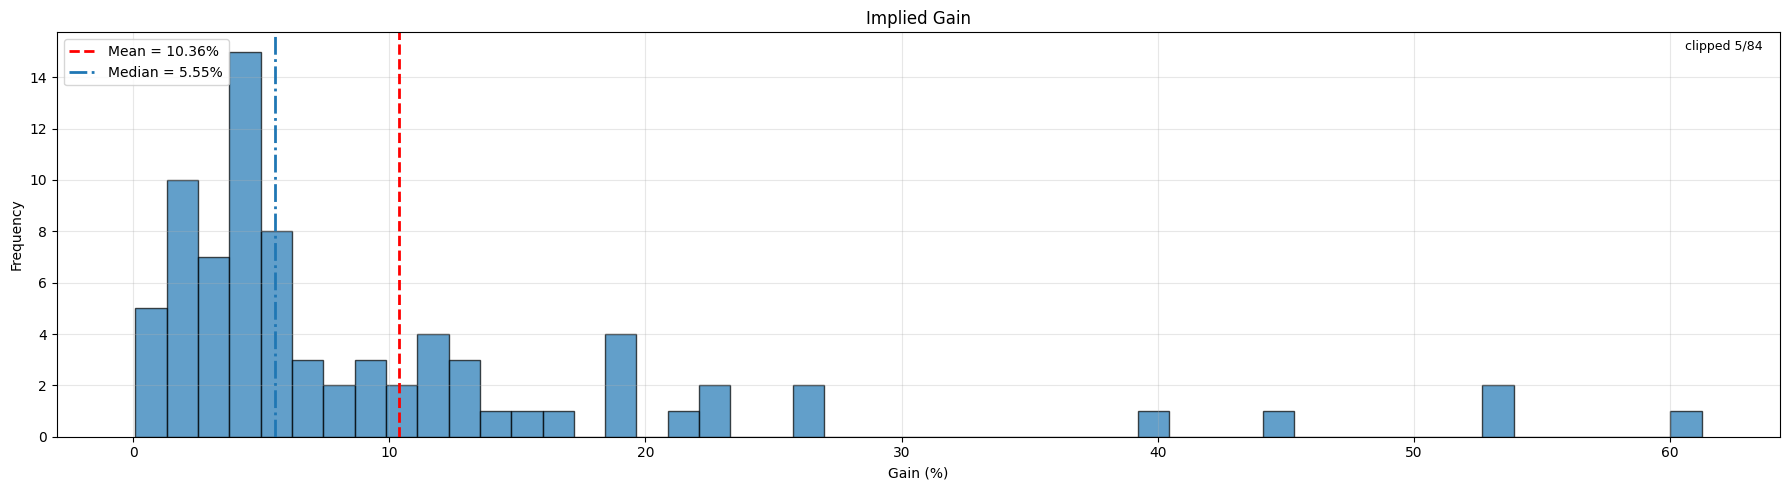

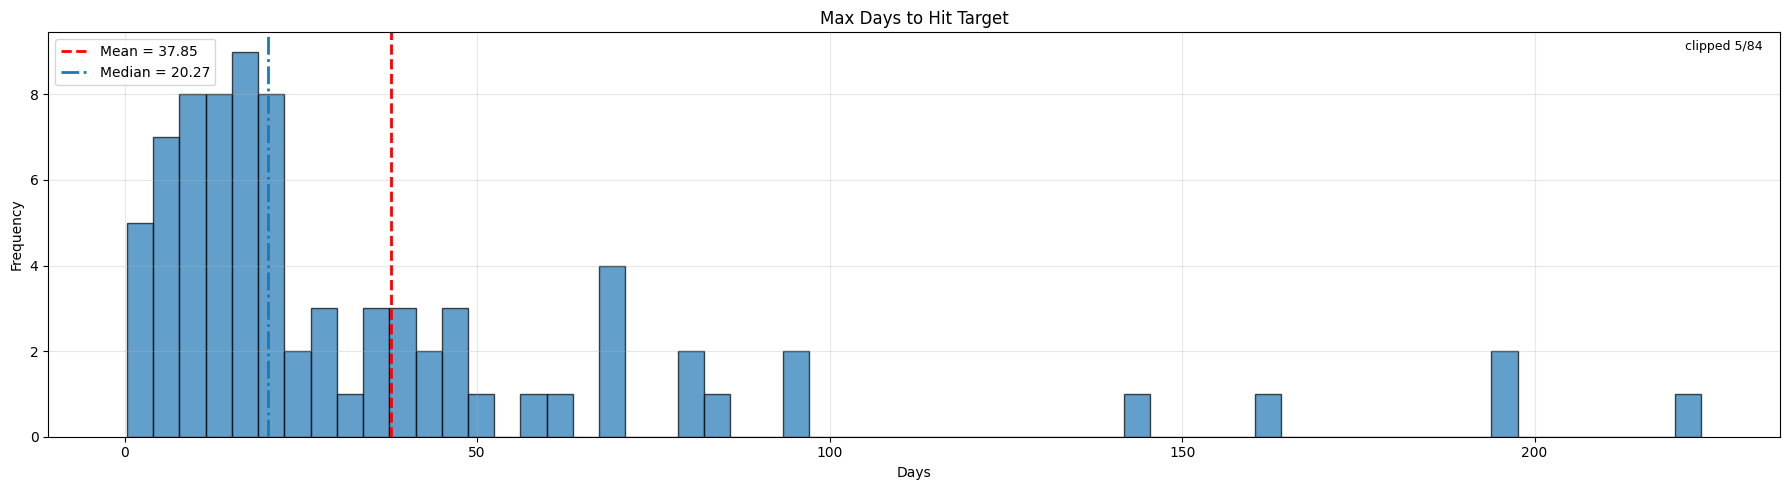

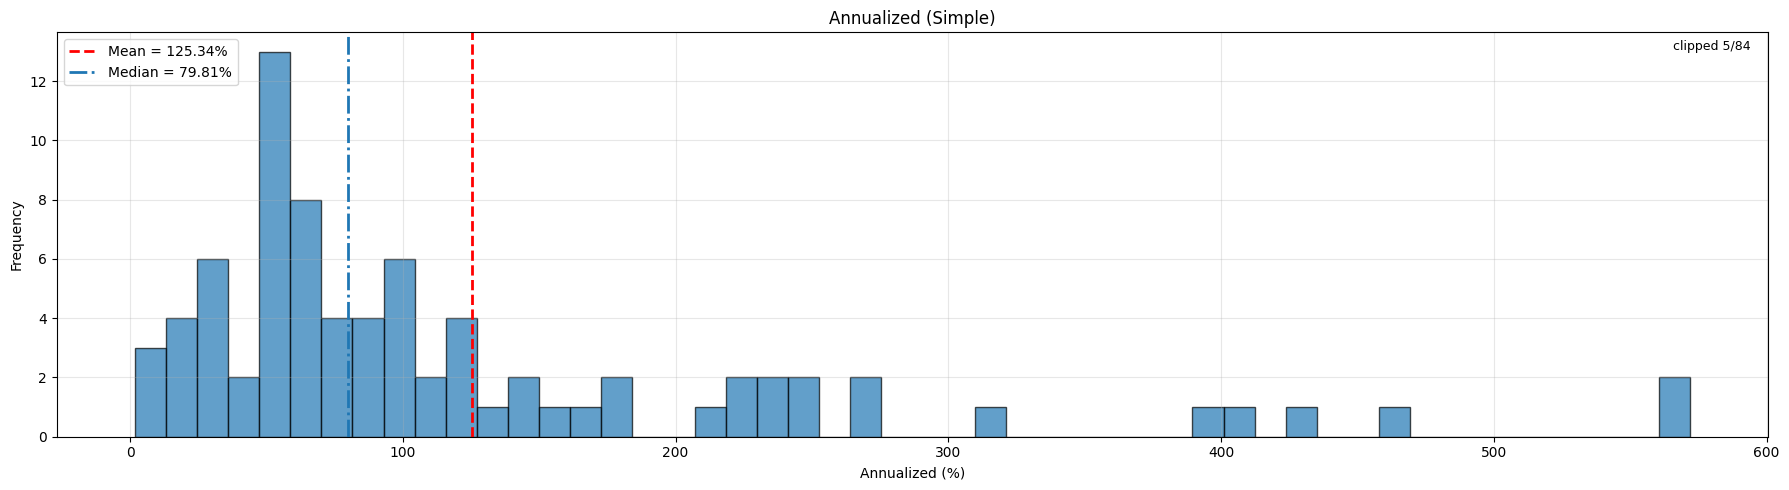

In [66]:
lower_clip = 0
upper_clip = 0.95
cols_needed = ["implied_gain_pct", "max_days_simple", "annual_simple_from_avg_duration"]
missing = [c for c in cols_needed if c not in final_results_df_schwab.columns]

if missing:
    print("⚠️ Missing columns:", missing)
else:
    # 1) Implied Gain
    plt.figure(figsize=(18, 5))
    plot_histogram(
        plt.gca(),
        final_results_df_schwab["implied_gain_pct"],
        title="Implied Gain",
        xlabel="Gain (%)",
        percent=True,
        clip_q=(lower_clip, upper_clip),
        bins=50
    )
    plt.tight_layout()
    plt.show()

    # 2) Max Days to Hit Target
    plt.figure(figsize=(18, 5))
    plot_histogram(
        plt.gca(),
        final_results_df_schwab["max_days_simple"],
        title="Max Days to Hit Target",
        xlabel="Days",
        clip_q=(lower_clip, upper_clip),
        bins=60,
        logx=False
    )
    plt.tight_layout()
    plt.show()

    # 3) Annualized (Simple)
    plt.figure(figsize=(18, 5))
    plot_histogram(
        plt.gca(),
        final_results_df_schwab["annual_simple_from_avg_duration"],
        title="Annualized (Simple)",
        xlabel="Annualized (%)",
        percent=True,
        clip_q=(lower_clip, upper_clip),
        bins=50
    )
    plt.tight_layout()
    plt.show()


## <h2 style="color:purple;">Chart visualization, Storage, and Excel Report File Creation</h2>

### <h3 style="color:yellow;">Chart creation for selected tickers' analyses</h3>

In [67]:
def run_sql_query(sql, project_id, credentials_path=None):
    """
    Executes a SQL query against Google BigQuery using a service account.

    This function creates an authenticated BigQuery client using a local
    service account JSON credentials file, submits the SQL query, waits
    for it to complete, and returns the results as a pandas DataFrame.

    Args:
        sql (str): The SQL query string to be executed.
        project_id (str): The GCP project ID associated with the BigQuery dataset.
        credentials_path (str): Full path to the service account JSON credentials file.

    Returns:
        pd.DataFrame: The query results as a DataFrame. Each column corresponds to a 
                      field in the SELECT statement of the query.

    Raises:
        ValueError: If `credentials_path` is not provided.
    """
    if credentials_path is None:
        raise ValueError("credentials_path must be provided")

    credentials = service_account.Credentials.from_service_account_file(credentials_path)
    client = bigquery.Client(credentials=credentials, project=project_id)

    query_job = client.query(sql)
    result = query_job.result()
    return result.to_dataframe()

def get_ticker_data(ticker, date_pull_begin=None, local=False, local_folder="local-ticker-data-schwab", credentials_path=None, project_id=None):
    """
    Retrieve daily OHLC data for a ticker from a local TSV or BigQuery.

    If `local=True`, reads `{data/<local_folder>/<ticker>.txt}` (tab-delimited) and
    parses `date_time`. Otherwise, queries the
    `stock-chipper-87578.first_rate.stocks_candle_1day` table for rows after
    `date_pull_begin` (defaults to 2 years before today).

    Args:
        ticker (str): Ticker symbol to load (e.g., "AAPL").
        date_pull_begin (datetime-like, optional): Earliest timestamp to include when
            pulling from BigQuery. If omitted, uses “today − 2 years”.
        local (bool): If True, load from a local TSV file; if False, query BigQuery.
        local_folder (str): Subfolder under `data/` containing local files
            (e.g., "local-ticker-data-schwab" or "local-ticker-data-gbq").
        credentials_path (str, optional): Path to the GCP service-account JSON. Required
            when `local=False`.
        project_id (str, optional): GCP project ID. Required when `local=False`.

    Returns:
        pd.DataFrame: Time-ascending data with at least:
            - 'ticker' (str)
            - 'date_time' (datetime64[ns])
            - 'open' (float)
            - 'high' (float)
            - 'low'  (float)
            - 'close' (float)
            - 'volume' (float/int, if available)
        Extra columns present in the source are preserved.
    """
    if local:
        file_path = Path("strategies/swing-trading/data") / local_folder / f"{ticker}.txt"
        return pd.read_csv(file_path, sep="\t", parse_dates=["date_time"])

    if date_pull_begin is None:
        date_pull_begin = pd.Timestamp.today() - pd.DateOffset(years=2)                             #HARDCODE#

    sql = f"""
        SELECT ticker, date_time, open, high, low, close, volume
        FROM `stock-chipper-87578.first_rate.stocks_candle_1day`
        WHERE date_time > '{date_pull_begin:%Y-%m-%d}' AND ticker = '{ticker}'
        ORDER BY date_time ASC
    """

    return run_sql_query(sql, project_id=project_id, credentials_path=credentials_path)

def plot_swing_trades(result_row, num_tickers_source, local=True, local_folder="local-ticker-data-schwab", data_source="schwab", swing_probability_filter=None, 
                      bound_reference="upper", chosen_end_date=chosen_end_date):
    """
    Plot price action and swing-trade context for a single ticker over one analysis→evaluation cycle.

    Produces a time-series chart with:
    - Daily high/low as error bars
    - Horizontal buy/sell thresholds
    - Linear trend line over the analysis window
    - Optional segment trend from date_began_below_{lb|ub} to analysis_period_end
    - Period boundary markers and buy/sell trade markers
    - A caption summarizing key metrics and weights
    The figure is saved to disk and the path is printed.

    Args:
        result_row (pd.Series | pd.DataFrame): A single walk-forward result row (if a
            DataFrame is passed, only the first row is used). Must provide at least:
            ['ticker', 'analysis_period_start', 'analysis_period_end',
            'evaluation_period_start', 'evaluation_period_end',
            'analysis_buy', 'analysis_sell'].
            For the caption/segment line, it may also include fields such as:
            ['profit_rank', 'swing_probability', 'trend_slope', 'norm_trend_slope',
            'cyclicality', f'date_began_below_{{lb|ub}}', f'slope_below_{{lb|ub}}',
            and the corresponding *_weight columns].
        num_tickers_source (int): Total number of tickers used to format the
            profit-rank display in the caption.
        local (bool, optional): If True, load prices from local files via
            `get_ticker_data`; otherwise use the non-local path. Default: True.
        local_folder (str, optional): Folder name used when `local=True` to locate
            cached price data. Default: "local-ticker-data-schwab".
        data_source (str, optional): Data provider tag used to control caption
            content (e.g., "schwab"). Default: "schwab".
        swing_probability_filter (str | None, optional): Label incorporated into
            the output directory path for saved figures. Default: None.
        bound_reference ({"upper", "lower"}, optional): Which bound family to use
            for the segment trend and caption fields; selects 'ub' when "upper" and
            'lb' when "lower". Default: "upper".

    Returns:
        None: Creates and saves a PNG plot under:
            swing_trade_charts/swing_analysis_period_ending_<YYYY-MM-DD>/
            prediction_charts_<YYYY-MM-DD>/<filter>_<YYYY-MM-DD>/
            and closes the Matplotlib figure.
    """
    if isinstance(result_row, pd.DataFrame):
        result_row = result_row.iloc[0]

    analysis_period_start = pd.to_datetime(result_row["analysis_period_start"])
    evaluation_period_end = pd.to_datetime(result_row["evaluation_period_end"])
    analysis_period_end = pd.to_datetime(result_row["analysis_period_end"])
    evaluation_period_start = pd.to_datetime(result_row["evaluation_period_start"])

    ticker = result_row["ticker"]
    buy_level = result_row["analysis_buy"]
    sell_level = result_row["analysis_sell"]
    suffix = "lb" if bound_reference == "lower" else "ub"

    # Pull data and filter
    ticker_data = get_ticker_data(ticker, analysis_period_start, local=local, local_folder=local_folder)
    ticker_data = ticker_data[ticker_data["date_time"] <= evaluation_period_end]

    # Get trades from both periods
    trades_analysis = get_trades(
        ticker_data[
            (ticker_data["date_time"] >= result_row["analysis_period_start"]) &
            (ticker_data["date_time"] <= result_row["analysis_period_end"])
        ],
        upper_bound=sell_level,
        lower_bound=buy_level,
        time_start=result_row["analysis_period_start"]
    )

    trades_eval = get_trades(
        ticker_data[
            (ticker_data["date_time"] >= result_row["evaluation_period_start"]) &
            (ticker_data["date_time"] <= result_row["evaluation_period_end"])
        ],
        upper_bound=sell_level,
        lower_bound=buy_level,
        time_start=result_row["evaluation_period_start"]
    )

    trades = pd.concat([trades_analysis, trades_eval], ignore_index=True)

    # Add trade price as the bound unless out of range, in which case midpoint
    trades["price"] = trades.apply(
        lambda row: row["trade_price"]
        if row["daily_low"] <= row["trade_price"] <= row["daily_high"]
        else 0.5 * (row["daily_high"] + row["daily_low"]),
        axis=1
    )

    # Plot setup
    fig, ax = plt.subplots(figsize=(18, 9))
    
    # Initialize slope so it can be used later in the caption
    analysis_trend_slope = None

    # Linear regression line over analysis period only
    analysis_data = ticker_data[
        (ticker_data["date_time"] >= analysis_period_start) &
        (ticker_data["date_time"] <= analysis_period_end)
    ].copy()

    if not analysis_data.empty:
        x_vals = mdates.date2num(analysis_data["date_time"])  # Convert datetime to numeric for regression
        y_vals = analysis_data["close"].values

        if len(x_vals) >= 2:
            slope, intercept, _, _, _ = linregress(x_vals, y_vals)
            reg_line = intercept + slope * x_vals
            ax.plot(analysis_data["date_time"], reg_line, linestyle="--", linewidth=2, color="tab:blue", label="Linear Trend (Analysis)")
            analysis_trend_slope = slope

    # Plot slope_below_ub segment (from date_began_below_ub to analysis_period_end)
    seg_start = pd.to_datetime(result_row.get(f"date_began_below_{suffix}", pd.NaT), errors="coerce")
    seg_slope = pd.to_numeric(result_row.get(f"slope_below_{suffix}", np.nan), errors="coerce")

    if pd.notna(seg_start) and pd.notna(seg_slope) and (seg_start <= analysis_period_end):
        seg = ticker_data[(ticker_data["date_time"] >= seg_start) & (ticker_data["date_time"] <= analysis_period_end)].copy()
        if len(seg) >= 2:
            x_num = mdates.date2num(seg["date_time"])
            y = seg["close"].to_numpy()

            # Anchor the line to match the OLS fit using the provided slope
            intercept = y.mean() - seg_slope * x_num.mean()
            y_hat = intercept + seg_slope * x_num

            ax.plot(seg["date_time"], y_hat, linestyle="-.", linewidth=2, color="tab:orange", label=f"Trend (Below-{'Buy' if suffix=='lb' else 'Sell'} Segment)")

    # Error bars (high/low ranges)
    ax.errorbar(ticker_data["date_time"], 
                y=(ticker_data["high"] + ticker_data["low"]) / 2,
                yerr=(ticker_data["high"] - ticker_data["low"]) / 2,
                fmt='-', color="gray", ecolor='black', alpha=0.4)

    # Horizontal lines for buy/sell levels
    ax.axhline(buy_level, color="palegreen", linestyle="--", label="Buy Level")
    ax.axhline(sell_level, color="lightcoral", linestyle="--", label="Sell Level")

    # Get evenly spaced y-positions for the labels
    y_min = ticker_data["low"].min()
    y_max = ticker_data["high"].max()
    y_positions = np.linspace(y_min, y_max, 4)

    # Vertical markers for key dates with evenly spaced labels
    ax.axvline(analysis_period_start, color="black", linestyle=":", label="Analysis Period Starts")
    ax.text(analysis_period_start, y_positions[3], f"Analysis Period Starts\n{analysis_period_start.strftime('%Y-%m-%d')}",
            rotation=0, va="center", ha="right", color="black")

    ax.axvline(analysis_period_end, color="black", linestyle=":", label="Analysis Period Ends")
    ax.text(analysis_period_end, y_positions[2], f"Analysis Period Ends\n{analysis_period_end.strftime('%Y-%m-%d')}",
            rotation=0, va="center", ha="right", color="black")

    ax.axvline(evaluation_period_start, color="black", linestyle=":", label="Evaluation Period Starts")
    ax.text(evaluation_period_start, y_positions[1], f"Evaluation Period Starts\n{evaluation_period_start.strftime('%Y-%m-%d')}",
            rotation=0, va="center", ha="left", color="black")

    ax.axvline(evaluation_period_end, color="black", linestyle=":", label="Evaluation Period Ends")
    ax.text(evaluation_period_end, y_positions[0], f"Evaluation Period Ends\n{evaluation_period_end.strftime('%Y-%m-%d')}",
            rotation=0, va="center", ha="right", color="black")

    # Plot trade points
    buy_trades = trades[trades["type"] == "buy"]
    sell_trades = trades[trades["type"] == "sell"]
    ax.scatter(buy_trades["date"], buy_trades["price"], color="green", label="Buy", zorder=5)
    ax.scatter(sell_trades["date"], sell_trades["price"], color="red", label="Sell", zorder=5)

    # Ensure 'type' column exists to avoid KeyError when counting trades
    for df_check, label in [(trades_analysis, "trades_analysis"), (trades_eval, "trades_eval")]:
        if "type" not in df_check.columns:
            print(f"⚠️ Missing 'type' column in {label} — likely no trades occurred.")
            df_check["type"] = None  # Add placeholder column to prevent KeyError

    try:
        caption_lines = [
            f"Full Range: {analysis_period_start.date()} to {evaluation_period_end.date()}",
            f"Buy Level: {buy_level:.2f}",
            f"Sell Level: {sell_level:.2f}",
            f"Analysis Trades: {len(trades_analysis[trades_analysis['type'] == 'sell'])}",
            f"Analysis Return: {result_row['analysis_return']:.2%}",
            f"Evaluation Trades: {len(trades_eval[trades_eval['type'] == 'sell'])}",
            f"Evaluation Return: {result_row['evaluation_return']:.2%}",
        ]

        if data_source == "schwab":
            suffix = "lb" if bound_reference == "lower" else "ub"

            cp_below_w = result_row.get(f"current_price_below_{suffix}_weight", np.nan)
            pct_below_w = result_row.get(f"percent_below_{suffix}_weight", np.nan)
            days_below_w = result_row.get(f"num_days_below_{suffix}_weight", np.nan)

            caption_lines += [
                f"---------------------------------------",
                f"Profit Rank: {int(result_row['profit_rank'])}/{num_tickers_source}",
                f"Swing Probability: {result_row['swing_probability']}",
                f"Normalized Trend Slope: {result_row['norm_trend_slope']:.4f} - Weighting: {result_row['norm_trend_slope_weight']:.2f}", #
                f"Normalized Below { 'Buy' if suffix=='lb' else 'Sell' } Slope: {result_row.get(f'norm_below_{suffix}_trend_slope', np.nan):.4f} - Weighting: {result_row.get(f'norm_below_{suffix}_trend_slope_weight', np.nan):.2f}", #
                f"Below { 'Buy' if suffix=='lb' else 'Sell' } Trend Slope: {result_row.get(f'slope_below_{suffix}', np.nan):.4f} - Weighting: {result_row.get(f'below_{suffix}_trend_slope_weight', np.nan):.2f}", #
                f"Cyclicality: {result_row['cyclicality']:.4f} - Weighting: {result_row['cyclicality_weight']:.2f}",                               #
                f"Current Price Below { 'Buy' if suffix=='lb' else 'Sell' }: {result_row.get(f'current_price_below_{suffix}', np.nan)} - Weighting: {cp_below_w:.2f}", #
                f"Percent Below { 'Buy' if suffix=='lb' else 'Sell' }: {result_row.get(f'percent_below_{suffix}', np.nan):.2%} - Weighting: {pct_below_w:.2f}",               #
                f"Num Days Fully Below { 'Buy' if suffix=='lb' else 'Sell' }: {int(pd.to_numeric(result_row.get(f'num_days_below_{suffix}', np.nan), errors='coerce') or 0)} - Weighting: {days_below_w:.2f}",     #
                f"Date Began Below { 'Buy' if suffix=='lb' else 'Sell' }: {pd.to_datetime(result_row.get(f'date_began_below_{suffix}', pd.NaT)).date() if pd.notna(result_row.get(f'date_began_below_{suffix}', pd.NaT)) else 'n/a'}", #
                f"---------------------------------------",
                # f"Current Price Below Sell: {result_row['current_price_below_ub']}",
                # f"Percent Below Sell: {result_row['percent_below_ub']:.2%}",
                # f"Price Between Bounds: {result_row['current_price_between_bounds']}",
                f"Plot Calculated Slope: {analysis_trend_slope:.4f}",
                f"Analysis Trend Slope: {result_row['trend_slope']:.4f}",
                f"Profit Score: {result_row['profit_score']:.4f}",
            ]

            # === NEW METRICS (simple-only enrichment, terser) ===
            imp = result_row.get("implied_gain_pct", np.nan)
            mds = pd.to_numeric(result_row.get("max_days_simple", np.nan), errors="coerce")
            exit_dt = pd.to_datetime(result_row.get("exit_by_date_simple", pd.NaT), errors="coerce")
            avg_dur = pd.to_numeric(result_row.get("analysis_avg_trade_duration", np.nan), errors="coerce")
            ann_simple = result_row.get("annual_simple_from_avg_duration", np.nan)

            caption_lines += [
                f"---------------------------------------",
                f"Implied Gain (Sell/Buy - 1): {f'{imp:.2%}' if pd.notna(imp) else 'n/a'}",
                f"Max Days (Simple) to Hit Target: {f'{np.ceil(mds):.0f} days' if pd.notna(mds) else 'n/a'}",
                f"Exit-By Date (Simple): {exit_dt.strftime('%Y-%m-%d') if pd.notna(exit_dt) else 'n/a'}",
                f"Avg Trade Duration (Analysis): {f'{avg_dur:.1f} days' if pd.notna(avg_dur) else 'n/a'}",
                f"Simple Annualized @ Avg Duration: {f'{ann_simple:.2%}' if pd.notna(ann_simple) else 'n/a'}",
            ]

        caption = "\n".join(caption_lines)

    except Exception as e:
        print(f"⚠️ Error generating caption for {ticker}: {e}")
        caption = f"Plot generated for {ticker}, but caption failed to render."

    ax.set_title(f"Swing Trades for {ticker}", fontsize=14)
    ax.set_xlabel("")
    ax.set_ylabel("Price")
        # Legend: always snug in the upper-right corner
    ax.legend(
        loc="upper right",
        bbox_to_anchor=(1.0, 1.0),
        borderaxespad=0.25,
        frameon=True,
        framealpha=0.5,
    )
    
    ax.text(0.01, 0.01, caption, transform=ax.transAxes, fontsize=10,
            va='bottom', ha='left', bbox=dict(facecolor='white', alpha=0.5))

    # Format date axis
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Auto-save the figure
    output_dir = Path("swing_trade_charts") / f"swing_analysis_period_ending_{chosen_end_date}" / f"prediction_charts_{chosen_end_date}" / f"{str(swing_probability_filter)}_{chosen_end_date}"
    output_dir.mkdir(parents=True, exist_ok=True)
    filename = f"0{int(result_row['profit_rank'])}_{ticker}_{analysis_period_start.date()}_{chosen_end_date}.png"
    plt.savefig(output_dir / filename, dpi=300, bbox_inches="tight")
    print(f"Saved plot for {ticker} to {output_dir / filename}")

    # plt.show()
    plt.close(fig)  # Prevent automatic rendering

def plot_random_ticker_trades(final_results_dict, num_tickers_source, local_folder, data_source,
                              num_tickers=2, swing_probability_filter=None, select_top=False, bound_reference="upper"):
    """
    Select and plot one or more tickers’ walk-forward rows using `plot_swing_trades`.

    Filters each ticker’s results optionally by `swing_probability`, then either
    samples tickers at random or picks the best by minimum `profit_rank`. For each
    selected ticker, iterates its rows and renders/saves charts via
    `plot_swing_trades`, printing progress and basic error messages.

    Args:
        final_results_dict (dict[str, pd.DataFrame]): Mapping of ticker → results
            table. Each DataFrame should contain at least:
            ['profit_rank', 'swing_probability', 'analysis_period_start',
            'analysis_period_end', 'evaluation_period_start',
            'evaluation_period_end', 'analysis_buy', 'analysis_sell'] and any
            fields consumed by `plot_swing_trades`.
        num_tickers_source (int): Total count of source tickers; forwarded to
            `plot_swing_trades` for caption context.
        local_folder (str): Folder containing local candle data used by
            `plot_swing_trades` when `local=True`.
        data_source (str): Data provider label (e.g., "schwab"); forwarded to
            `plot_swing_trades`.
        num_tickers (int, optional): Number of tickers to plot. Default: 2.
        swing_probability_filter (str | None, optional): If provided, only rows
            where `swing_probability` equals this value are considered. Default: None.
        select_top (bool, optional): If True, selects tickers by best (lowest)
            `profit_rank`; otherwise samples randomly. Default: False.
        bound_reference ({'upper','lower'}, optional): Which bound family to use
            inside `plot_swing_trades` (affects segment/labels). Default: "upper".

    Returns:
        None: Charts are produced/saved by `plot_swing_trades`; progress is printed
        to stdout. If no rows match the filter, a message is printed and the
        function returns early.
    """
    filtered = []

    for ticker, df in final_results_dict.items():
        if swing_probability_filter is not None:
            df = df[df["swing_probability"] == swing_probability_filter]

        if not df.empty:
            filtered.append((ticker, df))

    if not filtered:
        print(f"No tickers found with swing_probability == '{swing_probability_filter}'.")
        return

    if select_top:
        # Flatten, then sort by best (lowest) profit_rank per ticker
        filtered = sorted(
            filtered,
            key=lambda item: item[1]["profit_rank"].min()
        )
    else:
        filtered = random.sample(filtered, k=min(num_tickers, len(filtered)))

    selected = filtered[:min(num_tickers, len(filtered))]

    for ticker, df in selected:
        for i, row in df.iterrows():
            print(f"Plotting row {i} for {ticker}...")
            try:
                plot_swing_trades(row, num_tickers_source, local=True, local_folder=local_folder,
                  data_source=data_source, swing_probability_filter=swing_probability_filter, bound_reference=bound_reference)
            except Exception as e:
                print(f"Failed to plot row {i} for {ticker}: {e}")
        print(f"COMPLETED PLOTTING FOR {ticker} -------------------------------------------------------------------------------------------------------------------------------------\n")

Close Excel if it's open so the program can continue running.

In [68]:
try:
    subprocess.run(["taskkill", "/f", "/im", "excel.exe"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    print("🛑 Closed existing Excel instances.")
except Exception as e:
    print(f"⚠️ Could not close Excel automatically: {e}")
time.sleep(5)  # Give it a moment to close

🛑 Closed existing Excel instances.


Delete `swing_trade_charts` if it exists.

In [69]:
chosen_end_date

'2025-08-29'

In [70]:
# Define the folder path
folder_path = Path("swing_trade_charts") / f"swing_analysis_period_ending_{chosen_end_date}"

# Check if it exists and delete it
if folder_path.exists() and folder_path.is_dir():
    shutil.rmtree(folder_path)
    print(f"✅ Deleted the folder: {folder_path}")
else:
    print(f"⚠️ Folder has not yet been created: {folder_path}")

✅ Deleted the folder: swing_trade_charts\swing_analysis_period_ending_2025-08-29


Plot top tickers from selected categories of `swing_probability` and save their charts to dated subdirectory.

In [71]:
num_very_high = 500             #PARAMETER#
num_high = 500
num_medium = 500
num_low = 500
num_very_low = 500
num_zero = 1000

# Define the swing probability filters and their corresponding num_tickers variables
swing_filter_config = [
    ("very_high", num_very_high),
    ("high",      num_high),
    ("medium",    num_medium),
    ("low",       num_low),
    ("very_low",  num_very_low),
    ("zero",      num_zero),
]

# Loop through each config and call plot_random_ticker_trades
for swing_filter, num_tickers_val in swing_filter_config:
    plot_random_ticker_trades(
        final_results_dict_schwab,
        num_tickers_schwab,
        local_folder="local-ticker-data-schwab",
        data_source='schwab',
        num_tickers=num_tickers_val,
        swing_probability_filter=swing_filter,
        select_top=True,
        bound_reference=bound_reference_schwab
    )

Plotting row 0 for PEBO...
Saved plot for PEBO to swing_trade_charts\swing_analysis_period_ending_2025-08-29\prediction_charts_2025-08-29\very_high_2025-08-29\01_PEBO_2023-08-31_2025-08-29.png
COMPLETED PLOTTING FOR PEBO -------------------------------------------------------------------------------------------------------------------------------------

Plotting row 0 for CENT...
Saved plot for CENT to swing_trade_charts\swing_analysis_period_ending_2025-08-29\prediction_charts_2025-08-29\very_high_2025-08-29\02_CENT_2023-08-31_2025-08-29.png
COMPLETED PLOTTING FOR CENT -------------------------------------------------------------------------------------------------------------------------------------

Plotting row 0 for VRIG...
Saved plot for VRIG to swing_trade_charts\swing_analysis_period_ending_2025-08-29\prediction_charts_2025-08-29\very_high_2025-08-29\03_VRIG_2023-08-31_2025-08-29.png
COMPLETED PLOTTING FOR VRIG -------------------------------------------------------------------

In [72]:
# Convert dict items to a list to enable index-based access
final_results_list_schwab = list(final_results_dict_schwab.items())

# Pick a random index and show its ticker (and DataFrame)
idx = random.randrange(len(final_results_list_schwab))
ticker, df = final_results_list_schwab[idx]
print(f"Ticker: {ticker}")
display(df)
display(final_results_dict_schwab)
display(recent_eval)

Ticker: WGS


,ticker,analysis_period_start,analysis_period_end,evaluation_period_start,evaluation_period_end,incubation_period_start,incubation_period_end,analysis_buy,analysis_sell,analysis_return,analysis_trades,analysis_eval_metric,evaluation_return,evaluation_trades,evaluation_data_good,incubation_return,incubation_trades,incubation_data_good,analysis_avg_trade_duration,current_price_below_lb,percent_below_lb,current_price_below_ub,percent_below_ub,current_price_between_bounds,num_days_below_lb,num_days_below_ub,date_began_below_lb,date_began_below_ub,trend_slope,norm_trend_slope,slope_below_ub,norm_slope_below_ub,slope_below_lb,norm_slope_below_lb,cyclicality,analysis_period_pct_change,compression_ratio,trend_persistence,range_shrink,compression_in_trend,rs_vs_median,rs_z,implied_gain_pct,max_days_simple,exit_by_date_simple,annual_simple_from_avg_duration,profit_score,profit_rank,swing_probability,current_price_below_ub_weight,percent_below_ub_weight,num_days_below_ub_weight,cyclicality_weight,norm_trend_slope_weight,norm_slope_below_ub_weight,recent_eval_weighted_return
0,WGS,2023-08-31,2025-08-29,2025-08-30,2025-08-30,2025-08-31,2025-08-31,74.7400,81.7626,0.7949,13,0.4642,0.0000,0,False,0.0000,0,False,43.0000,0.0000,-0.7325,0.0000,-0.5837,0.0000,0,0,NaT,NaT,0.1647,0.0036,NaN,NaN,NaN,NaN,0.0276,28.0989,0.4271,0.5500,1.0457,1.2879,28.0432,7.5786,0.0940,34.3192,2025-10-03,0.7981,0.0000,56.0000,zero,1.0000,0.0000,0.0000,1,0,1.4000,0.0000


{'AAPL':   ticker analysis_period_start analysis_period_end evaluation_period_start evaluation_period_end incubation_period_start incubation_period_end  analysis_buy  analysis_sell  analysis_return  analysis_trades  analysis_eval_metric  evaluation_return  evaluation_trades  evaluation_data_good  incubation_return  incubation_trades  incubation_data_good  analysis_avg_trade_duration  current_price_below_lb  percent_below_lb  current_price_below_ub  percent_below_ub  current_price_between_bounds  num_days_below_lb  num_days_below_ub date_began_below_lb date_began_below_ub  trend_slope  norm_trend_slope  slope_below_ub  norm_slope_below_ub  slope_below_lb  norm_slope_below_lb  cyclicality  analysis_period_pct_change  compression_ratio  trend_persistence  range_shrink  compression_in_trend  rs_vs_median    rs_z  implied_gain_pct  max_days_simple exit_by_date_simple  annual_simple_from_avg_duration  profit_score  profit_rank swing_probability  current_price_below_ub_weight  percent_below_u

0.0

### <h3 style="color:yellow;">Save OHLC and analysis data for selected tickers</h3>

In [73]:
def save_price_data_for_top_tickers(final_results_dict, candles_dict, swing_probability_filter="very_high", chosen_end_date=chosen_end_date):
    """
    Save price data CSVs only for tickers that already have saved prediction charts.

    Determines the most recent analysis end date from `final_results_dict` (using the
    row(s) with `profit_rank == 1`), locates the corresponding prediction chart folder,
    extracts tickers from the PNG filenames, and writes each matching ticker’s price
    data from `candles_dict` to a CSV. Only tickers whose results include the specified
    `swing_probability_filter` are exported. Prints status/warnings as it goes.

    Args:
        final_results_dict (dict[str, pd.DataFrame]): Mapping of ticker → results table.
            Each DataFrame should include at least ['profit_rank', 'analysis_period_end',
            'swing_probability'] and the filenames of its charts must follow the pattern
            `0{rank}_{TICKER}_{date1}_{date2}.png`.
        candles_dict (dict[str, pd.DataFrame]): Mapping of ticker → OHLCV price data to save.
        swing_probability_filter (str, optional): Only tickers with this category present
            in their `swing_probability` column are considered. Also used to locate the
            chart subfolder. Default: "very_high".

    Returns:
        None: Writes CSV files under:
            swing_trade_charts/
            swing_analysis_period_ending_{YYYY-MM-DD}/
                top_price_data_{YYYY-MM-DD}/
                {swing_probability_filter}_{YYYY-MM-DD}/
        If the anchor date or chart directory cannot be found, prints a warning and exits early.
    """
    # Step 1: Determine the date used in prediction chart folder naming
    best_date = None
    for df in final_results_dict.values():
        if not df.empty and (df["profit_rank"] == 1).any():
            best_date = chosen_end_date # pd.to_datetime(df[df["profit_rank"] == 1]["analysis_period_end"].iloc[0]).strftime("%Y-%m-%d")
            break

    if best_date is None:
        print("⚠️ Could not determine best date from results.")
        return

    # Step 2: Find all chart files in prediction_charts folder
    chart_dir = Path("swing_trade_charts") / f"swing_analysis_period_ending_{best_date}" / f"prediction_charts_{best_date}" / f"{swing_probability_filter}_{best_date}"
    if not chart_dir.exists():
        print(f"⚠️ Chart directory not found: {chart_dir}")
        return

    chart_files = list(chart_dir.glob("*.png"))
    chart_tickers = set()

    for file in chart_files:
        # Extract ticker from filename: assumes format like "0{rank}_{TICKER}_{date1}_{date2}.png"
        parts = file.stem.split("_")
        if len(parts) >= 2:
            chart_tickers.add(parts[1])  # second part is the ticker

    if not chart_tickers:
        print("⚠️ No chart tickers found.")
        return

    # Step 3: Create output dir for price data
    output_dir = Path("swing_trade_charts") / f"swing_analysis_period_ending_{best_date}" / f"top_price_data_{best_date}" / f"{swing_probability_filter}_{best_date}"
    output_dir.mkdir(parents=True, exist_ok=True)

    # Step 4: Save price data only for tickers with charts
    num_saved = 0
    for ticker, result_df in final_results_dict.items():
        if ticker in chart_tickers and swing_probability_filter in result_df["swing_probability"].values:
            if ticker in candles_dict:
                price_df = candles_dict[ticker]
                price_df.to_csv(output_dir / f"{ticker}.csv", index=False)
                num_saved += 1

    print(f"✅ Saved price data for {num_saved} tickers to {output_dir}")

In [74]:
final_results_dict_schwab

{'AAPL':   ticker analysis_period_start analysis_period_end evaluation_period_start evaluation_period_end incubation_period_start incubation_period_end  analysis_buy  analysis_sell  analysis_return  analysis_trades  analysis_eval_metric  evaluation_return  evaluation_trades  evaluation_data_good  incubation_return  incubation_trades  incubation_data_good  analysis_avg_trade_duration  current_price_below_lb  percent_below_lb  current_price_below_ub  percent_below_ub  current_price_between_bounds  num_days_below_lb  num_days_below_ub date_began_below_lb date_began_below_ub  trend_slope  norm_trend_slope  slope_below_ub  norm_slope_below_ub  slope_below_lb  norm_slope_below_lb  cyclicality  analysis_period_pct_change  compression_ratio  trend_persistence  range_shrink  compression_in_trend  rs_vs_median    rs_z  implied_gain_pct  max_days_simple exit_by_date_simple  annual_simple_from_avg_duration  profit_score  profit_rank swing_probability  current_price_below_ub_weight  percent_below_u

Save daily OHLC data for all of the top tickers from selected probability categories.

In [75]:
# List of swing probability filter values
swing_probability_filters = ["very_high", "high", "medium", "low", "very_low", "zero"]

# Loop through each filter and call save_price_data_for_top_tickers
for swing_filter in swing_probability_filters:
    save_price_data_for_top_tickers(
        final_results_dict_schwab,
        candles_dict_schwab,
        swing_probability_filter=swing_filter
    )

✅ Saved price data for 6 tickers to swing_trade_charts\swing_analysis_period_ending_2025-08-29\top_price_data_2025-08-29\very_high_2025-08-29
✅ Saved price data for 5 tickers to swing_trade_charts\swing_analysis_period_ending_2025-08-29\top_price_data_2025-08-29\high_2025-08-29
✅ Saved price data for 6 tickers to swing_trade_charts\swing_analysis_period_ending_2025-08-29\top_price_data_2025-08-29\medium_2025-08-29
✅ Saved price data for 5 tickers to swing_trade_charts\swing_analysis_period_ending_2025-08-29\top_price_data_2025-08-29\low_2025-08-29
✅ Saved price data for 5 tickers to swing_trade_charts\swing_analysis_period_ending_2025-08-29\top_price_data_2025-08-29\very_low_2025-08-29
✅ Saved price data for 57 tickers to swing_trade_charts\swing_analysis_period_ending_2025-08-29\top_price_data_2025-08-29\zero_2025-08-29


In [76]:
def save_top_analysis_results(final_results_dict, swing_probability_filter=None, chosen_end_date=chosen_end_date):
    """
    Save result CSVs only for tickers that already have saved prediction charts (by probability band).

    Finds the anchor date from rows with `profit_rank == 1`, locates the corresponding
    prediction chart folder for the specified `swing_probability_filter`, extracts the
    tickers present in the PNG filenames, and writes each matching ticker’s *results*
    (from `final_results_dict`) to CSV. Prints status/warnings as it goes.

    Args:
        final_results_dict (dict[str, pd.DataFrame]): Mapping of ticker → results table.
            Each DataFrame should include at least ['profit_rank', 'analysis_period_end',
            'swing_probability'] and correspond to chart filenames created elsewhere.
        swing_probability_filter (str or None): Required. Only rows whose
            `swing_probability` equals this value are exported, and this value is used
            to locate the chart subfolder (e.g., "very_high").

    Returns:
        None: Writes CSVs under:
            swing_trade_charts/
            swing_analysis_period_ending_{YYYY-MM-DD}/
                top_analysis_results_{YYYY-MM-DD}/
                {swing_probability_filter}_{YYYY-MM-DD}/
        If the anchor date, chart directory, or matching tickers are not found,
        the function prints a warning and returns early without raising.
    """
    # Step 1: Get date from results
    best_date = None
    for df in final_results_dict.values():
        if not df.empty and (df["profit_rank"] == 1).any():
            best_date = chosen_end_date # pd.to_datetime(df[df["profit_rank"] == 1]["analysis_period_end"].iloc[0]).strftime("%Y-%m-%d")
            break

    if best_date is None:
        print("⚠️ No valid result rows found with profit_rank == 1.")
        return

    if swing_probability_filter is None:
        print("⚠️ You must pass a swing_probability_filter (e.g. 'very_high').")
        return

    # Step 2: Identify tickers with prediction charts
    chart_dir = Path("swing_trade_charts") / f"swing_analysis_period_ending_{best_date}" / f"prediction_charts_{best_date}" / f"{swing_probability_filter}_{best_date}"
    if not chart_dir.exists():
        print(f"⚠️ Chart directory not found: {chart_dir}")
        return

    chart_files = list(chart_dir.glob("*.png"))
    chart_tickers = set()

    for file in chart_files:
        parts = file.stem.split("_")
        if len(parts) >= 2:
            chart_tickers.add(parts[1])

    if not chart_tickers:
        print("⚠️ No chart tickers found.")
        return

    # Step 3: Set output dir
    subfolder_name = f"{swing_probability_filter}_{best_date}"
    output_dir = Path("swing_trade_charts") / f"swing_analysis_period_ending_{best_date}" / f"top_analysis_results_{best_date}" / subfolder_name
    output_dir.mkdir(parents=True, exist_ok=True)

    # Step 4: Save results for tickers with charts
    num_saved = 0
    for ticker, df in final_results_dict.items():
        if ticker in chart_tickers:
            filtered_df = df[df["swing_probability"] == swing_probability_filter]
            if not filtered_df.empty:
                output_path = output_dir / f"{ticker}.csv"
                try:
                    filtered_df.to_csv(output_path, index=False)
                    num_saved += 1
                except Exception as e:
                    print(f"⚠️ Failed to save {ticker}: {e}")

    if num_saved == 0:
        print(f"⚠️ No matching tickers with charts and swing_probability == '{swing_probability_filter}'.")
    else:
        print(f"✅ Saved results for {num_saved} tickers to: {output_dir}")

Save analysis data only for the selected tickers for performance tracking purposes.

In [77]:
# Loop through each filter and call save_top_analysis_results
for swing_filter in swing_probability_filters:
    save_top_analysis_results(
        final_results_dict_schwab,
        swing_probability_filter=swing_filter
    )

✅ Saved results for 6 tickers to: swing_trade_charts\swing_analysis_period_ending_2025-08-29\top_analysis_results_2025-08-29\very_high_2025-08-29
✅ Saved results for 5 tickers to: swing_trade_charts\swing_analysis_period_ending_2025-08-29\top_analysis_results_2025-08-29\high_2025-08-29
✅ Saved results for 6 tickers to: swing_trade_charts\swing_analysis_period_ending_2025-08-29\top_analysis_results_2025-08-29\medium_2025-08-29
✅ Saved results for 5 tickers to: swing_trade_charts\swing_analysis_period_ending_2025-08-29\top_analysis_results_2025-08-29\low_2025-08-29
✅ Saved results for 5 tickers to: swing_trade_charts\swing_analysis_period_ending_2025-08-29\top_analysis_results_2025-08-29\very_low_2025-08-29
✅ Saved results for 57 tickers to: swing_trade_charts\swing_analysis_period_ending_2025-08-29\top_analysis_results_2025-08-29\zero_2025-08-29


### <h3 style="color:yellow;">Create Excel file with charts and summary data</h3>

In [78]:
chosen_end_date

'2025-08-29'

In [79]:
def create_excel_with_charts(final_results_dict_schwab, image_root="prediction_charts", close_excel=False, chosen_end_date=chosen_end_date):
    """
    Build an Excel workbook of embedded chart PNGs (one worksheet per subfolder) and save it to a dated output folder.

    Determines the anchor date from the first results table that has `profit_rank == 1`
    (`analysis_period_end` of that row). If none is found, uses today’s date. It then
    looks under:
        {image_root}/swing_analysis_period_ending_{YYYY-MM-DD}/prediction_charts_{YYYY-MM-DD}/
    treats each subfolder as a worksheet, embeds all `.png` images found there (stacked
    vertically), and finally appends a worksheet named "summary_candles" populated from
    the in-scope DataFrame `summary_candles_df`. The resulting workbook is written to:
        swing_trade_charts/swing_analysis_period_ending_{YYYY-MM-DD}/
    as `swing_recommendations_{YYYY-MM-DD}.xlsx`. Optionally closes Excel first
    (Windows) and then attempts to open the saved file.

    Args:
        final_results_dict_schwab (dict[str, pd.DataFrame]): Mapping of ticker → results
            DataFrame. Used only to infer the anchor date from rows where
            `profit_rank == 1`; the first match found supplies `analysis_period_end`.
        image_root (str, optional): Root directory that contains prediction-chart subfolders.
            The function expects the dated path:
            {image_root}/swing_analysis_period_ending_{date}/prediction_charts_{date}/...
            Default is "prediction_charts".
        close_excel (bool, optional): If True (Windows), attempts to terminate running
            Excel instances before writing (via `taskkill`). Defaults to False.

    Returns:
        None: Writes `swing_recommendations_{date}.xlsx` to the dated `swing_trade_charts/...`
        folder. Side effects: prints progress/warnings, may close Excel (Windows), and
        attempts to open the saved workbook. Requires `summary_candles_df` to exist in scope.
    """
    # Determine correct analysis_period_end from ticker with profit_rank == 1
    best_date = None
    for df in final_results_dict_schwab.values():
        if not df.empty and (df["profit_rank"] == 1).any():
            best_date = chosen_end_date # pd.to_datetime(df[df["profit_rank"] == 1]["analysis_period_end"].iloc[0]).strftime("%Y-%m-%d")
            break

    if best_date is None:
        best_date = datetime.today().strftime("%Y-%m-%d")

    # Path to image source: prediction_charts_YYYY-MM-DD
    image_root = Path(image_root) / f"swing_analysis_period_ending_{best_date}" / f"prediction_charts_{best_date}"
    if not image_root.exists():
        print(f"Image root folder '{image_root}' does not exist.")
        return

    # Path to Excel output: swing_trade_charts/swing_analysis_period_ending_YYYY-MM-DD/
    output_folder = Path("swing_trade_charts") / f"swing_analysis_period_ending_{best_date}"
    output_folder.mkdir(parents=True, exist_ok=True)
    output_file = f"swing_recommendations_{best_date}.xlsx"
    output_path = output_folder / output_file

    if close_excel:
        # Try to close Excel if open (Windows only)
        try:
            subprocess.run(["taskkill", "/f", "/im", "excel.exe"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
            print("🛑 Closed existing Excel instances.")
        except Exception as e:
            print(f"⚠️ Could not close Excel automatically: {e}")

    wb = Workbook()
    wb.remove(wb.active)  # Remove default sheet

    # Process folders in a fixed, semantic order (not filesystem order)
    desired_order = [
        f"very_high_{best_date}",
        f"high_{best_date}",
        f"medium_{best_date}",
        f"low_{best_date}",
        f"very_low_{best_date}",
        f"zero_{best_date}",
    ]
    ordered_folders = []
    for name in desired_order:
        path = image_root / name
        if path.is_dir():
            ordered_folders.append(path)
        else:
            print(f"ℹ️ Skipping missing folder: {path}")

    for folder in ordered_folders:
        sheet_name = folder.name[:31]  # Excel sheet name limit
        ws = wb.create_sheet(title=sheet_name)

        images = [
            folder / fname for fname in os.listdir(folder)
            if fname.lower().endswith(".png")
        ]

        try:
            images.sort(key=lambda p: int(p.name.split("_")[0]))
        except Exception as e:
            print(f"⚠️ Could not sort images in {folder}: {e}")

        if not images:
            print(f"No images found in {folder}")
            continue

        row = 1
        for img_path in images:
            try:
                Image.open(img_path).verify()
                img = XLImage(str(img_path))
                img.width = 1800
                img.height = 900
                ws.add_image(img, f"A{row}")
                row += 50
            except Exception as e:
                print(f"⚠️ Failed to add image {img_path}: {e}")

    # Add summary_candles_df to last sheet
    summary_sheet = wb.create_sheet(title="summary_candles")
    for col_idx, col_name in enumerate(summary_candles_df.columns, start=1):
        summary_sheet.cell(row=1, column=col_idx, value=col_name)
    for row_idx, row in enumerate(summary_candles_df.itertuples(index=False), start=2):
        for col_idx, value in enumerate(row, start=1):
            summary_sheet.cell(row=row_idx, column=col_idx, value=value)

    wb.save(output_path)
    print(f"✅ Excel workbook saved to: {output_path}")

    try:
        os.startfile(output_path)
        print(f"📂 Opened Excel workbook.")
    except Exception as e:
        print(f"⚠️ Could not open Excel file: {e}")

Insert PNG chart files into one sheet of an Excel file.

In [80]:
create_excel_with_charts(final_results_dict_schwab, image_root="swing_trade_charts", close_excel=True)

🛑 Closed existing Excel instances.
✅ Excel workbook saved to: swing_trade_charts\swing_analysis_period_ending_2025-08-29\swing_recommendations_2025-08-29.xlsx
📂 Opened Excel workbook.


## <h2 style="color:purple;">Track Performance of Prior Predictions</h2>

### <h3 style="color:yellow;">Identify available dates and tickers</h3>

In [81]:
def list_available_swing_analysis_dates(base_dir="swing_trade_charts"):
    """
    List available swing-analysis end dates by scanning a base directory.

    Searches `base_dir` for folders named like
    `swing_analysis_period_ending_YYYY-MM-DD`, collects the YYYY-MM-DD parts,
    sorts them in reverse chronological order, and prints each date on its own line.
    If the directory doesn’t exist or no matching folders are found, prints a warning.

    Args:
        base_dir (str): Root directory to scan for dated analysis folders.
            Defaults to "swing_trade_charts".

    Returns:
        None. Prints a sorted list of detected dates (or a warning message).
    """
    base_path = Path(base_dir)
    if not base_path.exists():
        print(f"⚠️ Directory not found: {base_path}")
        return

    date_pattern = re.compile(r"swing_analysis_period_ending_(\d{4}-\d{2}-\d{2})")
    available_dates = []

    for folder in base_path.iterdir():
        if folder.is_dir():
            match = date_pattern.match(folder.name)
            if match:
                available_dates.append(match.group(1))

    if not available_dates:
        print("No valid swing analysis folders found.")
    else:
        for date_str in sorted(available_dates, reverse=True):
            print(date_str)

Print a selection of dates from which to choose for profit tracking.

In [82]:
list_available_swing_analysis_dates(base_dir="swing_trade_charts")

2025-08-29


In [83]:
def list_tickers_by_swing_strength(date_str, base_dir="swing_trade_charts"):
    """
    Build per-category ticker lists from saved chart images for a given analysis date.

    Scans:
        {base_dir}/swing_analysis_period_ending_{date_str}/prediction_charts_{date_str}/
    for subfolders named like "{category}_{date_str}" (e.g., "very_high_2025-01-10"), then
    parses each PNG filename to extract the ticker symbol and aggregates a unique, sorted
    list per category. As a side effect, also registers each list as a global variable
    named "{category}_tickers".

    Args:
        date_str (str): Analysis-period end date to target, formatted "YYYY-MM-DD".
        base_dir (str): Root directory containing swing-analysis outputs. Defaults to
            "swing_trade_charts".

    Returns:
        dict: Mapping from category name (str) → list[str] of unique, sorted tickers
            discovered under that category’s folder. Returns an empty dict if the
            expected directory is missing.
    """
    base_path = Path(base_dir) / f"swing_analysis_period_ending_{date_str}" / f"prediction_charts_{date_str}"
    if not base_path.exists():
        print(f"⚠️ Folder not found: {base_path}")
        return {}

    tickers_by_category = {}

    # Dynamically get all swing probability folders
    for subfolder in base_path.iterdir():
        if subfolder.is_dir() and subfolder.name.endswith(f"_{date_str}"):
            category = subfolder.name.replace(f"_{date_str}", "")
            tickers = []

            for file in subfolder.glob("*.png"):
                try:
                    parts = file.name.split("_")
                    ticker = parts[1]
                    tickers.append(ticker)
                except IndexError:
                    print(f"⚠️ Unexpected file format: {file.name}")

            tickers_by_category[category] = sorted(set(tickers))
            globals()[f"{category}_tickers"] = tickers_by_category[category]  # Register as global variable

    return tickers_by_category

Print all tickers in each swing category.

In [84]:
display(chosen_end_date)
display(candles_df['date_time'].max().strftime('%Y-%m-%d'))
print(chosen_end_date == candles_df['date_time'].max().strftime('%Y-%m-%d'))

'2025-08-29'

'2025-08-29'

True


In [85]:
# if chosen_end_date == candles_df['date_time'].max().strftime('%Y-%m-%d'): #datetime.today().strftime("%Y-%m-%d") # old definition
#     # Subtract 1 day
#     track_profit_from =  (candles_df['date_time'].max() - timedelta(days=1)).strftime("%Y-%m-%d") #(datetime.today() - timedelta(days=1)).strftime("%Y-%m-%d") # old definition
# else:
track_profit_from = chosen_end_date #PARAMETER#

print(f"Tracking profit from: {track_profit_from}")

Tracking profit from: 2025-08-29


In [86]:
tickers_by_swing_probability = list_tickers_by_swing_strength(date_str=track_profit_from)

for category, tickers in tickers_by_swing_probability.items():
    print(f"\n🟩 {category.upper()} Tickers for {track_profit_from}:")
    print(tickers)

display(tickers_by_swing_probability)


🟩 HIGH Tickers for 2025-08-29:
['FA', 'FLYW', 'MDLZ', 'NWL', 'SRPT']

🟩 LOW Tickers for 2025-08-29:
['DFLI', 'GRI', 'HCWB', 'HRZN', 'PLAB']

🟩 MEDIUM Tickers for 2025-08-29:
['AGMH', 'AMTX', 'CPB', 'DJT', 'SAVA', 'SBAC']

🟩 VERY_HIGH Tickers for 2025-08-29:
['CENT', 'NRDS', 'PAL', 'PEBO', 'STGW', 'VRIG']

🟩 VERY_LOW Tickers for 2025-08-29:
['ACHC', 'GCTK', 'GLMD', 'GPRE', 'SMST']

🟩 ZERO Tickers for 2025-08-29:
['AAPL', 'AFRM', 'ALKT', 'AMZN', 'ASLE', 'ASTS', 'ATYR', 'BLDP', 'BSCS', 'BZAI', 'CIFR', 'CNXC', 'CORT', 'CRTO', 'CTAS', 'DOGZ', 'EA', 'EOSE', 'EWBC', 'GOOGL', 'GPRO', 'GSAT', 'HOOD', 'HRMY', 'HROW', 'IART', 'IBB', 'IBTH', 'IDXX', 'JD', 'KBWB', 'KELYA', 'LASE', 'LBTYA', 'LIF', 'MBB', 'METC', 'MSFT', 'MSTR', 'OMEX', 'PAYO', 'PRAX', 'RMBS', 'RNA', 'RPAY', 'SFIX', 'SLRC', 'SNOA', 'SUPN', 'TSEM', 'TSLA', 'VECO', 'VIGI', 'VNET', 'VNOM', 'WGS', 'ZG']


{'high': ['FA', 'FLYW', 'MDLZ', 'NWL', 'SRPT'],
 'low': ['DFLI', 'GRI', 'HCWB', 'HRZN', 'PLAB'],
 'medium': ['AGMH', 'AMTX', 'CPB', 'DJT', 'SAVA', 'SBAC'],
 'very_high': ['CENT', 'NRDS', 'PAL', 'PEBO', 'STGW', 'VRIG'],
 'very_low': ['ACHC', 'GCTK', 'GLMD', 'GPRE', 'SMST'],
 'zero': ['AAPL',
  'AFRM',
  'ALKT',
  'AMZN',
  'ASLE',
  'ASTS',
  'ATYR',
  'BLDP',
  'BSCS',
  'BZAI',
  'CIFR',
  'CNXC',
  'CORT',
  'CRTO',
  'CTAS',
  'DOGZ',
  'EA',
  'EOSE',
  'EWBC',
  'GOOGL',
  'GPRO',
  'GSAT',
  'HOOD',
  'HRMY',
  'HROW',
  'IART',
  'IBB',
  'IBTH',
  'IDXX',
  'JD',
  'KBWB',
  'KELYA',
  'LASE',
  'LBTYA',
  'LIF',
  'MBB',
  'METC',
  'MSFT',
  'MSTR',
  'OMEX',
  'PAYO',
  'PRAX',
  'RMBS',
  'RNA',
  'RPAY',
  'SFIX',
  'SLRC',
  'SNOA',
  'SUPN',
  'TSEM',
  'TSLA',
  'VECO',
  'VIGI',
  'VNET',
  'VNOM',
  'WGS',
  'ZG']}

### <h3 style="color:yellow;">Get walk_forward data for selected tickers</h3>

In [87]:
track_profit_from

'2025-08-29'

In [88]:
def get_analysis_sell_for_ticker(ticker, final_results_dict):
    """
    retrieve the analysis sell and buy prices for a given ticker.

    args:
        ticker (str): ticker symbol to look up.
        final_results_dict (dict[str, pd.DataFrame]): mapping ticker -> results dataframe
            that includes 'analysis_sell' and 'analysis_buy'.

    returns:
        tuple[float | None, float | None]: (analysis_sell, analysis_buy)
    """
    results_df = final_results_dict.get(ticker)
    sell_val = results_df["analysis_sell"].iloc[0]
    buy_val  = results_df["analysis_buy"].iloc[0]
    return float(sell_val), float(buy_val)

def fetch_walk_forward_data_by_category(track_from_date, tickers_by_category, base_dir="swing_trade_charts"):
    """
    Fetch and save 30-minute OHLCV walk_forward data for each ticker grouped by swing category,
    adding a sell-strike marker and creating both trimmed and untrimmed datasets.

    For every category in `tickers_by_category`, this function:
      • Queries 30-minute candles from the Schwab API between `track_from_date` and now.
      • Cleans rows with zero OHLC values.
      • Infers the ticker’s `exchange` from prior analysis output when available.
      • Adds a 0/1 column `analysis_sell_strike_marker` that flags the first bar where
        the high price meets or exceeds that ticker’s `analysis_sell` threshold
        (retrieved from `final_results_dict_schwab`).
      • Saves two CSVs per ticker:
          1. Full (untrimmed) data under:
             swing_analysis_period_ending_{track_from_date}/walk_forward_data_{track_from_date}/{category}/{ticker}.csv
          2. Trimmed data (cut off at the first strike marker) under:
             swing_analysis_period_ending_{track_from_date}/walk_forward_data_trimmed_{track_from_date}/{category}/{ticker}.csv

    Args:
        track_from_date (str): Analysis-period end date anchoring the pull window,
            formatted "YYYY-MM-DD". Used for both API start time and output folder names.
        tickers_by_category (dict[str, list[str]]): Mapping of swing categories
            (e.g., {"very_high": ["AAPL", "MSFT"], "high": ["TSLA", "GOOG"]})
            specifying which tickers to fetch for each category.
        base_dir (str): Root directory for swing-trade outputs. Subfolders for
            walk_forward and trimmed data are created automatically.
            Defaults to "swing_trade_charts".

    Returns:
        None. Writes both trimmed and untrimmed CSVs to disk and prints progress messages.
    """
    start = pd.to_datetime(track_from_date)
    end = datetime.now()

    for category, tickers in tickers_by_category.items():
        output_folder = (
            Path(base_dir)
            / f"swing_analysis_period_ending_{track_from_date}"
            / f"walk_forward_data_{track_from_date}"
            / category
        )
        output_folder.mkdir(parents=True, exist_ok=True)

        trimmed_output_folder = (
            Path(base_dir)
            / f"swing_analysis_period_ending_{track_from_date}"
            / f"walk_forward_data_trimmed_{track_from_date}"
            / category
        )
        trimmed_output_folder.mkdir(parents=True, exist_ok=True)

        for ticker in tickers:
            try:
                # Infer exchange from stored analysis data
                exchange = None
                analysis_path = (
                    Path(base_dir)
                    / f"swing_analysis_period_ending_{track_from_date}"
                    / f"top_price_data_{track_from_date}"
                    / f"{category}_{track_from_date}"
                    / f"{ticker}.csv"
                )
                if analysis_path.exists():
                    df_existing = pd.read_csv(analysis_path)
                    exchange = df_existing["exchange"].iloc[0]

                response = client.price_history(
                    symbol=ticker,
                    # periodType='year',        # Comment out to get intraday candles
                    # period=years,             # Comment out to get intraday candles
                    frequencyType="minute",     # Changed from 'minute', Change back to get intraday candles
                    frequency=30,               # Changed from 30, Change back to get intraday candles
                    startDate=start,            # Uncomment to get intraday candles
                    endDate=end,                # Uncomment to get intraday candles
                    needExtendedHoursData=False,
                )
                data = response.json()

                if "candles" in data and data["candles"]:
                    df = pd.DataFrame(data["candles"])
                    df["ticker"] = ticker
                    df["exchange"] = exchange
                    df["date_time"] = pd.to_datetime(df["datetime"], unit="ms")
                    df = df.sort_values("date_time").reset_index(drop=True)

                    # Remove zero OHLC rows
                    df = df[
                        (df["open"] != 0) &
                        (df["high"] != 0) &
                        (df["low"] != 0) &
                        (df["close"] != 0)
                    ].copy()

                    if df.empty:
                        print(f"⚠️ All-zero rows removed for {ticker}, resulting in empty DataFrame.")
                        continue

                    # get both thresholds and store them as columns on the dfs
                    analysis_sell, analysis_buy = get_analysis_sell_for_ticker(
                        ticker=ticker,
                        final_results_dict=final_results_dict_schwab
                    )
                    df["analysis_sell"] = analysis_sell
                    df["analysis_buy"]  = analysis_buy

                    # set up defaults before checking the hit
                    df["analysis_sell_strike_marker"] = 0
                    trimmed_df = df.copy()

                    # single-pass hit/trim logic using analysis_sell
                    hit_mask = df["high"] >= analysis_sell
                    if hit_mask.any():
                        first_hit_idx = hit_mask.idxmax()
                        df.loc[first_hit_idx, "analysis_sell_strike_marker"] = 1
                        trimmed_df = df.loc[:first_hit_idx].copy()
                        # keep the thresholds on the trimmed copy as well
                        trimmed_df["analysis_sell"] = analysis_sell
                        trimmed_df["analysis_buy"]  = analysis_buy

                    # Save as CSV
                    output_path = output_folder / f"{ticker}.csv"
                    df.to_csv(output_path, index=False)
                    trimmed_output_path = trimmed_output_folder / f"{ticker}.csv"
                    trimmed_df.to_csv(trimmed_output_path, index=False)
                    print(f"✅ Trimmed and untrimmed {ticker} data saved in {category}")

                else:
                    print(f"⚠️ No data returned for {ticker}")
            except Exception as e:
                print(f"❌ Error fetching {ticker}: {e}")

In [89]:
# Fetch 30-minute OHLCV walk_forward data and save as CSVs by category
fetch_walk_forward_data_by_category(track_from_date=track_profit_from, tickers_by_category=tickers_by_swing_probability)

✅ Trimmed and untrimmed FA data saved in high
✅ Trimmed and untrimmed FLYW data saved in high
✅ Trimmed and untrimmed MDLZ data saved in high
✅ Trimmed and untrimmed NWL data saved in high
✅ Trimmed and untrimmed SRPT data saved in high
✅ Trimmed and untrimmed DFLI data saved in low
✅ Trimmed and untrimmed GRI data saved in low
✅ Trimmed and untrimmed HCWB data saved in low
✅ Trimmed and untrimmed HRZN data saved in low
✅ Trimmed and untrimmed PLAB data saved in low
✅ Trimmed and untrimmed AGMH data saved in medium
✅ Trimmed and untrimmed AMTX data saved in medium
✅ Trimmed and untrimmed CPB data saved in medium
✅ Trimmed and untrimmed DJT data saved in medium
✅ Trimmed and untrimmed SAVA data saved in medium
✅ Trimmed and untrimmed SBAC data saved in medium
✅ Trimmed and untrimmed CENT data saved in very_high
✅ Trimmed and untrimmed NRDS data saved in very_high
✅ Trimmed and untrimmed PAL data saved in very_high
✅ Trimmed and untrimmed PEBO data saved in very_high
✅ Trimmed and untrim

In [90]:
def load_trimmed_walk_forward_data(track_from_date, base_dir="swing_trade_charts"):
    """
    Load trimmed walk_forward CSVs into a nested dictionary by category and ticker.

    Args:
        track_from_date (str): Analysis period end date in "YYYY-MM-DD" format. Used to
            locate walk_forward_data_trimmed_{track_from_date}.
        base_dir (str): Root directory containing swing analysis outputs. Defaults to
            "swing_trade_charts".

    Returns:
        dict[str, dict[str, pd.DataFrame]]: Nested mapping of
            {category: {ticker: dataframe}} where each dataframe contains the
            trimmed walk_forward data for that ticker.
    """
    root = (
        Path(base_dir)
        / f"swing_analysis_period_ending_{track_from_date}"
        / f"walk_forward_data_trimmed_{track_from_date}"
    )

    trimmed_data_by_category = {}

    for category_folder in root.iterdir():
        if not category_folder.is_dir():
            continue

        category = category_folder.name
        ticker_to_df = {}

        for file in category_folder.glob("*.csv"):
            ticker = file.stem
            try:
                df = pd.read_csv(file)
                ticker_to_df[ticker] = df
            except Exception as e:
                print(f"❌ failed to read trimmed walk_forward csv for {ticker} in {category}: {e}")

        if ticker_to_df:
            trimmed_data_by_category[category] = ticker_to_df

    return trimmed_data_by_category

In [91]:
trimmed_walk_forward_data_by_category = load_trimmed_walk_forward_data(
    track_from_date=track_profit_from,
    base_dir="swing_trade_charts"
)

In [92]:
trimmed_walk_forward_data_by_category

{'high': {'FA':         open    high     low   close  volume       datetime ticker exchange            date_time  analysis_sell  analysis_buy  analysis_sell_strike_marker
  0    16.6100 16.6100 16.3800 16.4750    4969  1756387800000     FA   NASDAQ  2025-08-28 13:30:00        16.6958       15.9626                            0
  1    16.5000 16.5000 16.3700 16.3800    7115  1756389600000     FA   NASDAQ  2025-08-28 14:00:00        16.6958       15.9626                            0
  2    16.3900 16.3900 16.2425 16.2950    7593  1756391400000     FA   NASDAQ  2025-08-28 14:30:00        16.6958       15.9626                            0
  3    16.3100 16.3400 16.2500 16.2700    7340  1756393200000     FA   NASDAQ  2025-08-28 15:00:00        16.6958       15.9626                            0
  4    16.2600 16.4000 16.2600 16.3900    4781  1756395000000     FA   NASDAQ  2025-08-28 15:30:00        16.6958       15.9626                            0
  ...      ...     ...     ...     ...     .

In [93]:
# pd.reset_option('display.max_rows') # Display default abbreviated rows
pd.set_option('display.max_rows', None) # Displays all rows

# build a flat list of (category, ticker, df) from the nested dict
flat_trimmed_walk_forward_list = [
    (category, ticker, df)
    for category, ticker_map in trimmed_walk_forward_data_by_category.items()
    for ticker, df in ticker_map.items()
]

idx = random.randrange(len(flat_trimmed_walk_forward_list))
category, ticker, df = flat_trimmed_walk_forward_list[idx]
print(f"Category: {category} | Ticker: {ticker}")
display(df)
# category, ticker = 'zero', 'XOVR'
# print(f"Category: {category} | Ticker: {ticker}")
# display(trimmed_walk_forward_data_by_category[category][ticker])

pd.reset_option('display.max_rows') # Display default abbreviated rows

Category: zero | Ticker: GPRO


,open,high,low,close,volume,datetime,ticker,exchange,date_time,analysis_sell,analysis_buy,analysis_sell_strike_marker
0,1.7100,1.7100,1.6200,1.6898,1488499,1756387800000,GPRO,NASDAQ,2025-08-28 13:30:00,1.3715,1.3234,1


In [94]:
# pd.reset_option('display.max_rows') # Display default abbreviated rows
pd.set_option('display.max_rows', None) # Displays all rows

# compute hours-to-hit for each ticker within each category, using trimmed_walk_forward_data_by_category
hours_to_hit_by_category = {}

for category, ticker_map in trimmed_walk_forward_data_by_category.items():
    rows = []
    for ticker, df in ticker_map.items():
        has_marker_col = "analysis_sell_strike_marker" in df.columns
        hit = has_marker_col and (df["analysis_sell_strike_marker"] == 1).any()
        bars = len(df)
        hours_to_hit = bars * 0.5 if hit else np.nan  # only count if actually hit

        rows.append({
            "ticker": ticker,
            "hit": hit,
            "bars_until_hit_or_end": bars,
            "hours_until_hit": hours_to_hit
        })

    cat_df = pd.DataFrame(rows).sort_values(["hit", "hours_until_hit"], ascending=[False, True])
    hours_to_hit_by_category[category] = cat_df

# optional: view per-category summaries
for category, cat_df in hours_to_hit_by_category.items():
    num_hit = int(cat_df["hit"].sum())
    num_total = len(cat_df)
    mean_hours = cat_df.loc[cat_df["hit"], "hours_until_hit"].mean()
    median_hours = cat_df.loc[cat_df["hit"], "hours_until_hit"].median()
    print(f"{category}: {num_hit}/{num_total} hit | mean={mean_hours:.2f}h | median={median_hours:.2f}h | All happening in {walk_forward_months} months of walk forward data.")

# optional: single concatenated table across all categories
hours_to_hit_all = (
    pd.concat(
        [df.assign(category=cat) for cat, df in hours_to_hit_by_category.items()],
        ignore_index=True
    )[["category", "ticker", "hit", "bars_until_hit_or_end", "hours_until_hit"]]
    .sort_values(["category", "hit", "hours_until_hit"], ascending=[True, False, True])
)

display(hours_to_hit_all)

pd.reset_option('display.max_rows') # Display default abbreviated rows

high: 1/5 hit | mean=157.50h | median=157.50h | All happening in 4 months of walk forward data.
low: 2/5 hit | mean=12.00h | median=12.00h | All happening in 4 months of walk forward data.
medium: 0/6 hit | mean=nanh | median=nanh | All happening in 4 months of walk forward data.
very_high: 5/6 hit | mean=314.70h | median=338.50h | All happening in 4 months of walk forward data.
very_low: 4/5 hit | mean=32.75h | median=33.50h | All happening in 4 months of walk forward data.
zero: 57/57 hit | mean=0.50h | median=0.50h | All happening in 4 months of walk forward data.


,category,ticker,hit,bars_until_hit_or_end,hours_until_hit
0,high,SRPT,True,315,157.5000
1,high,FA,False,1117,NaN
2,high,FLYW,False,1117,NaN
3,high,MDLZ,False,1121,NaN
4,high,NWL,False,1121,NaN
5,low,PLAB,True,1,0.5000
6,low,GRI,True,47,23.5000
7,low,DFLI,False,1126,NaN
8,low,HCWB,False,985,NaN
9,low,HRZN,False,1120,NaN


### <h3 style="color:yellow;">Calculate price change for selected tickers</h3>

In [95]:
def calculate_walk_forward_price_change(track_from_date, base_dir="swing_trade_charts", walk_forward_data="walk_forward_data"):
    """
    Compute post-analysis price changes using only walk-forward data.

    For each category under:
        {base_dir}/swing_analysis_period_ending_{track_from_date}/walk_forward_data_{track_from_date}/
    this function loads each ticker’s walk-forward candle series, sorts it by time,
    and measures performance as:

        (latest_close - first_open) / first_open

    This yields the percent return from the **start of the walk-forward window**
    (baseline = first 30-minute candle open) to the **most recent walk-forward candle**
    (latest close). No top-price data is used.

    Args:
        track_from_date (str):
            Analysis-period end date ("YYYY-MM-DD"), used to locate the correct
            walk-forward directory.
        base_dir (str):
            Root directory for swing-analysis outputs. Defaults to "swing_trade_charts".
        walk_forward_data (str):
            Name prefix of the walk-forward data folder. Defaults to "walk_forward_data"
            so the function targets:
                .../walk_forward_data_{track_from_date}/

    Returns:
        dict[str, dict[str, float]]:
            Nested mapping:
                {category: {ticker: pct_change}}
            where pct_change is the fractional return computed from:
                (latest_close - first_open) / first_open.
    """
    results = {}

    walk_forward_root = Path(base_dir) / f"swing_analysis_period_ending_{track_from_date}" / f"{walk_forward_data}_{track_from_date}"

    for category_folder in walk_forward_root.iterdir():
        if not category_folder.is_dir():
            continue

        category = category_folder.name

        ticker_changes = {}
        pct_changes = []

        for file in category_folder.glob("*.csv"):
            ticker = file.stem
            walk_forward_df = pd.read_csv(file)

            try:
                walk_forward_df["date_time"] = pd.to_datetime(walk_forward_df["date_time"], errors="coerce")
                walk_forward_df = walk_forward_df.sort_values("date_time")

                first_open = walk_forward_df["open"].iloc[0]       # baseline
                latest_close = walk_forward_df["close"].iloc[-1]     # most recent

                pct_change = (latest_close - first_open) / first_open

                ticker_changes[ticker] = pct_change
                pct_changes.append(pct_change)

            except Exception as e:
                print(f"❌ Error processing {ticker} in {category}: {e}")

        results[category] = ticker_changes

        if pct_changes:
            print(f'{category.upper()} pct_changes:', pct_changes)
            avg_change = sum(pct_changes) / len(pct_changes)
            print(f"\n📊 {category.upper()} AVERAGE CHANGE: {avg_change:+.2f}\n")

    return results

In [96]:
print('\n--- Full Data Price Change Averages by Category ---\n')
price_change_results = calculate_walk_forward_price_change(track_profit_from, walk_forward_data="walk_forward_data")
print('\n\n--- Trimmed Data Price Change Averages by Category ---\n')
trimmed_price_change_results = calculate_walk_forward_price_change(track_profit_from, walk_forward_data="walk_forward_data_trimmed")

print('price_change_results:', price_change_results)
print(price_change_results.keys())
print(price_change_results.items())
print(price_change_results.values())


--- Full Data Price Change Averages by Category ---

HIGH pct_changes: [-0.11739915713425643, 0.07882711348057869, -0.12402849740932638, -0.36661073825503354, 0.18948521358159895]

📊 HIGH AVERAGE CHANGE: -0.07

LOW pct_changes: [-0.07967454712926007, -0.8230985915492959, -0.8364779874213837, -0.068840579710145, 0.365813377374071]

📊 LOW AVERAGE CHANGE: -0.29

MEDIUM pct_changes: [-0.019512195121951237, -0.45515384615384613, -0.12667289137877383, -0.2684931506849315, -0.14043290043290044, -0.06748318924111424]

📊 MEDIUM AVERAGE CHANGE: -0.18

VERY_HIGH pct_changes: [-0.10874965498205902, 0.2937357414448669, 0.1848225214198286, -0.043075941289087476, -0.12210338680926924, 0.00019920318725095637]

📊 VERY_HIGH AVERAGE CHANGE: +0.03

VERY_LOW pct_changes: [-0.35191011235955055, -0.1261486486486487, -0.4709219858156028, -0.15848406546080965, 2.3585465331850206]

📊 VERY_LOW AVERAGE CHANGE: +0.25

ZERO pct_changes: [0.18338965427605922, -0.04031948881789139, -0.10039215686274505, 0.0119455711

In [97]:
def build_rank_vs_change_df(final_results_dict, price_change_results, track_from_date):
    """
    build a dataframe linking profit rank at a track date to subsequent percent price change.

    args:
        final_results_dict (dict[str, pd.DataFrame]):
            mapping of ticker → results dataframe. each dataframe is expected to
            contain at least:
                - 'analysis_period_end' (datetime-like)
                - 'profit_rank' (numeric)
                - optional 'swing_probability' (str-like), where 'zero' rows are skipped.
        price_change_results (dict[str, dict[str, float]]):
            nested mapping of {category: {ticker: pct_change}}, where pct_change
            is the subsequent percent price change computed from walk_forward data.
        track_from_date (str | datetime-like):
            analysis period end date used to select the row from each ticker’s
            results dataframe. converted to a pandas timestamp for comparison
            with 'analysis_period_end'.

    returns:
        pd.DataFrame:
            dataframe with one row per (ticker, category) that has valid rank
            and pct change, containing:
                - 'ticker' (str)
                - 'category' (str)
                - 'profit_rank' (numeric)
                - 'pct_change' (float)
            rows with non-finite 'profit_rank' or 'pct_change' are removed.
    """
    rows = []
    track_from_timestamp = pd.to_datetime(track_from_date)

    # Flatten {category: {ticker: pct_change}} into rows and merge with ranks
    for category, inner_ticker_dict in price_change_results.items():
        for ticker, pct_change in inner_ticker_dict.items():
            df = final_results_dict.get(ticker)

            # Get the row for this analysis period end date
            df = df.copy()
            row_matching_track_from = df[df["analysis_period_end"] == track_from_timestamp]

            # Skip rows whose swing_probability is 'zero'
            if "swing_probability" in row_matching_track_from.columns:
                swing_prob = str(row_matching_track_from["swing_probability"].iloc[0]).lower()
                if swing_prob == "zero":
                    continue

            rank_value = row_matching_track_from["profit_rank"].iloc[0]
            rows.append({"ticker": ticker, "category": category, "profit_rank": rank_value, "pct_change": pct_change})

    out = pd.DataFrame(rows)
    # Keep only finite numeric pairs
    return out[np.isfinite(out["profit_rank"]) & np.isfinite(out["pct_change"])]

In [98]:
rank_change_df = build_rank_vs_change_df(final_results_dict_schwab, price_change_results, track_profit_from)
trimmed_rank_change_df = build_rank_vs_change_df(final_results_dict_schwab, trimmed_price_change_results, track_profit_from)

print(f"Built rank/change table with {len(rank_change_df)} rows")
display(rank_change_df)

print(f"Built trimmed rank/change table with {len(trimmed_rank_change_df)} rows")
display(trimmed_rank_change_df)
# display unique categories in rank_change_df
rank_change_df["category"].unique()

Built rank/change table with 27 rows


,ticker,category,profit_rank,pct_change
0,FA,high,11.0000,-0.1174
1,FLYW,high,9.0000,0.0788
2,MDLZ,high,7.0000,-0.1240
3,NWL,high,8.0000,-0.3666
4,SRPT,high,10.0000,0.1895
5,DFLI,low,19.0000,-0.0797
6,GRI,low,21.0000,-0.8231
7,HCWB,low,20.0000,-0.8365
8,HRZN,low,22.0000,-0.0688
9,PLAB,low,18.0000,0.3658


Built trimmed rank/change table with 27 rows


,ticker,category,profit_rank,pct_change
0,FA,high,11.0000,-0.1174
1,FLYW,high,9.0000,0.0788
2,MDLZ,high,7.0000,-0.1240
3,NWL,high,8.0000,-0.3666
4,SRPT,high,10.0000,0.2048
5,DFLI,low,19.0000,-0.0797
6,GRI,low,21.0000,0.0142
7,HCWB,low,20.0000,-0.8365
8,HRZN,low,22.0000,-0.0688
9,PLAB,low,18.0000,-0.0008


array(['high', 'low', 'medium', 'very_high', 'very_low'], dtype=object)

In [99]:
def remove_outliers(df, col="pct_change", lo=0.0, hi=0.99, use_quantiles=True):
    """
    Remove outliers from a DataFrame column using quantiles or fixed cutoffs.

    Args:
        df (pd.DataFrame): Input DataFrame containing the data to trim.
        col (str): Column name to apply outlier removal on. Defaults to "pct_change".
        lo (float): If use_quantiles is True, lower quantile in [0, 1].
            If use_quantiles is False, numeric lower cutoff value for the column.
        hi (float): If use_quantiles is True, upper quantile in [0, 1].
            If use_quantiles is False, numeric upper cutoff value for the column.
        use_quantiles (bool): If True, interpret lo and hi as quantiles.
            If False, interpret lo and hi as absolute cutoff values.

    Returns:
        pd.DataFrame: A copy of df with rows outside the specified bounds removed.
    """
    series = df[col]

    if use_quantiles:
        q_lo, q_hi = series.quantile([lo, hi])
        low_bound, high_bound = q_lo, q_hi
        label = f"{int(lo * 100)}–{int(hi * 100)} pct"
    else:
        low_bound, high_bound = lo, hi
        label = f"cutoff [{low_bound}, {high_bound}]"

    trimmed = df[(series >= low_bound) & (series <= high_bound)].copy()
    print(f"Outlier trim ({label}): kept {len(trimmed)}/{len(df)} rows")
    return trimmed

def plot_rank_vs_price_change(df, title=None, x_axis="profit_rank", y_axis="pct_change"):
    """
    plot a scatter of profit rank vs subsequent percent price change, with an optional trend line.

    args:
        df (pd.DataFrame): dataframe containing at least:
            - 'profit_rank' (numeric): rank of the strategy/ticker (1 = best).
            - 'pct_change' (numeric): subsequent percent price change for that ticker.
        title (str | None): optional title for the plot. if None, a default
            title "profit rank vs subsequent % price change" is used.

    returns:
        None: the function creates and displays a matplotlib figure but does not
        return any value.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(df[x_axis], df[y_axis], alpha=1)

    # Zero line and labels
    ax.axhline(0, linewidth=1, alpha=0.6)
    ax.set_xlabel(f"{x_axis} (1 = best if profit_rank plotted)")
    ax.set_ylabel(f"{y_axis}")
    ax.set_title(title or f"{x_axis} vs {y_axis}")

    # Optional: simple least-squares trend line
    try:
        x = df[x_axis].to_numpy(dtype=float)
        y = df[y_axis].to_numpy(dtype=float)
        if len(x) >= 2:
            m, b = np.polyfit(x, y, 1)
            xs = np.linspace(x.min(), x.max(), 200)
            ax.plot(xs, m * xs + b, color='black', linestyle='--', linewidth=2, alpha=0.9, label="OLS trend")
            ax.legend()
    except Exception:
        pass

    plt.tight_layout()
    plt.show()

Investigate if smaller expected returns result in faster hits (plot pct_change against number of days it took to hit).

In [100]:
# keep only the columns we actually need from hours_to_hit_all
hours_slice = hours_to_hit_all[["ticker", "hit", "bars_until_hit_or_end", "hours_until_hit"]]

# inner-join on ticker; only tickers present in both survive
trimmed_rank_change_with_hours = trimmed_rank_change_df.merge(
    hours_slice,
    on="ticker",
    how="inner",
)

trimmed_rank_change_with_hours = (
    trimmed_rank_change_with_hours[trimmed_rank_change_with_hours["hit"]]
    .sort_values(by="pct_change", ascending=False)
)

display(trimmed_rank_change_with_hours)

,ticker,category,profit_rank,pct_change,hit,bars_until_hit_or_end,hours_until_hit
23,GCTK,very_low,24.0000,1.0360,True,120,60.0000
17,NRDS,very_high,5.0000,0.3698,True,677,338.5000
4,SRPT,high,10.0000,0.2048,True,315,157.5000
20,STGW,very_high,4.0000,0.1765,True,638,319.0000
24,GLMD,very_low,26.0000,0.0993,True,127,63.5000
22,ACHC,very_low,25.0000,0.0420,True,14,7.0000
19,PEBO,very_high,1.0000,0.0195,True,1010,505.0000
18,PAL,very_high,6.0000,0.0147,True,689,344.5000
6,GRI,low,21.0000,0.0142,True,47,23.5000
21,VRIG,very_high,3.0000,0.0016,True,133,66.5000


Negative correlation coefficients indicate that better ranks correspond to higher price increases.
Modify the outlier removal parameters as needed for visibility.
Outlier trim (cutoff [-1, 2]): kept 26/27 rows
Outlier trim (cutoff [-1, 2]): kept 26/27 rows
Outlier trim (cutoff [-1, 2]): kept 12/12 rows


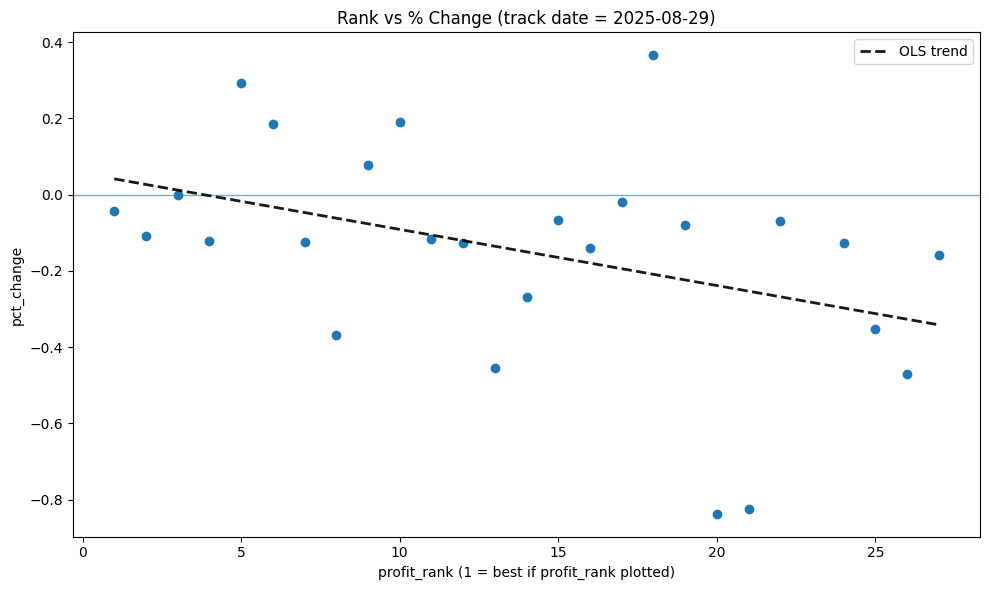

Pearson corr:  -0.407
Spearman corr: -0.467


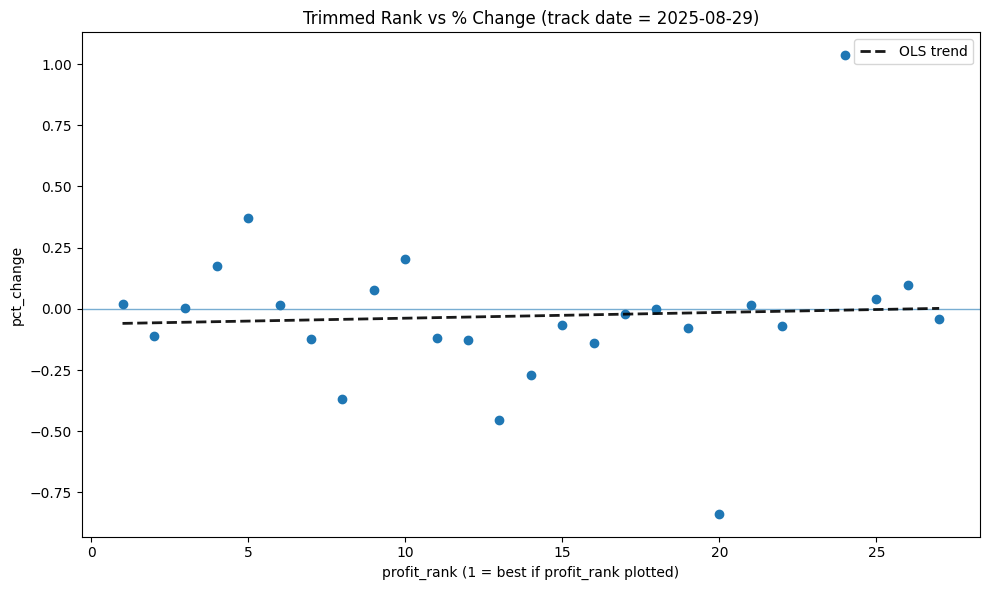

Pearson corr (trimmed):  +0.059
Spearman corr (trimmed): -0.028


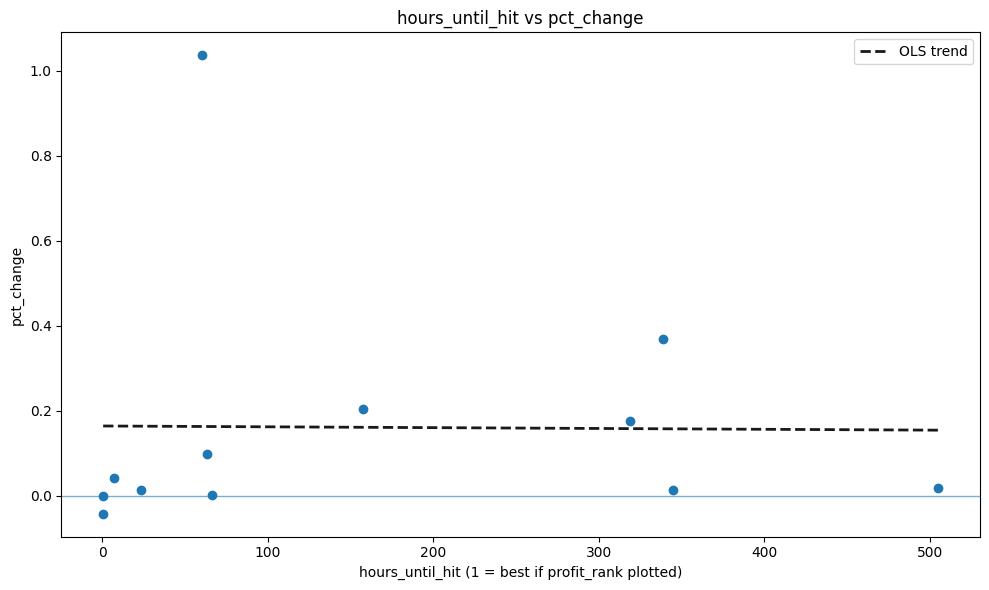

Pearson corr (trimmed):  -0.011
Spearman corr (trimmed): +0.431


In [101]:
print("Negative correlation coefficients indicate that better ranks correspond to higher price increases.")
print("Modify the outlier removal parameters as needed for visibility.")

# Remove outliers for visibility (e.g., keep 2nd–98th percentile of % changes)
rank_change_vis = remove_outliers(rank_change_df, col="pct_change", lo=-1, hi=2, use_quantiles=False)
trimmed_rank_change_vis = remove_outliers(trimmed_rank_change_df, col="pct_change", lo=-1, hi=2, use_quantiles=False)
trimmed_rank_change_with_hours_vis = remove_outliers(trimmed_rank_change_with_hours, col="pct_change", lo=-1, hi=2, use_quantiles=False)

plot_rank_vs_price_change(rank_change_vis, title=f"Rank vs % Change (track date = {track_profit_from})")

pearson = rank_change_vis[["profit_rank", "pct_change"]].corr(method="pearson").iloc[0, 1]
spearman = rank_change_vis[["profit_rank", "pct_change"]].corr(method="spearman").iloc[0, 1]
print(f"Pearson corr:  {pearson:+.3f}")
print(f"Spearman corr: {spearman:+.3f}")

plot_rank_vs_price_change(trimmed_rank_change_vis, title=f"Trimmed Rank vs % Change (track date = {track_profit_from})")

pearson_trimmed = trimmed_rank_change_vis[["profit_rank", "pct_change"]].corr(method="pearson").iloc[0, 1]
spearman_trimmed = trimmed_rank_change_vis[["profit_rank", "pct_change"]].corr(method="spearman").iloc[0, 1]
print(f"Pearson corr (trimmed):  {pearson_trimmed:+.3f}")
print(f"Spearman corr (trimmed): {spearman_trimmed:+.3f}")

plot_rank_vs_price_change(trimmed_rank_change_with_hours_vis, title=None, x_axis="hours_until_hit", y_axis="pct_change")

pearson_trimmed = trimmed_rank_change_with_hours_vis[["hours_until_hit", "pct_change"]].corr(method="pearson").iloc[0, 1]
spearman_trimmed = trimmed_rank_change_with_hours_vis[["hours_until_hit", "pct_change"]].corr(method="spearman").iloc[0, 1]
print(f"Pearson corr (trimmed):  {pearson_trimmed:+.3f}")
print(f"Spearman corr (trimmed): {spearman_trimmed:+.3f}")

### <h3 style="color:yellow;">Plot walk_forward results for selected tickers</h3>

In [102]:
def plot_walk_forward_pct_change_curves(track_from_date, base_dir="swing_trade_charts", save=False, daily_only=False, walk_forward_data="walk_forward_data"):
    """
    Plot walk_forward %-change curves per category, with a category-average overlay.

    For each swing-strength category under
    {swing_trade_charts}/swing_analysis_period_ending_{track_from_date}/walk_forward_data_{track_from_date}/,
    loads each ticker’s walk_forward series, computes percent change vs that ticker’s
    baseline (its most recent close in
    .../top_price_data_{track_from_date}/{category}_{track_from_date}/{ticker}.csv),
    plots all ticker curves together, and overlays a time-aligned average line.

    Args:
        track_from_date (str): Analysis period end date in "YYYY-MM-DD" used to resolve
            walk_forward_data_{track_from_date} and top_price_data_{track_from_date} folders.
        base_dir (str): Root directory that contains swing outputs. Default "swing_trade_charts".
        save (bool): If True, saves each category plot as a PNG under
            {base_dir}/swing_analysis_period_ending_{track_from_date}/walk_forward_charts_{track_from_date}/.
        daily_only (bool): If True, down-samples walk_forward data to the last close per day;
            if False, uses every 30-minute close.

    Returns:
        None. Displays one plot per category (and optionally saves it). 
    """
    base = Path(base_dir) / f"swing_analysis_period_ending_{track_from_date}"
    incub_root = base / f"{walk_forward_data}_{track_from_date}"
    top_root   = base / f"top_price_data_{track_from_date}"

    if not incub_root.exists():
        print(f"⚠️ walk_forward root not found: {incub_root}")
        return
    if not top_root.exists():
        print(f"⚠️ Top price root not found: {top_root}")
        return

    for category_folder in incub_root.iterdir():
        if not category_folder.is_dir():
            continue

        category = category_folder.name
        baseline_folder = top_root / f"{category}_{track_from_date}"
        if not baseline_folder.exists():
            print(f"⚠️ Baseline folder not found for category '{category}': {baseline_folder}")
            continue

        plt.figure(figsize=(14, 8))
        any_series = False
        avg_df = pd.DataFrame()  # to store all tickers' % change series

        for file in category_folder.glob("*.csv"):
            ticker = file.stem

            try:
                inc = pd.read_csv(file)
            except Exception as e:
                print(f"❌ Failed to read walk_forward CSV for {ticker} in {category}: {e}")
                continue

            baseline_csv = baseline_folder / f"{ticker}.csv"
            if not baseline_csv.exists():
                print(f"⚠️ Missing baseline for {ticker} in {category}: {baseline_csv}")
                continue

            try:
                base_df = pd.read_csv(baseline_csv)
            except Exception as e:
                print(f"❌ Failed to read baseline CSV for {ticker}: {e}")
                continue

            for df in (inc, base_df):
                if "date_time" not in df.columns:
                    print(f"⚠️ 'date_time' missing in {file if df is inc else baseline_csv}")
                    continue
                df["date_time"] = pd.to_datetime(df["date_time"], errors="coerce")

            try:
                base_close = (
                    base_df.sort_values("date_time")["close"]
                    .dropna()
                    .iloc[-1]
                )
            except Exception:
                print(f"⚠️ Could not compute baseline close for {ticker}")
                continue

            if {"open","high","low","close"}.issubset(inc.columns):
                inc = inc[~((inc["open"]==0) & (inc["high"]==0) & (inc["low"]==0) & (inc["close"]==0))]

            inc = inc.sort_values("date_time")

            if daily_only:
                # Keep only the last close per day
                inc = inc.groupby(inc["date_time"].dt.date).tail(1)

            if "close" not in inc.columns or inc["close"].dropna().empty:
                print(f"⚠️ No valid close series for {ticker} in {category}")
                continue

            try:
                pct_series = (inc["close"] - base_close) / base_close #* 100.0
                plt.plot(inc["date_time"], pct_series, label=ticker, linewidth=1)

                # Store for average calculation
                temp_df = pd.DataFrame({"date_time": inc["date_time"], ticker: pct_series})
                if avg_df.empty:
                    avg_df = temp_df
                else:
                    avg_df = pd.merge(avg_df, temp_df, on="date_time", how="outer")

                any_series = True
            except Exception as e:
                print(f"❌ Error computing % series for {ticker}: {e}")
                continue

        if not any_series:
            plt.close()
            print(f"ℹ️ No valid series to plot for category '{category}'.")
            continue

        # Compute running average line
        if not avg_df.empty:
            avg_df = avg_df.sort_values("date_time").set_index("date_time")
            avg_df["average_pct_change"] = avg_df.mean(axis=1, skipna=True)
            plt.plot(avg_df.index, avg_df["average_pct_change"], color="black", linewidth=2.5, label="Category Avg", alpha=0.8)

        plt.axhline(0, linewidth=1, alpha=0.6)
        freq_label = "Daily Close" if daily_only else "30m Close"
        plt.title(f"{category.upper()} — Change since {track_from_date} ({freq_label})")
        plt.ylabel("% from baseline close")
        plt.xlabel("Date/Time")
        plt.tight_layout()
        plt.legend(ncol=2, fontsize=9)

        if save:
            out_dir = base / f"walk_forward_charts_{track_from_date}"
            out_dir.mkdir(parents=True, exist_ok=True)
            suffix = "_daily" if daily_only else "_30m"
            out_path = out_dir / f"{category}_{track_from_date}_pct_change{suffix}.png"
            plt.savefig(out_path, dpi=200, bbox_inches="tight")
            print(f"💾 Saved: {out_path}")

        plt.show()

In [103]:
# plot_walk_forward_pct_change_curves(track_from_date=track_profit_from, base_dir="swing_trade_charts", save=True, daily_only=True, walk_forward_data="walk_forward_data_trimmed")

In [104]:
# plot_walk_forward_pct_change_curves(track_from_date=track_profit_from, base_dir="swing_trade_charts", save=True, daily_only=True, walk_forward_data="walk_forward_data")
# plot_walk_forward_pct_change_curves(track_from_date=track_profit_from, base_dir="swing_trade_charts", save=True, daily_only=False)

In [105]:
# --- END TIMER (bottom of notebook) ---
elapsed = perf_counter() - _NOTEBOOK_T0
print(f"Total runtime: {elapsed:.2f} seconds ({elapsed/60:.2f} minutes) "
      f"since {_NOTEBOOK_START_TS:%Y-%m-%d %H:%M:%S}")

Total runtime: 294.46 seconds (4.91 minutes) since 2025-12-31 11:47:25


## <h2 style="color:purple;">Train Weighting on Walk-Forward Price Delta</h2>

### <h3 style="color:yellow;">Create DataFrame with walk-forward price delta and weighting metrics</h3>

In [106]:
print("price_change_results:")
display(price_change_results)
print("final_results_dict_schwab:")
display(final_results_dict_schwab)
print("rank_change_df:")
display(rank_change_df)

price_change_results:


{'high': {'FA': -0.11739915713425643,
  'FLYW': 0.07882711348057869,
  'MDLZ': -0.12402849740932638,
  'NWL': -0.36661073825503354,
  'SRPT': 0.18948521358159895},
 'low': {'DFLI': -0.07967454712926007,
  'GRI': -0.8230985915492959,
  'HCWB': -0.8364779874213837,
  'HRZN': -0.068840579710145,
  'PLAB': 0.365813377374071},
 'medium': {'AGMH': -0.019512195121951237,
  'AMTX': -0.45515384615384613,
  'CPB': -0.12667289137877383,
  'DJT': -0.2684931506849315,
  'SAVA': -0.14043290043290044,
  'SBAC': -0.06748318924111424},
 'very_high': {'CENT': -0.10874965498205902,
  'NRDS': 0.2937357414448669,
  'PAL': 0.1848225214198286,
  'PEBO': -0.043075941289087476,
  'STGW': -0.12210338680926924,
  'VRIG': 0.00019920318725095637},
 'very_low': {'ACHC': -0.35191011235955055,
  'GCTK': -0.1261486486486487,
  'GLMD': -0.4709219858156028,
  'GPRE': -0.15848406546080965,
  'SMST': 2.3585465331850206},
 'zero': {'AAPL': 0.18338965427605922,
  'AFRM': -0.04031948881789139,
  'ALKT': -0.10039215686274505,

final_results_dict_schwab:


{'AAPL':   ticker analysis_period_start analysis_period_end evaluation_period_start evaluation_period_end incubation_period_start incubation_period_end  analysis_buy  analysis_sell  analysis_return  analysis_trades  analysis_eval_metric  evaluation_return  evaluation_trades  evaluation_data_good  incubation_return  incubation_trades  incubation_data_good  analysis_avg_trade_duration  current_price_below_lb  percent_below_lb  current_price_below_ub  percent_below_ub  current_price_between_bounds  num_days_below_lb  num_days_below_ub date_began_below_lb date_began_below_ub  trend_slope  norm_trend_slope  slope_below_ub  norm_slope_below_ub  slope_below_lb  norm_slope_below_lb  cyclicality  analysis_period_pct_change  compression_ratio  trend_persistence  range_shrink  compression_in_trend  rs_vs_median    rs_z  implied_gain_pct  max_days_simple exit_by_date_simple  annual_simple_from_avg_duration  profit_score  profit_rank swing_probability  current_price_below_ub_weight  percent_below_u

rank_change_df:


,ticker,category,profit_rank,pct_change
0,FA,high,11.0000,-0.1174
1,FLYW,high,9.0000,0.0788
2,MDLZ,high,7.0000,-0.1240
3,NWL,high,8.0000,-0.3666
4,SRPT,high,10.0000,0.1895
5,DFLI,low,19.0000,-0.0797
6,GRI,low,21.0000,-0.8231
7,HCWB,low,20.0000,-0.8365
8,HRZN,low,22.0000,-0.0688
9,PLAB,low,18.0000,0.3658


In [107]:
# Sort rank_change_df by pct_change descending
rank_change_df_pct_change_desc = rank_change_df.sort_values(by="pct_change", ascending=False)

# Rewrite profit_rank to follow this actual order of performance
rank_change_df_pct_change_desc["profit_rank"] = range(1, len(rank_change_df_pct_change_desc) + 1)
display(rank_change_df_pct_change_desc)

,ticker,category,profit_rank,pct_change
26,SMST,very_low,1,2.3585
9,PLAB,low,2,0.3658
17,NRDS,very_high,3,0.2937
4,SRPT,high,4,0.1895
18,PAL,very_high,5,0.1848
1,FLYW,high,6,0.0788
21,VRIG,very_high,7,0.0002
10,AGMH,medium,8,-0.0195
19,PEBO,very_high,9,-0.0431
15,SBAC,medium,10,-0.0675


Negative correlation coefficients indicate that better ranks correspond to higher price increases.
Modify the outlier removal parameters as needed for visibility.


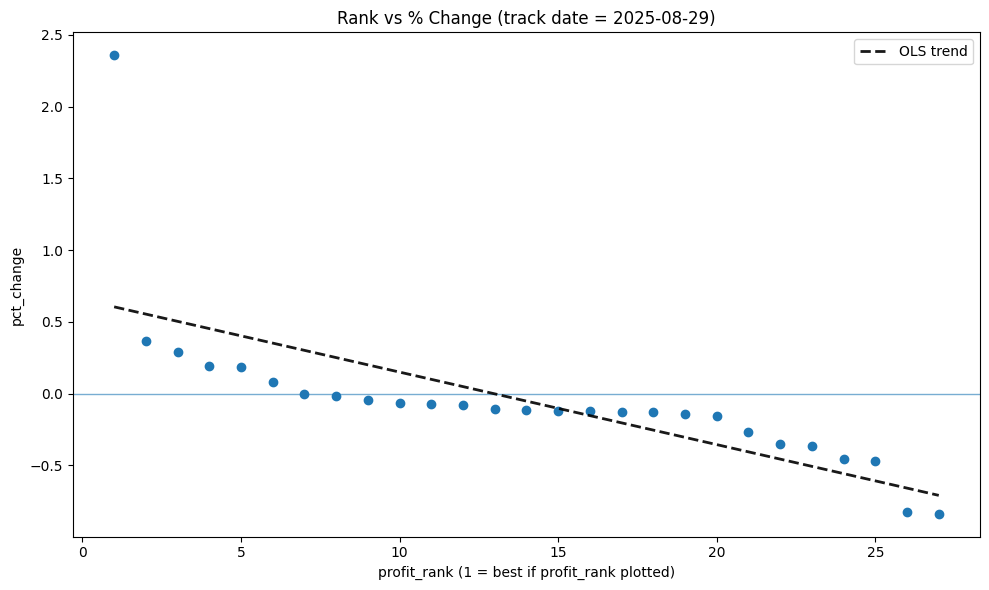

Pearson corr:  -0.720
Spearman corr: -1.000


In [108]:
print("Negative correlation coefficients indicate that better ranks correspond to higher price increases.")
print("Modify the outlier removal parameters as needed for visibility.")

plot_rank_vs_price_change(rank_change_df_pct_change_desc, title=f"Rank vs % Change (track date = {track_profit_from})")

pearson = rank_change_df_pct_change_desc[["profit_rank", "pct_change"]].corr(method="pearson").iloc[0, 1]
spearman = rank_change_df_pct_change_desc[["profit_rank", "pct_change"]].corr(method="spearman").iloc[0, 1]
print(f"Pearson corr:  {pearson:+.3f}")
print(f"Spearman corr: {spearman:+.3f}")

In [109]:
suffix = "lb" if bound_reference_schwab == "lower" else "ub"
metric_cols = [
    f"current_price_below_{suffix}",
    f"percent_below_{suffix}",
    f"num_days_below_{suffix}",
    "cyclicality",
    "norm_trend_slope",
    f"norm_slope_below_{suffix}",
    "compression_ratio",
    "trend_persistence",
    "range_shrink",
    "compression_in_trend"
]

rows = []
for ticker, df in final_results_dict_schwab.items():
    row = df[df["analysis_period_end"] == track_profit_from]
    r = row.iloc[0]
    rows.append({"ticker": ticker, **{col: r[col] for col in metric_cols}})

metrics_df = pd.DataFrame(rows)
score_metrics_train_set = rank_change_df_pct_change_desc.merge(metrics_df, on="ticker", how="left")
display(score_metrics_train_set)

,ticker,category,profit_rank,pct_change,current_price_below_ub,percent_below_ub,num_days_below_ub,cyclicality,norm_trend_slope,norm_slope_below_ub,compression_ratio,trend_persistence,range_shrink,compression_in_trend
0,SMST,very_low,1,2.3585,1.0000,0.7946,119,0.0168,-0.0111,-0.0090,0.8129,0.6500,1.1233,-0.7996
1,PLAB,low,2,0.3658,1.0000,0.0653,1,0.0448,-0.0003,NaN,0.9186,0.5500,1.1707,-0.5987
2,NRDS,very_high,3,0.2937,1.0000,0.2862,142,0.0443,-0.0002,0.0001,1.0671,0.6000,1.0748,-0.5623
3,SRPT,high,4,0.1895,1.0000,0.1765,31,0.0228,-0.0011,0.0099,0.2092,0.5000,0.8123,-2.3898
4,PAL,very_high,5,0.1848,1.0000,0.0526,2,0.0419,-0.0022,0.0000,1.4000,0.3500,1.0400,-0.2500
5,FLYW,high,6,0.0788,1.0000,0.2592,129,0.0282,-0.0013,0.0014,0.9987,0.6500,1.2130,-0.6509
6,VRIG,very_high,7,0.0002,1.0000,0.0021,10,0.0442,0.0000,0.0002,0.9982,0.6000,1.0667,0.6011
7,AGMH,medium,8,-0.0195,1.0000,0.9818,227,0.0414,-0.0024,-0.0103,0.4268,0.5500,0.8375,-1.2887
8,PEBO,very_high,9,-0.0431,1.0000,0.0338,28,0.0587,0.0001,0.0018,0.8951,0.6000,0.8767,0.6703
9,SBAC,medium,10,-0.0675,1.0000,0.0894,5,0.0650,0.0001,-0.0218,0.7701,0.4000,0.9983,0.5194


### <h3 style="color:yellow;">Train prediction metric weighting on price delta</h3>

#### <h4 style="color:limegreen;">Grid Search Weighting</h4>

Version 1: Pandas heavy. Just works. Takes a long time.

In [110]:
df = score_metrics_train_set.copy()
suffix = "lb" if bound_reference_schwab == "lower" else "ub"

metric_cols = [
    # f"percent_below_{suffix}",
    # f"num_days_below_{suffix}",
    "cyclicality",
    "norm_trend_slope",
    f"norm_slope_below_{suffix}",
    "compression_ratio",
    "trend_persistence",
    "range_shrink",
    "compression_in_trend"
]

grid = {
    # "w_percent": np.linspace(0, 1, 6),
    # "w_days":    np.linspace(0, 1, 6),
    "w_cyc":     np.linspace(0, 1, 6),
    "w_trend":   np.linspace(0, 1, 6),
    "w_norm":    np.linspace(0, 1, 6),
    "w_comp_ratio":    np.linspace(0, 1, 6),
    "w_trend_persist":     np.linspace(0, 1, 6),
    "w_range_shrink":   np.linspace(0, 1, 6),
    "w_comp_in_trend":    np.linspace(0, 1, 6),
}

# rank-transform metrics
# df["_r_percent"]        = df[metric_cols[0]].rank(pct=True)
# df["_r_days"]           = df[metric_cols[1]].rank(pct=True)
df["_r_cyc"]            = df["cyclicality"].rank(pct=True)
df["_r_trend"]          = df["norm_trend_slope"].rank(pct=True)
df["_r_norm_below"]     = df[f"norm_slope_below_{suffix}"].rank(pct=True)
df["_r_comp_ratio"]     = df["compression_ratio"].rank(pct=True, ascending=False)   # lower compression_ratio = better
df["_r_trend_persist"]  = df["trend_persistence"].rank(pct=True)
df["_r_range_shrink"]   = df["range_shrink"].rank(pct=True, ascending=False)        # lower range_shrink = better
df["_r_comp_in_trend"]  = df["compression_in_trend"].rank(pct=True)

display(metric_cols)
display(grid)
display(df)

best_spearman = None
best_spearman_weights = None
best_pearson = None
best_pearson_weights = None

mask_current = df[f"current_price_below_{suffix}"].fillna(0).astype(float)
y = df["pct_change"].astype(float)

for (
    # w_percent,
    #  w_days,
     w_cyc,
     w_trend,
     w_norm,
     w_comp_ratio,
     w_trend_persist,
     w_range_shrink,
     w_comp_in_trend) in itertools.product(*grid.values()):

    score = mask_current * (
        # df["_r_percent"]        * w_percent +
        # df["_r_days"]           * w_days +
        df["_r_cyc"]            * w_cyc +
        df["_r_trend"]          * w_trend +
        df["_r_norm_below"]     * w_norm +
        df["_r_comp_ratio"]     * w_comp_ratio +
        df["_r_trend_persist"]  * w_trend_persist +
        df["_r_range_shrink"]   * w_range_shrink +
        df["_r_comp_in_trend"]  * w_comp_in_trend
    )

    spearman = score.corr(y, method="spearman")
    pearson  = score.corr(y, method="pearson")

    if pd.notna(spearman) and (best_spearman is None or spearman > best_spearman):
        best_spearman = spearman
        best_spearman_weights = {
            # f"percent_below_{suffix}":        w_percent,
            # f"num_days_below_{suffix}":       w_days,
            "cyclicality":                    w_cyc,
            "norm_trend_slope":               w_trend,
            f"norm_slope_below_{suffix}":     w_norm,
            "compression_ratio":              w_comp_ratio,
            "trend_persistence":              w_trend_persist,
            "range_shrink":                   w_range_shrink,
            "compression_in_trend":           w_comp_in_trend,
        }

    if pd.notna(pearson) and (best_pearson is None or pearson > best_pearson):
        best_pearson = pearson
        best_pearson_weights = {
            # f"percent_below_{suffix}":        w_percent,
            # f"num_days_below_{suffix}":       w_days,
            "cyclicality":                    w_cyc,
            "norm_trend_slope":               w_trend,
            f"norm_slope_below_{suffix}":     w_norm,
            "compression_ratio":              w_comp_ratio,
            "trend_persistence":              w_trend_persist,
            "range_shrink":                   w_range_shrink,
            "compression_in_trend":           w_comp_in_trend,
        }

print("Ranked before applying Pearson:")
print("best Spearman:", best_spearman)
print("spearman weights:", best_spearman_weights, "\n")
print("Standard correlation coefficient:")
print("best Pearson:", best_pearson)
print("pearson weights:", best_pearson_weights)

['cyclicality',
 'norm_trend_slope',
 'norm_slope_below_ub',
 'compression_ratio',
 'trend_persistence',
 'range_shrink',
 'compression_in_trend']

{'w_cyc': array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 'w_trend': array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 'w_norm': array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 'w_comp_ratio': array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 'w_trend_persist': array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 'w_range_shrink': array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 'w_comp_in_trend': array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])}

,ticker,category,profit_rank,pct_change,current_price_below_ub,percent_below_ub,num_days_below_ub,cyclicality,norm_trend_slope,norm_slope_below_ub,compression_ratio,trend_persistence,range_shrink,compression_in_trend,_r_cyc,_r_trend,_r_norm_below,_r_comp_ratio,_r_trend_persist,_r_range_shrink,_r_comp_in_trend
0,SMST,very_low,1,2.3585,1.0000,0.7946,119,0.0168,-0.0111,-0.0090,0.8129,0.6500,1.1233,-0.7996,0.0741,0.0370,0.2083,0.3704,0.9444,0.2593,0.4444
1,PLAB,low,2,0.3658,1.0000,0.0653,1,0.0448,-0.0003,NaN,0.9186,0.5500,1.1707,-0.5987,0.7778,0.6667,NaN,0.2963,0.7037,0.1852,0.6667
2,NRDS,very_high,3,0.2937,1.0000,0.2862,142,0.0443,-0.0002,0.0001,1.0671,0.6000,1.0748,-0.5623,0.7407,0.7778,0.7917,0.1481,0.8519,0.2963,0.7037
3,SRPT,high,4,0.1895,1.0000,0.1765,31,0.0228,-0.0011,0.0099,0.2092,0.5000,0.8123,-2.3898,0.2222,0.4815,1.0000,0.9630,0.4815,0.8519,0.0370
4,PAL,very_high,5,0.1848,1.0000,0.0526,2,0.0419,-0.0022,0.0000,1.4000,0.3500,1.0400,-0.2500,0.6296,0.2963,0.7500,0.0370,0.0556,0.4444,0.8148
5,FLYW,high,6,0.0788,1.0000,0.2592,129,0.0282,-0.0013,0.0014,0.9987,0.6500,1.2130,-0.6509,0.3704,0.4074,0.8750,0.2222,0.9444,0.1111,0.5556
6,VRIG,very_high,7,0.0002,1.0000,0.0021,10,0.0442,0.0000,0.0002,0.9982,0.6000,1.0667,0.6011,0.7037,0.8519,0.8333,0.2593,0.8519,0.3333,0.8889
7,AGMH,medium,8,-0.0195,1.0000,0.9818,227,0.0414,-0.0024,-0.0103,0.4268,0.5500,0.8375,-1.2887,0.5926,0.1852,0.1667,0.7037,0.7037,0.7778,0.2593
8,PEBO,very_high,9,-0.0431,1.0000,0.0338,28,0.0587,0.0001,0.0018,0.8951,0.6000,0.8767,0.6703,0.9630,0.9630,0.9167,0.3333,0.8519,0.7037,0.9259
9,SBAC,medium,10,-0.0675,1.0000,0.0894,5,0.0650,0.0001,-0.0218,0.7701,0.4000,0.9983,0.5194,1.0000,0.9259,0.0833,0.4074,0.1667,0.4815,0.8519


Ranked before applying Pearson:
best Spearman: 0.5130434782608695
spearman weights: {'cyclicality': 0.4, 'norm_trend_slope': 0.0, 'norm_slope_below_ub': 0.4, 'compression_ratio': 0.0, 'trend_persistence': 1.0, 'range_shrink': 0.2, 'compression_in_trend': 0.0} 

Standard correlation coefficient:
best Pearson: 0.3689831113663706
pearson weights: {'cyclicality': 0.0, 'norm_trend_slope': 0.0, 'norm_slope_below_ub': 0.0, 'compression_ratio': 0.0, 'trend_persistence': 0.6000000000000001, 'range_shrink': 0.0, 'compression_in_trend': 0.0}


In [111]:
# Ranked before applying Pearson:
# best Spearman: 0.23819772105092213
# spearman weights: {'cyclicality': 1.0, 'norm_trend_slope': 0.6000000000000001, 'norm_slope_below_ub': 0.2, 'compression_ratio': 0.4, 'trend_persistence': 0.6000000000000001, 'range_shrink': 0.2, 'compression_in_trend': 0.2} 

# Standard correlation coefficient:
# best Pearson: 0.16323760303835722
# pearson weights: {'cyclicality': 1.0, 'norm_trend_slope': 0.4, 'norm_slope_below_ub': 0.6000000000000001, 'compression_ratio': 0.4, 'trend_persistence': 0.6000000000000001, 'range_shrink': 0.2, 'compression_in_trend': 0.2}

# Ranked before applying Pearson:
# best Spearman: 0.26799562279219713
# spearman weights: {'cyclicality': 0.8, 'norm_trend_slope': 0.4, 'norm_slope_below_ub': 0.6000000000000001, 'compression_ratio': 0.4, 'trend_persistence': 0.6000000000000001, 'range_shrink': 0.0, 'compression_in_trend': 0.2} 

# Standard correlation coefficient:
# best Pearson: 0.16996300567237121
# pearson weights: {'cyclicality': 0.8, 'norm_trend_slope': 0.2, 'norm_slope_below_ub': 0.4, 'compression_ratio': 0.2, 'trend_persistence': 0.8, 'range_shrink': 0.2, 'compression_in_trend': 0.0}

Version 2: Uses Numpy. Drops some data. Much Faster.

In [112]:
from scipy.stats import rankdata

df = score_metrics_train_set.copy()
suffix = "lb" if bound_reference_schwab == "lower" else "ub"

metric_cols = [
    "cyclicality",
    "norm_trend_slope",
    f"norm_slope_below_{suffix}",
    "compression_ratio",
    "trend_persistence",
    "range_shrink",
    "compression_in_trend",
]

grid = {
    "w_cyc":            np.linspace(0, 1, 6),
    "w_trend":          np.linspace(0, 1, 6),
    "w_norm":           np.linspace(0, 1, 6),
    "w_comp_ratio":     np.linspace(0, 1, 6),
    "w_trend_persist":  np.linspace(0, 1, 6),
    "w_range_shrink":   np.linspace(0, 1, 6),
    "w_comp_in_trend":  np.linspace(0, 1, 6),
}

# rank-transform metrics (pandas once)
df["_r_cyc"]            = df["cyclicality"].rank(pct=True)
df["_r_trend"]          = df["norm_trend_slope"].rank(pct=True)
df["_r_norm_below"]     = df[metric_cols[2]].rank(pct=True)
df["_r_comp_ratio"]     = df["compression_ratio"].rank(pct=True, ascending=False)
df["_r_trend_persist"]  = df["trend_persistence"].rank(pct=True)
df["_r_range_shrink"]   = df["range_shrink"].rank(pct=True, ascending=False)
df["_r_comp_in_trend"]  = df["compression_in_trend"].rank(pct=True)

mask = df[f"current_price_below_{suffix}"].fillna(0).astype(float).to_numpy()
y    = df["pct_change"].astype(float).to_numpy()

R = np.column_stack([
    df["_r_cyc"].to_numpy(),
    df["_r_trend"].to_numpy(),
    df["_r_norm_below"].to_numpy(),
    df["_r_comp_ratio"].to_numpy(),
    df["_r_trend_persist"].to_numpy(),
    df["_r_range_shrink"].to_numpy(),
    df["_r_comp_in_trend"].to_numpy(),
]).astype(float)

# drop any row with non-finite inputs
valid = np.isfinite(y) & np.isfinite(mask) & np.isfinite(R).all(axis=1)
mask = mask[valid]
y    = y[valid]
R    = R[valid]

def pearson_np(x, y):
    v = np.isfinite(x) & np.isfinite(y)
    if v.sum() < 2: return np.nan
    xv = x[v]; yv = y[v]
    xm = xv.mean(); ym = yv.mean()
    xs = xv - xm; ys = yv - ym
    num = np.dot(xs, ys)
    den = np.sqrt(np.dot(xs, xs) * np.dot(ys, ys))
    return num / den if den > 0 else np.nan

def spearman_np(x, y):
    v = np.isfinite(x) & np.isfinite(y)
    if v.sum() < 2: return np.nan
    xv = x[v]; yv = y[v]
    xr = rankdata(xv); yr = rankdata(yv)
    return pearson_np(xr, yr)

best_spearman = None
best_spearman_weights = None
best_pearson = None
best_pearson_weights = None

for (
    w_cyc,
    w_trend,
    w_norm,
    w_comp_ratio,
    w_trend_persist,
    w_range_shrink,
    w_comp_in_trend,
) in itertools.product(*grid.values()):

    w = np.array([
        w_cyc,
        w_trend,
        w_norm,
        w_comp_ratio,
        w_trend_persist,
        w_range_shrink,
        w_comp_in_trend,
    ], dtype=float)

    score = mask * (R @ w)

    spearman = spearman_np(score, y)
    pearson  = pearson_np(score, y)

    if not np.isnan(spearman) and (best_spearman is None or spearman > best_spearman):
        best_spearman = spearman
        best_spearman_weights = {
            "cyclicality":                w_cyc,
            "norm_trend_slope":           w_trend,
            f"norm_slope_below_{suffix}": w_norm,
            "compression_ratio":          w_comp_ratio,
            "trend_persistence":          w_trend_persist,
            "range_shrink":               w_range_shrink,
            "compression_in_trend":       w_comp_in_trend,
        }

    if not np.isnan(pearson) and (best_pearson is None or pearson > best_pearson):
        best_pearson = pearson
        best_pearson_weights = {
            "cyclicality":                w_cyc,
            "norm_trend_slope":           w_trend,
            f"norm_slope_below_{suffix}": w_norm,
            "compression_ratio":          w_comp_ratio,
            "trend_persistence":          w_trend_persist,
            "range_shrink":               w_range_shrink,
            "compression_in_trend":       w_comp_in_trend,
        }

print("Ranked before applying Pearson:")
print("best Spearman:", best_spearman)
print("spearman weights:", best_spearman_weights, "\n")
print("Standard correlation coefficient:")
print("best Pearson:", best_pearson)
print("pearson weights:", best_pearson_weights)


Ranked before applying Pearson:
best Spearman: 0.5130434782608696
spearman weights: {'cyclicality': 0.4, 'norm_trend_slope': 0.0, 'norm_slope_below_ub': 0.4, 'compression_ratio': 0.0, 'trend_persistence': 1.0, 'range_shrink': 0.2, 'compression_in_trend': 0.0} 

Standard correlation coefficient:
best Pearson: 0.3689831113663706
pearson weights: {'cyclicality': 0.0, 'norm_trend_slope': 0.0, 'norm_slope_below_ub': 0.0, 'compression_ratio': 0.0, 'trend_persistence': 0.6000000000000001, 'range_shrink': 0.0, 'compression_in_trend': 0.0}


In [113]:
print("mask any >0:", (mask > 0).any())
print("y finite rows:", np.isfinite(y).sum())
print("R shape:", R.shape)

mask any >0: True
y finite rows: 24
R shape: (24, 7)


Version 3: Like version 1, but uses parallel processing. Actually slower, and produces same output as Version 2 somehow.

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed

df = score_metrics_train_set.copy()
suffix = "lb" if bound_reference_schwab == "lower" else "ub"

# ---------------------- everything here stays unchanged ----------------------
metric_cols = [
    "cyclicality",
    "norm_trend_slope",
    f"norm_slope_below_{suffix}",
    "compression_ratio",
    "trend_persistence",
    "range_shrink",
    "compression_in_trend"
]

grid = {
    "w_cyc":            np.linspace(0, 1, 6),
    "w_trend":          np.linspace(0, 1, 6),
    "w_norm":           np.linspace(0, 1, 6),
    "w_comp_ratio":     np.linspace(0, 1, 6),
    "w_trend_persist":  np.linspace(0, 1, 6),
    "w_range_shrink":   np.linspace(0, 1, 6),
    "w_comp_in_trend":  np.linspace(0, 1, 6),
}

df["_r_cyc"]            = df["cyclicality"].rank(pct=True)
df["_r_trend"]          = df["norm_trend_slope"].rank(pct=True)
df["_r_norm_below"]     = df[metric_cols[2]].rank(pct=True)
df["_r_comp_ratio"]     = df["compression_ratio"].rank(pct=True, ascending=False)
df["_r_trend_persist"]  = df["trend_persistence"].rank(pct=True)
df["_r_range_shrink"]   = df["range_shrink"].rank(pct=True, ascending=False)
df["_r_comp_in_trend"]  = df["compression_in_trend"].rank(pct=True)

mask_current = df[f"current_price_below_{suffix}"].fillna(0).astype(float)
y = df["pct_change"].astype(float)
# ----------------------------------------------------------------------------


# ----------------------------- NEW: worker --------------------------------
def eval_combo(params):
    (
        w_cyc,
        w_trend,
        w_norm,
        w_comp_ratio,
        w_trend_persist,
        w_range_shrink,
        w_comp_in_trend
    ) = params

    score = mask_current * (
        df["_r_cyc"]            * w_cyc +
        df["_r_trend"]          * w_trend +
        df["_r_norm_below"]     * w_norm +
        df["_r_comp_ratio"]     * w_comp_ratio +
        df["_r_trend_persist"]  * w_trend_persist +
        df["_r_range_shrink"]   * w_range_shrink +
        df["_r_comp_in_trend"]  * w_comp_in_trend
    )

    spearman = score.corr(y, method="spearman")
    pearson  = score.corr(y, method="pearson")

    weights = {
        "cyclicality":                    w_cyc,
        "norm_trend_slope":               w_trend,
        f"norm_slope_below_{suffix}":     w_norm,
        "compression_ratio":              w_comp_ratio,
        "trend_persistence":              w_trend_persist,
        "range_shrink":                   w_range_shrink,
        "compression_in_trend":           w_comp_in_trend,
    }

    return spearman, pearson, weights
# ---------------------------------------------------------------------------


# ------------------------- NEW: parallel loop ------------------------------
combos = list(itertools.product(*grid.values()))

best_spearman = None
best_spearman_weights = None
best_pearson = None
best_pearson_weights = None

with ThreadPoolExecutor(max_workers=16) as executor:
    futures = [executor.submit(eval_combo, c) for c in combos]

    for f in as_completed(futures):
        spearman, pearson, weights = f.result()

        if pd.notna(spearman) and (best_spearman is None or spearman > best_spearman):
            best_spearman = spearman
            best_spearman_weights = weights

        if pd.notna(pearson) and (best_pearson is None or pearson > best_pearson):
            best_pearson = pearson
            best_pearson_weights = weights
# ---------------------------------------------------------------------------


print("Ranked before applying Pearson:")
print("best Spearman:", best_spearman)
print("spearman weights:", best_spearman_weights, "\n")
print("Standard correlation coefficient:")
print("best Pearson:", best_pearson)
print("pearson weights:", best_pearson_weights)

#### <h4 style="color:limegreen;">Gradient-Free Optimizer</h4>

In [ ]:
df = score_metrics_train_set.copy()
suffix = "lb" if bound_reference_schwab == "lower" else "ub"

# rank features (UPDATED)
df["_r_cyc"]        = df["cyclicality"].rank(pct=True)
df["_r_trend"]      = df["norm_trend_slope"].rank(pct=True)
df["_r_norm_below"] = df[f"norm_slope_below_{suffix}"].rank(pct=True)

# NEW FEATURE RANKS
df["_r_comp_ratio"]     = df["compression_ratio"].rank(pct=True)
df["_r_trend_persist"]  = df["trend_persistence"].rank(pct=True)
df["_r_range_shrink"]   = df["range_shrink"].rank(pct=True)
df["_r_comp_in_trend"]  = df["compression_in_trend"].rank(pct=True)

# fill NA
df[[
    "_r_cyc","_r_trend","_r_norm_below",
    "_r_comp_ratio","_r_trend_persist","_r_range_shrink","_r_comp_in_trend"
]] = df[[
    "_r_cyc","_r_trend","_r_norm_below",
    "_r_comp_ratio","_r_trend_persist","_r_range_shrink","_r_comp_in_trend"
]].fillna(0)

mask = df[f"current_price_below_{suffix}"].fillna(0).astype(float)
y = df["pct_change"].astype(float)

# UPDATED SCORE FUNCTION
def make_score(w):
    return mask * (
        df["_r_cyc"]            * w[0] +
        df["_r_trend"]          * w[1] +
        df["_r_norm_below"]     * w[2] +
        df["_r_comp_ratio"]     * w[3] +
        df["_r_trend_persist"]  * w[4] +
        df["_r_range_shrink"]   * w[5] +
        df["_r_comp_in_trend"]  * w[6]
    )

def loss_spearman(w):
    score = make_score(w)
    if score.nunique() <= 1: return 1
    c = score.corr(y, method="spearman")
    return -c if pd.notna(c) else 1

def loss_pearson(w):
    score = make_score(w)
    if score.nunique() <= 1: return 1
    c = score.corr(y, method="pearson")
    return -c if pd.notna(c) else 1

# 7 weights now
w0 = np.array([0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25])

# --- Optimize Spearman ---
res_spear = minimize(loss_spearman, w0, method="Nelder-Mead")
best_w_spear = res_spear.x
best_corr_spear = -res_spear.fun

# --- Optimize Pearson ---
res_pear = minimize(loss_pearson, w0, method="Nelder-Mead")
best_w_pear = res_pear.x
best_corr_pear = -res_pear.fun

# Format
best_weights_spear = {
    "cyclicality":                best_w_spear[0],
    "norm_trend_slope":           best_w_spear[1],
    f"norm_slope_below_{suffix}": best_w_spear[2],
    "compression_ratio":          best_w_spear[3],
    "trend_persistence":          best_w_spear[4],
    "range_shrink":               best_w_spear[5],
    "compression_in_trend":       best_w_spear[6],
}

best_weights_pear = {
    "cyclicality":                best_w_pear[0],
    "norm_trend_slope":           best_w_pear[1],
    f"norm_slope_below_{suffix}": best_w_pear[2],
    "compression_ratio":          best_w_pear[3],
    "trend_persistence":          best_w_pear[4],
    "range_shrink":               best_w_pear[5],
    "compression_in_trend":       best_w_pear[6],
}

print("=== BEST SPEARMAN ===")
print("Corr:", best_corr_spear)
for k, v in best_weights_spear.items(): print(f"{k}: {v:.6f}")

print("\n=== BEST PEARSON ===")
print("Corr:", best_corr_pear)
for k, v in best_weights_pear.items(): print(f"{k}: {v:.6f}")

In [ ]:
# === BEST SPEARMAN ===
# Corr: 0.2750050246198559
# percent_below_ub: -1.464833
# num_days_below_ub: 0.509937
# cyclicality: 1.698058
# norm_trend_slope: 0.490085
# norm_slope_below_ub: 0.435297

# === BEST PEARSON ===
# Corr: 0.12494285064317927
# percent_below_ub: -0.650536
# num_days_below_ub: -3.275984
# cyclicality: 6.648438
# norm_trend_slope: 3.000773
# norm_slope_below_ub: 1.579457

#### <h4 style="color:limegreen;">Gradient Boosted Tree Model</h4>

In [ ]:
df = score_metrics_train_set

X = df[metric_cols].astype(float).values
y = df["pct_change"].astype(float).values

In [ ]:
from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=400,
    max_depth=3,
    learning_rate=0.03,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
)
model.fit(X, y)

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

pred = model.predict(X)

X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

lin = LinearRegression().fit(X, pred)
weights = lin.coef_

In [ ]:
for col, w in zip(metric_cols, weights):
    print(col, " : ", w)

In [ ]:
# percent_below_ub  :  -0.19959749368007285
# num_days_below_ub  :  -0.002901600955901323
# cyclicality  :  1.6353881863176325
# norm_trend_slope  :  2.739874907577209
# norm_slope_below_ub  :  2.0909558049562222

# percent_below_ub  :  -0.20654054977786282
# num_days_below_ub  :  -0.0025866111745405903
# cyclicality  :  2.2871838975457424
# norm_trend_slope  :  3.745013338519993
# norm_slope_below_ub  :  2.105614649178072

In [ ]:
# --- Compute weighted score using the derived weights ---
df = score_metrics_train_set.copy()

df["model_score"] = (df[metric_cols].astype(float).values * weights).sum(axis=1)

# --- Compute Spearman & Pearson correlations against pct_change ---
spearman_corr = df["model_score"].corr(df["pct_change"], method="spearman")
pearson_corr  = df["model_score"].corr(df["pct_change"], method="pearson")


print("\nCorrelation Results for XGBoost-derived Weights:")
print("Ranked before applying Pearson:")
print("Spearman correlation:", spearman_corr)
print("Standard correlation coefficient")
print("Pearson correlation :", pearson_corr)

In [ ]:
# Correlation Results for XGBoost-derived Weights:
# Ranked before applying Pearson:
# Spearman correlation: 0.2715737717229747
# Standard correlation coefficient
# Pearson correlation : 0.19264511236732548

## Code in Progress

### OOP practice

In [ ]:
class Vec2:                     # 1. define a new type called Vec2
    def __init__(self, x, y):   # 2. how to build one (the constructor)
        self.x = x
        self.y = y

    def __add__(self, other):   # 3. how to do v1 + v2
        return Vec2(self.x + other.x, self.y + other.y)

    def __len__(self):          # 4. how len(v) works
        return 2  # It's always 2D

    def __repr__(self):         # 5. how it prints / shows up in the console
        return f"Vec2({self.x}, {self.y})"

a = Vec2(2, 3)                  # 6. make a vector
b = Vec2(5, 1)                  # 7. make another vector
c = Vec2(25, 10)

# Using __repr__
print(a)          # Vec2(2, 3)   → uses __repr__
print(b)          # Vec2(5, 1)   → uses __repr__
print(c)          # Vec2(25, 10) → uses __repr__

# Using __add__
print(a + b)      # Vec2(7, 4)   → uses __add__
print(b + c)      # Vec2(30, 11) → uses __add__
print(c + a)      # Vec2(27, 13) → uses __add__
print(a + b + c) # Vec2(32, 14) → uses __add__ twice
# print(a - c)     # Error: no __sub__ defined
# print(b * c)     # Error: no __mul__ defined

# Using __len__
print(len(a))     # 2            → uses __len__
print(len(b))     # 2            → uses __len__
print(len(c))     # 2            → uses __len__
# print(len(b.x))     # 2            → uses __len__
# print(len(c.y))     # 2            → uses __len__